# Homework 4: Accumulation Opportunity
##### Name: Anand Nakhate
##### Student ID: 12446907
##### Date: 8 February 2025


# Abstract

This analysis examines high-frequency trading data spanning 2022-2023 for BTC/USD, ETH/USD, and ETH/BTC, with a focus on algorithmic VWAP strategies, liquidity dynamics, and macroeconomic factors. The study identifies how changing market conditions, such as the shift from 2022's volatility spikes to 2023’s more stable environment, influenced the optimal trading parameters. By analyzing both individual token behavior across years and cross-sectional comparisons, we observe a marked improvement in liquidity depth, reducing the "speed vs. price" trade-off and enabling faster accumulations with minimal slippage, particularly for cross pairs like ETH/BTC. From a real-world perspective, calmer macro environments and institutional adoption have contributed to deeper order books, optimizing execution strategies at low fees in stable periods. 

The results demonstrate how macroeconomic shifts, including inflation and regulatory uncertainties, continue to impact crypto market dynamics, reaffirming the critical link between macro policies and the market's microstructure, influencing the effectiveness of dynamic trading parameters for ongoing strategies. 

Over 2022 and 2023, we collected high‐frequency trade data for BTC/USD, ETH/USD, and ETH/BTC, then applied VWAP participation simulations, grid searches, and extensive exploratory data analysis. Our results confirm that deeper liquidity and reduced volatility in 2023 enabled larger average fill sizes in shorter times, while slippage narrowed, especially in token–token pairs, where fees remained near 0.1% and time‐to‐complete often dipped below a few minutes. In contrast, 2022’s macro turbulence (central bank rate hikes, geopolitical tensions, occasional crypto credit collapses) produced broader slippage swings, multi‐hour fills for big targets, and heavier tail events in trade‐size distributions.

Economically, this evolution suggests that as market infrastructure matures and institutional participation grows, passive accumulation strategies can operate more efficiently, incurring minimal cost when calibrated to moderate quoting rates. Yet the data also reveals that shocks, whether geopolitical or DeFi‐driven, can still cause volatility bursts, reintroducing the speed–price trade‐off at scale. Such synergy between microstructure dynamics and global financial sentiment underscores the importance of carefully tuned algorithms that adapt to intraday liquidity pockets and changing macro conditions, ultimately reflecting the cyclical interplay of risk appetite, monetary policy, and crypto’s expanding global footprint.

In [63]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import warnings 
import random 
import os
import glob
import h5py
import seaborn as sns
from tqdm import tqdm
from numba import njit
from datetime import timedelta

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.5f}'.format

# Set plot styles
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (20, 15)

# Data and Exploratory Data Analysis

We assembled high‐frequency trade records for BTC/USD, ETH/USD, and ETH/BTC from 2022 through 2024, capturing timestamped prices, sizes, and sides.
- Our exploratory data analysis encompassed resampled minute‐level VWAP, histograms of trade sizes, rolling volatility profiles, and intraday volume curves, highlighting both routine market rhythms (e.g. higher volume near overlapping U.S.–European sessions) and event‐driven spikes (geopolitical headlines, DeFi liquidations, etc.).
- These insights guided our simulation and parameter tuning: understanding distribution tails, micro bursts in volatility, and hour‐by‐hour liquidity allowed us to calibrate quoting rates, target quantities, and pause durations for more consistent fills and manageable slippage, even amid macro uncertainty or short‐term liquidity droughts.

## Data Aquisition

In [3]:
!ls data/2022
!ls data/2023
!ls data/2024

book_narrow_ETH-BTC_2022.delim.gz   trades_narrow_ETH-BTC_2022.delim.gz
trades_narrow_BTC-USD_2022.delim.gz trades_narrow_ETH-USD_2022.delim.gz
book_narrow_BTC-USD_2023.delim.gz   trades_narrow_BTC-USD_2023.delim.gz
book_narrow_ETH-BTC_2023.delim.gz   trades_narrow_ETH-BTC_2023.delim.gz
book_narrow_ETH-USD_2023.delim.gz   trades_narrow_ETH-USD_2023.delim.gz
2024-57__BTC-USD_orders.h5 2024-57__ETH-USD_trades.h5
2024-57__BTC-USD_trades.h5 2024-57__SOL-ETH_orders.h5
2024-57__ETH-BTC_orders.h5 2024-57__SOL-ETH_trades.h5
2024-57__ETH-BTC_trades.h5 2024-57__SOL-USD_orders.h5
2024-57__ETH-USD_orders.h5 2024-57__SOL-USD_trades.h5


In [4]:
# Loads cryptocurrency trade data from CSV and HDF5 files (2022–2024) into DataFrames keyed by pair and year.
def process_trade_df(df):
    df['timestamp_utc_nanoseconds'] = pd.to_datetime(df['timestamp_utc_nanoseconds'])
    df = df.set_index('timestamp_utc_nanoseconds')
    df['Price'] = df['PriceMillionths'] / 1_000_000
    df['Size'] = df['SizeBillionths'] / 1_000_000_000
    df = df.drop(columns=['PriceMillionths', 'SizeBillionths'], errors='ignore')
    df.sort_index(inplace=True)
    desired_cols = [col for col in ['Size', 'Price', 'Side'] if col in df.columns]
    df = df[desired_cols]
    df = df.loc[:, ~df.columns.duplicated()]
    return df

def load_trade_file(file_path):
    ext = os.path.splitext(file_path)[1]
    if ext == '.gz':
        df = pd.read_csv(file_path, compression='gzip', delimiter='\t')
        df = df.drop(columns=['received_utc_nanoseconds'], errors='ignore')
    elif ext == '.h5':
        with h5py.File(file_path, 'r') as f:
            keys = list(f.keys())
            key = None
            for k in keys:
                if 'trades' in k.lower():
                    key = k
                    break
            if key is None:
                key = keys[0]
            try:
                data = f[key][key][:]
            except (KeyError, TypeError):
                data = f[key][:]
            df = pd.DataFrame(data)
    else:
        raise ValueError("Unsupported file extension: " + ext)
    return process_trade_df(df)

def load_all_trade_data(base_dir='data'):
    trade_dfs = {}
    years = ['2022', '2023', '2024']
    for year in years:
        year_dir = os.path.join(base_dir, year)
        if not os.path.exists(year_dir):
            print(f"Directory not found: {year_dir}")
            continue
        file_pattern = os.path.join(year_dir, '*trades*')
        for file_path in glob.glob(file_pattern):
            file_name = os.path.basename(file_path)
            pair = None
            if year in ['2022', '2023']:
                prefix = "trades_narrow_"
                suffix = f"_{year}.delim.gz"
                if file_name.startswith(prefix) and file_name.endswith(suffix):
                    pair = file_name[len(prefix):-len(suffix)]
            elif year == '2024':
                if '_trades.h5' in file_name:
                    parts = file_name.split('__')
                    if len(parts) > 1:
                        pair = parts[1].split('_trades.h5')[0]
            if pair is None:
                print(f"Skipping file with unrecognized format: {file_name}")
                continue
            key_pair = pair.replace('-', '_')
            key = f"{key_pair}_{year}"
            try:
                df = load_trade_file(file_path)
                trade_dfs[key] = df
                print(f"Loaded {key} from {file_name}")
            except Exception as e:
                print(f"Error loading {file_name}: {e}")
    return trade_dfs

In [5]:
all_trade_data = load_all_trade_data()
for k, v in all_trade_data.items():
    print(k)
    display(v)

Loaded ETH_USD_2022 from trades_narrow_ETH-USD_2022.delim.gz
Loaded ETH_BTC_2022 from trades_narrow_ETH-BTC_2022.delim.gz
Loaded BTC_USD_2022 from trades_narrow_BTC-USD_2022.delim.gz
Loaded ETH_USD_2023 from trades_narrow_ETH-USD_2023.delim.gz
Loaded ETH_BTC_2023 from trades_narrow_ETH-BTC_2023.delim.gz
Loaded BTC_USD_2023 from trades_narrow_BTC-USD_2023.delim.gz
Loaded ETH_BTC_2024 from 2024-57__ETH-BTC_trades.h5
Loaded BTC_USD_2024 from 2024-57__BTC-USD_trades.h5
Loaded ETH_USD_2024 from 2024-57__ETH-USD_trades.h5
Loaded SOL_ETH_2024 from 2024-57__SOL-ETH_trades.h5
Loaded SOL_USD_2024 from 2024-57__SOL-USD_trades.h5
ETH_USD_2022


Size       Price     Side
timestamp_utc_nanoseconds                              
2022-01-29 21:02:52.762420 1.53605 2,606.09000  2.00000
2022-01-29 21:02:52.762420 0.14050 2,606.10000  1.00000
2022-01-29 21:02:52.793495 0.18747 2,606.11000  1.00000
2022-01-29 21:02:52.889867 0.18378 2,606.23000  1.00000
2022-01-29 21:02:52.889867 0.15497 2,606.24000  1.00000
...                            ...         ...      ...
2022-02-05 01:29:54.380507 0.00300 2,978.88000 -1.00000
2022-02-05 01:29:54.380507 0.00300 2,978.89000 -1.00000
2022-02-05 01:29:54.380507 0.00300 2,978.90000 -1.00000
2022-02-05 01:29:55.008375 0.08226 2,979.20000  2.00000
2022-02-05 01:29:55.456813 0.00367 2,979.14000  2.00000

[2711795 rows x 3 columns]

ETH_BTC_2022


Size   Price  Side
timestamp_utc_nanoseconds                       
2022-01-29 21:02:56.287757 0.25600 0.06788    -1
2022-01-29 21:03:05.017857 0.07472 0.06787    -1
2022-01-29 21:03:07.304295 0.02638 0.06787    -1
2022-01-29 21:03:12.993855 0.17043 0.06790     1
2022-01-29 21:03:14.726940 0.65000 0.06789     1
...                            ...     ...   ...
2022-02-05 01:29:38.226034 0.00065 0.07197    -1
2022-02-05 01:29:39.052639 0.00101 0.07197    -1
2022-02-05 01:29:46.594619 0.00493 0.07199     1
2022-02-05 01:29:47.580852 0.65000 0.07198    -1
2022-02-05 01:29:47.860828 0.65000 0.07198    -1

[116525 rows x 3 columns]

BTC_USD_2022


Size        Price    Side
timestamp_utc_nanoseconds                              
2022-01-29 21:02:49.574850 0.00094 38,383.38000 1.00000
2022-01-29 21:02:49.574850 0.00894 38,387.76000 1.00000
2022-01-29 21:02:49.574850 0.04645 38,387.77000 1.00000
2022-01-29 21:02:49.574850 0.01446 38,388.96000 2.00000
2022-01-29 21:02:49.574850 0.03367 38,390.72000 1.00000
...                            ...          ...     ...
2022-02-05 01:29:54.843404 0.00028 41,395.80000 1.00000
2022-02-05 01:29:54.843404 0.00028 41,395.82000 1.00000
2022-02-05 01:29:55.024425 0.00206 41,400.78000 1.00000
2022-02-05 01:29:55.195843 0.00111 41,400.29000 1.00000
2022-02-05 01:29:55.223562 0.00592 41,400.29000 1.00000

[2907376 rows x 3 columns]

ETH_USD_2023


Size       Price  Side
timestamp_utc_nanoseconds                           
2023-01-24 00:47:51.071902 0.01182 1,629.67000    -1
2023-01-24 00:47:51.398509 0.09216 1,629.77000     1
2023-01-24 00:47:51.398509 0.71259 1,629.78000     2
2023-01-24 00:47:51.398509 1.01699 1,629.79000     2
2023-01-24 00:47:51.578052 0.09215 1,629.77000     1
...                            ...         ...   ...
2023-01-25 15:00:30.318708 2.56094 1,533.33000     1
2023-01-25 15:00:30.318708 5.05690 1,533.34000     3
2023-01-25 15:00:30.319185 2.09579 1,533.31000     1
2023-01-25 15:00:30.330265 1.18186 1,533.31000     2
2023-01-25 15:00:30.376266 0.04072 1,533.30000     1

[377185 rows x 3 columns]

ETH_BTC_2023


Size   Price  Side
timestamp_utc_nanoseconds                       
2023-01-24 00:49:06.020758 0.25966 0.07095     1
2023-01-24 00:49:06.050573 0.00014 0.07095     1
2023-01-24 00:49:08.159815 0.05358 0.07095    -1
2023-01-24 00:49:12.601911 0.00021 0.07094    -1
2023-01-24 00:52:26.201920 0.00099 0.07095     1
...                            ...     ...   ...
2023-01-25 15:07:00.556309 0.00017 0.06847    -1
2023-01-25 15:07:13.932491 0.08319 0.06848    -1
2023-01-25 15:07:34.076843 0.07777 0.06849     1
2023-01-25 15:07:34.810416 0.03244 0.06850    -1
2023-01-25 15:08:05.145749 1.26699 0.06852     2

[1958 rows x 3 columns]

BTC_USD_2023


Size        Price  Side
timestamp_utc_nanoseconds                            
2023-01-24 00:47:47.874527 0.08707 22,970.12000    -1
2023-01-24 00:47:47.874527 0.02580 22,970.15000    -1
2023-01-24 00:47:47.878712 0.00000 22,970.12000    -1
2023-01-24 00:47:47.886114 0.21768 22,969.16000    -1
2023-01-24 00:47:48.676444 0.01000 22,969.84000     1
...                            ...          ...   ...
2023-01-25 15:50:01.477570 0.00092 22,573.08000     1
2023-01-25 15:50:01.543105 0.33500 22,571.97000    -1
2023-01-25 15:50:01.601688 0.05000 22,570.92000    -1
2023-01-25 15:50:01.601719 0.03260 22,570.92000    -1
2023-01-25 15:50:01.601767 0.00601 22,570.92000    -1

[560107 rows x 3 columns]

ETH_BTC_2024


Size   Price  Side
timestamp_utc_nanoseconds                       
2024-01-27 21:28:56.917302 0.24485 0.05400     1
2024-01-27 22:28:14.771168 1.88931 0.05382     1
2024-01-27 22:28:14.802236 1.01959 0.05382     1
2024-01-27 23:28:31.367616 1.41737 0.05381    -1
2024-01-27 23:30:42.273609 1.26000 0.05381     1
...                            ...     ...   ...
2024-01-31 00:34:21.951646 0.24750 0.05449    -1
2024-01-31 00:34:25.537931 0.32823 0.05449     1
2024-01-31 02:34:31.955295 0.04159 0.05453     1
2024-01-31 02:34:44.995705 0.01000 0.05450    -1
2024-01-31 02:34:52.387956 0.03535 0.05452     1

[1437 rows x 3 columns]

BTC_USD_2024


Size        Price  Side
timestamp_utc_nanoseconds                            
2024-01-27 21:27:33.901420 0.00139 42,089.57000     1
2024-01-27 21:27:34.293367 0.00220 42,089.57000     1
2024-01-27 21:27:35.560222 0.00000 42,094.62000     1
2024-01-27 21:27:37.514579 0.00307 42,094.41000     1
2024-01-27 21:27:38.558417 0.01389 42,094.03000     1
...                            ...          ...   ...
2024-01-31 02:34:24.501715 0.07987 42,811.00000     1
2024-01-31 02:34:24.501715 0.01625 42,811.03000     1
2024-01-31 02:34:24.524002 0.08154 42,811.02000    -1
2024-01-31 02:34:26.498793 0.00023 42,807.41000     1
2024-01-31 02:34:26.662155 0.00146 42,801.43000    -1

[2312 rows x 3 columns]

ETH_USD_2024


Size       Price  Side
timestamp_utc_nanoseconds                           
2024-01-27 21:27:37.030165 0.04069 2,272.38000    -1
2024-01-27 21:27:37.312697 0.08550 2,272.53000     1
2024-01-27 21:27:40.507295 0.01000 2,272.40000    -1
2024-01-27 21:27:40.935249 0.00979 2,272.41000     1
2024-01-27 21:27:40.935249 0.03268 2,272.54000     1
...                            ...         ...   ...
2024-01-31 02:35:11.222542 0.00085 2,332.94000     1
2024-01-31 02:35:11.675395 0.12860 2,332.94000     1
2024-01-31 02:35:11.675395 0.12860 2,332.94000     1
2024-01-31 02:35:11.675395 0.12860 2,332.95000     1
2024-01-31 02:35:11.675395 1.29107 2,332.97000     1

[2230 rows x 3 columns]

SOL_ETH_2024


Size   Price  Side
timestamp_utc_nanoseconds                        
2024-01-27 21:28:00.321182  3.52150 0.04112    -1
2024-01-27 21:35:05.695325  4.28110 0.04116     1
2024-01-27 21:35:05.695325  8.44660 0.04117     1
2024-01-27 21:35:05.695325  8.55960 0.04117     1
2024-01-27 21:35:05.695325 32.04000 0.04118     1
...                             ...     ...   ...
2024-01-31 02:42:27.415902  1.31200 0.04279     1
2024-01-31 02:45:42.069385  1.31200 0.04284    -1
2024-01-31 02:49:37.487381  1.31200 0.04285     1
2024-01-31 02:52:22.233357  0.13930 0.04292     1
2024-01-31 02:55:16.812213  3.09930 0.04295     1

[6782 rows x 3 columns]

SOL_USD_2024


Size     Price  Side
timestamp_utc_nanoseconds                         
2024-01-27 21:27:38.951983 5.20200  93.46000     1
2024-01-27 21:27:43.802561 7.95000  93.46000     1
2024-01-27 21:27:43.802561 1.80700  93.46000     1
2024-01-27 21:27:43.802561 6.45400  93.46000     1
2024-01-27 21:27:49.891418 5.00000  93.45000    -1
...                            ...       ...   ...
2024-01-31 02:34:47.609831 0.02700  99.99000     1
2024-01-31 02:34:47.972781 0.01900  99.99000     1
2024-01-31 02:34:49.191600 1.42400  99.99000     1
2024-01-31 02:34:49.191600 1.93700  99.99000     1
2024-01-31 02:34:50.431771 0.11300 100.01000     1

[1361 rows x 3 columns]

## Exploratory Data Analysis

In [5]:
# Converts the dataframe index to datetime and localizes to UTC.
def standardize_timestamps(df):
    df = df.copy()
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        df.index = pd.to_datetime(df.index)
    df.index = df.index.tz_localize('UTC')
    return df

# Computes summary statistics for trade Size and Price.
def compute_summary_stats(df):
    return df[['Size', 'Price']].describe()

# Plots a histogram with KDE for a specified column.
def plot_distribution(ax, df, column):
    sns.histplot(df[column], kde=True, bins=50, stat="density", ax=ax)
    ax.set_xlabel(column)
    ax.set_ylabel("Density")

# Computes continuous VWAP by resampling at 1-minute intervals and forward-filling missing values.
def compute_vwap_continuous(df):
    df = df.copy()
    df['Value'] = df['Price'] * df['Size']
    agg = df.resample('1T').agg({'Value': 'sum', 'Size': 'sum'})
    agg['VWAP'] = agg['Value'] / agg['Size']
    agg['VWAP'] = agg['VWAP'].ffill()
    return agg

# Calculates the cumulative VWAP (running VWAP) for a trade book.
def group_by_pair(all_trade_data):
    grouped = {}
    for key, df in all_trade_data.items():
        parts = key.split('_')
        pair = '_'.join(parts[:-1])
        if pair in ['BTC_USD', 'ETH_USD', 'ETH_BTC']: 
            year = parts[-1]
            if pair not in grouped:
                grouped[pair] = {}
            grouped[pair][year] = df
    return grouped

def calc_cumulative_vwap(book):
    book = book.copy()
    if not pd.api.types.is_datetime64_any_dtype(book.index):
        book.index = pd.to_datetime(book.index)
    book.sort_index(inplace=True)
    cum_vol = book['Size'].cumsum()
    notional = (book['Price'] * book['Size']).cumsum()
    vwap = notional / cum_vol
    vwap = vwap[~vwap.index.duplicated(keep='last')]
    return vwap.to_frame('VWAP')

# Plots 1-minute resampled volume and VWAP time series using dual y-axes.
def plot_time_series(ax, agg_df):
    ax2 = ax.twinx()
    ax.plot(agg_df.index, agg_df['Size'], color='tab:blue', lw=1.5)
    ax.set_xlabel('Time')
    ax.set_ylabel('Volume', color='tab:blue')
    ax.tick_params(axis='y', labelcolor='tab:blue')
    ax2.plot(agg_df.index, agg_df['VWAP'], color='tab:red', lw=1.5)
    ax2.set_ylabel('VWAP', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

# Plots intraday (hourly) activity for total volume and average price.
def plot_hourly_activity(ax, df):
    df = df.copy()
    df['Hour'] = df.index.hour
    hourly = df.groupby('Hour').agg({'Size': 'sum', 'Price': 'mean'}).reset_index()
    ax.bar(hourly['Hour'], hourly['Size'], color='skyblue', alpha=0.7)
    ax.set_xlabel('Hour (UTC)')
    ax.set_ylabel('Total Volume', color='skyblue')
    ax2 = ax.twinx()
    ax2.plot(hourly['Hour'], hourly['Price'], color='darkorange', marker='o', lw=2)
    ax2.set_ylabel('Average Price', color='darkorange')
    ax.tick_params(axis='y', labelcolor='skyblue')
    ax2.tick_params(axis='y', labelcolor='darkorange')

# Computes and plots rolling volatility (standard deviation of log returns) over time.
def plot_rolling_volatility(ax, df, window=30):
    df = df.copy()
    df['LogReturn'] = np.log(df['Price']).diff()
    rolling_vol = df['LogReturn'].rolling(window=window).std()
    ax.plot(rolling_vol.index, rolling_vol, color='purple', lw=1.5)
    ax.set_xlabel('Time')
    ax.set_ylabel('Volatility')

# Groups trade data by pair and year from keys like 'BTC_USD_2022'.
def group_by_pair(all_trade_data):
    grouped = {}
    for key, df in all_trade_data.items():
        parts = key.split('_')
        pair = '_'.join(parts[:-1])
        year = parts[-1]
        if pair not in grouped:
            grouped[pair] = {}
        grouped[pair][year] = df
    return grouped

# Plots a grid of summary statistics tables for each pair (columns) and year (rows).
def plot_summary_stats_grid(all_trade_data):
    years = ['2022', '2023', '2024']
    pairs = ['BTC_USD', 'ETH_USD', 'ETH_BTC']
    n_rows, n_cols = len(years), len(pairs)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(7*n_cols, 5*n_rows), squeeze=False)
    for i, year in enumerate(years):
        for j, pair in enumerate(pairs):
            key = f"{pair}_{year}"
            ax = axs[i, j]
            if key in all_trade_data:
                df = standardize_timestamps(all_trade_data[key])
                stats = compute_summary_stats(df)
                ax.text(0.02, 0.5, stats.to_string(),
                        fontsize=12, family='monospace',
                        transform=ax.transAxes,
                        verticalalignment='center')
            else:
                ax.text(0.5, 0.5, 'N/A',
                        horizontalalignment='center',
                        verticalalignment='center',
                        fontsize=14, color='gray')
            ax.set_title(f"{pair} {year}", fontsize=14)
            ax.axis('off')    
    fig.suptitle("Summary Statistics (Size & Price)", fontsize=18)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


# Plots a grid of distribution plots (histogram with KDE) for a given column.
def plot_distribution_grid(all_trade_data, column, title_base):
    years = ['2022', '2023', '2024']
    pairs = ['BTC_USD', 'ETH_USD', 'ETH_BTC']
    n_rows, n_cols = len(years), len(pairs)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows), squeeze=False)
    for i, year in enumerate(years):
        for j, pair in enumerate(pairs):
            key = f"{pair}_{year}"
            ax = axs[i, j]
            if key in all_trade_data:
                df = standardize_timestamps(all_trade_data[key])
                plot_distribution(ax, df, column)
            else:
                ax.text(0.5, 0.5, 'N/A', horizontalalignment='center', verticalalignment='center', fontsize=12, color='gray')
            ax.set_title(f"{title_base} {pair} {year}")
    fig.suptitle(f"{title_base} Distribution", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Plots a grid of intraday hourly activity (volume and average price) by pair and year.
def plot_hourly_grid(all_trade_data):
    years = ['2022', '2023', '2024']
    pairs = ['BTC_USD', 'ETH_USD', 'ETH_BTC']
    n_rows, n_cols = len(years), len(pairs)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows), squeeze=False)
    for i, year in enumerate(years):
        for j, pair in enumerate(pairs):
            key = f"{pair}_{year}"
            ax = axs[i, j]
            if key in all_trade_data:
                df = standardize_timestamps(all_trade_data[key])
                plot_hourly_activity(ax, df)
            else:
                ax.text(0.5, 0.5, 'N/A', horizontalalignment='center', verticalalignment='center', fontsize=16, color='gray')
                ax.set_xticks([])
                ax.set_yticks([])
            ax.set_title(f"{pair} {year}")
    fig.suptitle("Intraday Hourly Activity (Volume & Avg Price)", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Plots a grid of rolling volatility curves by pair and year.
def plot_volatility_grid(all_trade_data, window=30):
    years = ['2022', '2023', '2024']
    pairs = ['BTC_USD', 'ETH_USD', 'ETH_BTC']
    n_rows, n_cols = len(years), len(pairs)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows), squeeze=False)
    for i, year in enumerate(years):
        for j, pair in enumerate(pairs):
            key = f"{pair}_{year}"
            ax = axs[i, j]
            if key in all_trade_data:
                df = standardize_timestamps(all_trade_data[key])
                df['LogReturn'] = np.log(df['Price']).diff()
                rolling_vol = df['LogReturn'].rolling(window=window).std()
                ax.plot(rolling_vol.index, rolling_vol, color='purple', lw=1.5)
                ax.set_xlabel("Time")
                ax.set_ylabel("Volatility")
            else:
                ax.text(0.5, 0.5, 'N/A', horizontalalignment='center', verticalalignment='center', fontsize=16, color='gray')
                ax.set_xticks([])
                ax.set_yticks([])
            ax.set_title(f"{pair} {year}")
    fig.suptitle(f"Rolling Volatility (window={window})", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Plots a grid of 1-Minute Resampled VWAP & Volume for each pair (columns) and year (rows).
def plot_vwap_volume_grid(all_trade_data):
    years = ['2022', '2023', '2024']
    pairs = ['BTC_USD', 'ETH_USD', 'ETH_BTC']
    n_rows, n_cols = len(years), len(pairs)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(12 * n_cols, 6 * n_rows), squeeze=False)
    for i, year in enumerate(years):
        for j, pair in enumerate(pairs):
            key = f"{pair}_{year}"
            ax1 = axs[i, j]
            if key in all_trade_data:
                df = standardize_timestamps(all_trade_data[key])
                agg = compute_vwap_continuous(df)
                ax1.set_xlabel("Time", fontsize=10)
                ax1.set_ylabel("Volume", color='tab:blue', fontsize=10)
                ax1.plot(agg.index, agg['Size'], color='tab:blue', lw=1.5)
                ax1.tick_params(axis='y', labelcolor='tab:blue')
                ax2 = ax1.twinx()
                ax2.set_ylabel("VWAP", color='tab:red', fontsize=10)
                ax2.plot(agg.index, agg['VWAP'], color='tab:red', lw=1.5)
                ax2.tick_params(axis='y', labelcolor='tab:red')
            else:
                ax1.text(0.5, 0.5, 'N/A', horizontalalignment='center',
                         verticalalignment='center', fontsize=16, color='gray')
                ax1.set_xticks([])
                ax1.set_yticks([])
            ax1.set_title(f"{pair} {year}", fontsize=12)
    fig.suptitle("1-Minute Resampled VWAP & Volume", fontsize=18)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Plots the raw price series and the cumulative VWAP (running VWAP) on the given axis.
def plot_cumulative_vwap(all_trade_data):
    grouped = group_by_pair(all_trade_data)
    all_years = set()
    for pair in grouped:
        all_years.update(grouped[pair].keys())
    sorted_years = sorted(all_years)
    sorted_pairs = sorted(grouped.keys())
    n_rows = len(sorted_years)
    n_cols = len(sorted_pairs)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows), squeeze=False)
    for i, year in enumerate(sorted_years):
        for j, pair in enumerate(sorted_pairs):
            ax = axs[i, j]
            key = f"{pair}_{year}"
            if key in all_trade_data:
                book = all_trade_data[key].copy()
                if not pd.api.types.is_datetime64_any_dtype(book.index):
                    book.index = pd.to_datetime(book.index)
                book.sort_index(inplace=True)
                cum_vwap_df = calc_cumulative_vwap(book)
                ax.plot(book.index, book['Price'], color="blue", alpha=0.7, label="Price")
                ax.plot(cum_vwap_df.index, cum_vwap_df['VWAP'], color="red", lw=1.5, label="Cumulative VWAP")
                ax.set_xlabel("Time")
                ax.set_ylabel("Price")
                ax.legend(fontsize=8)
            else:
                ax.text(0.5, 0.5, 'N/A', horizontalalignment='center', verticalalignment='center', fontsize=14, color='gray')
                ax.set_xticks([])
                ax.set_yticks([])
            ax.set_title(f"{pair} {year}", fontsize=12)
    fig.suptitle("Continuous Cumulative VWAP vs Price", fontsize=18)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

Generating Summary Statistics Grid...


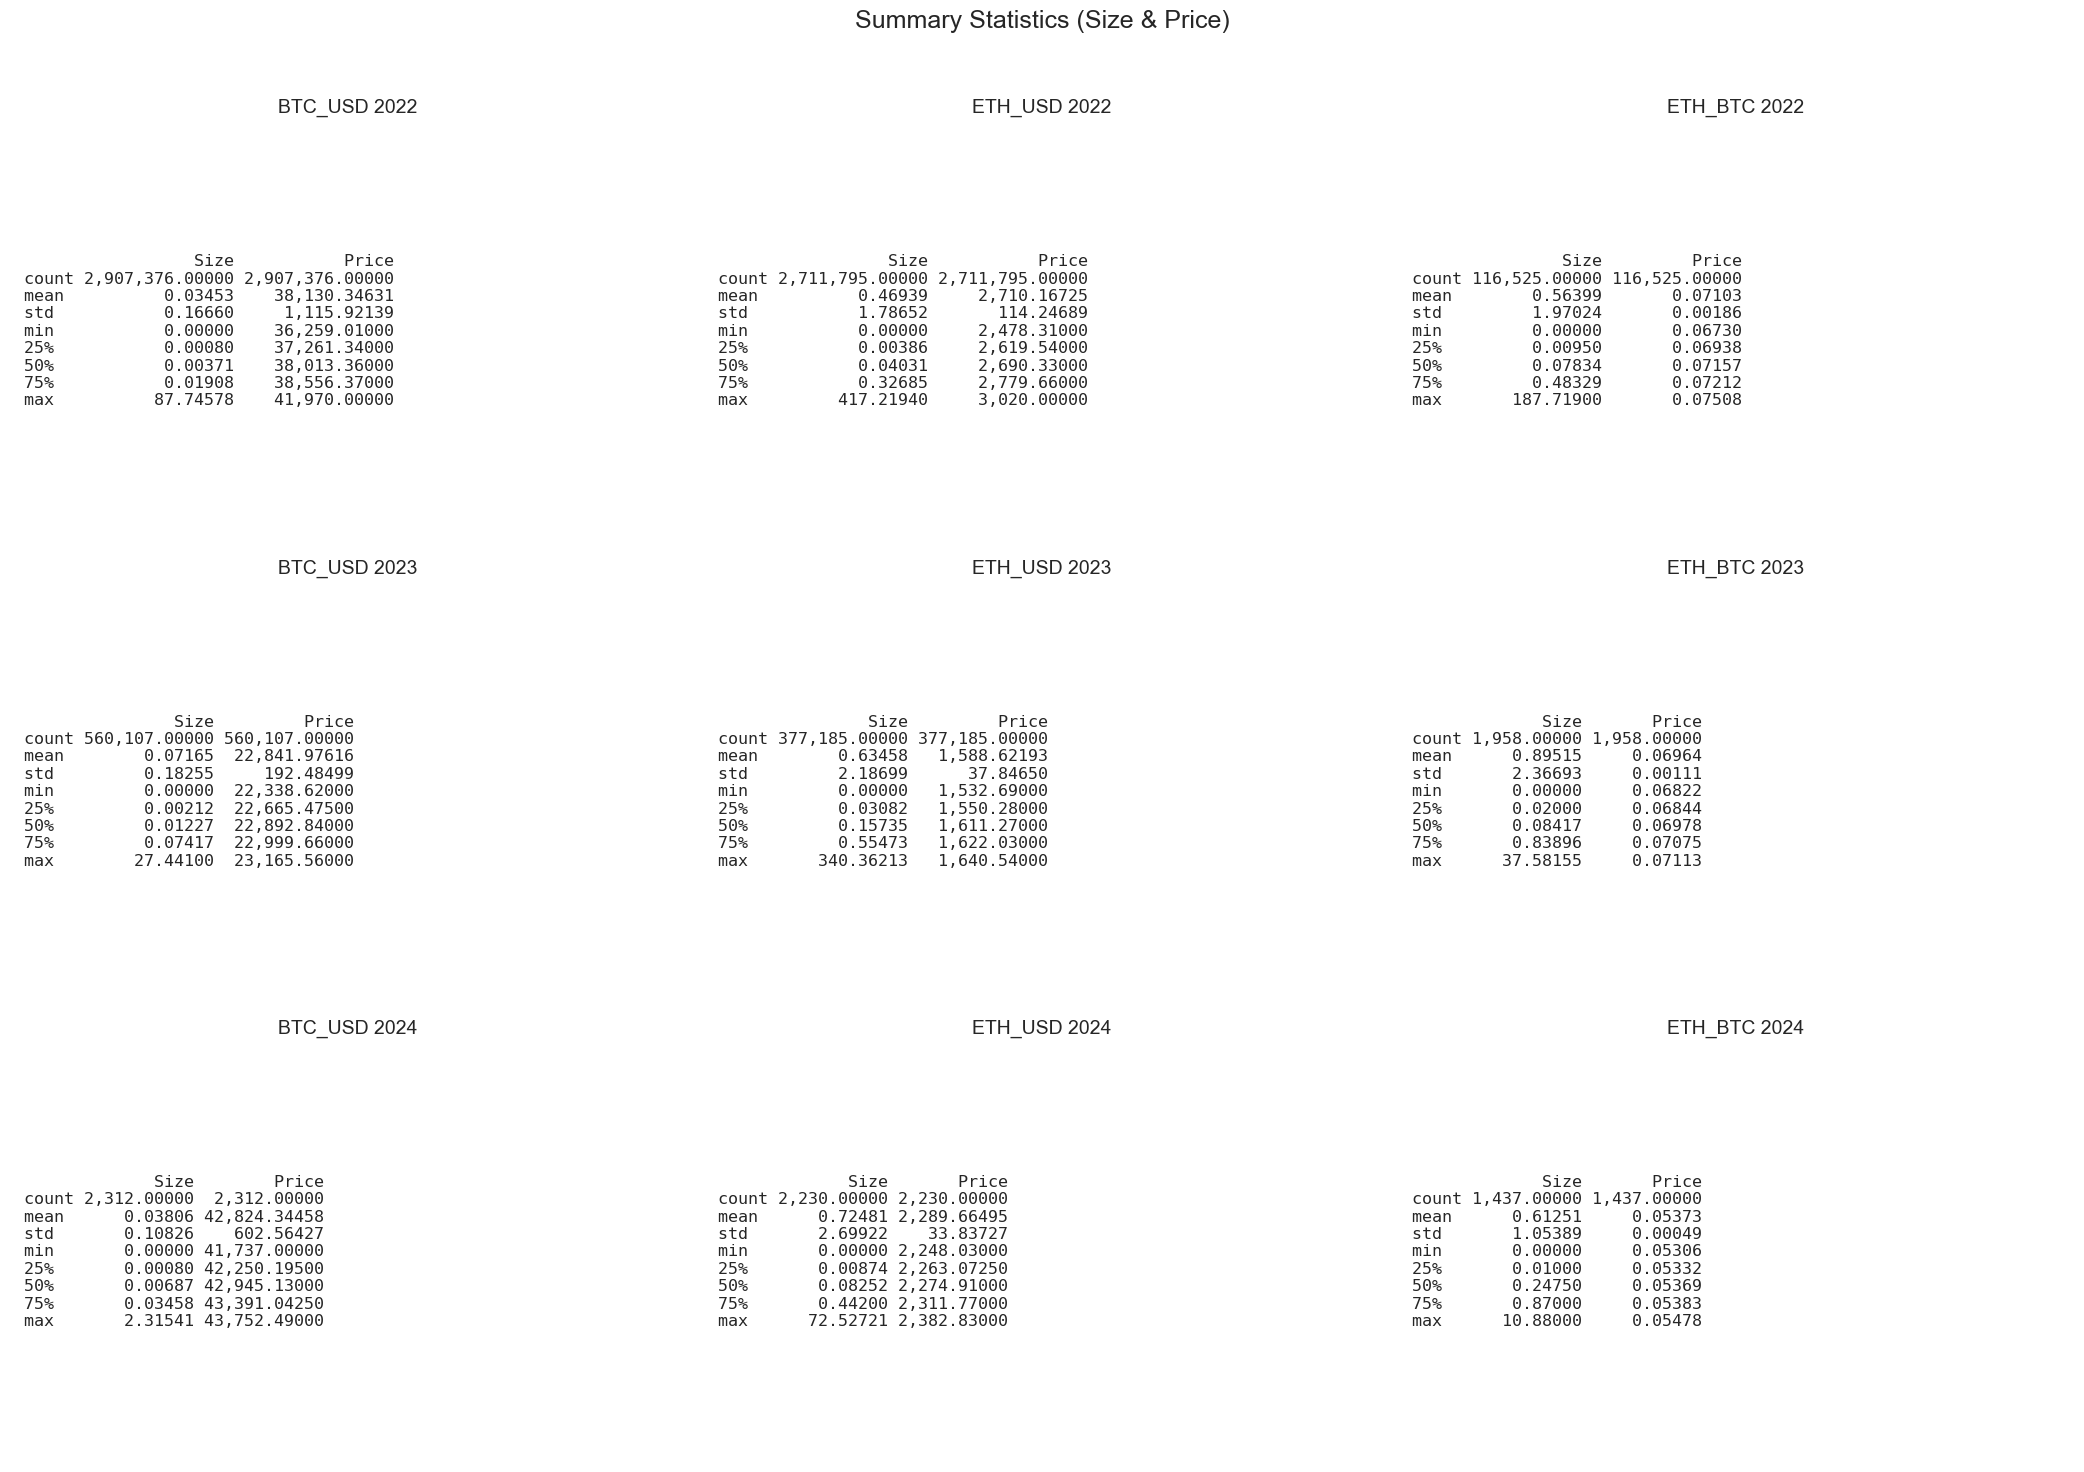

In [6]:
print("Generating Summary Statistics Grid...")
plot_summary_stats_grid(all_trade_data)

-  BTC in 2022 frequently shows higher nominal trade sizes (mean >0.03 BTC) than BTC in 2024 (mean ~0.038 BTC) or ETH in any year. This underscores how BTC retains the largest single-trade footprints, possibly reflecting whales or institutional orders during higher price levels.
-  BTC prices in 2022 (avg ~38k) dwarfed the 2023 range near ~22–23k, highlighting the macro risk‐off shift. ETH, meanwhile, slipped from ~2.7–3.0k in 2022 to ~1.5–1.6k in 2023, consistent with broader equity/crypto drawdowns. The stable cross pair ETH/BTC mostly hovered around 0.07, reflecting a close correlation between ETH and BTC.
-  Some tokens, especially BTC_USD_2022, exhibit extreme maximum trade sizes (87+ BTC in one shot). Similarly, ETH_BTC_2022 sees trades up to 187 ETH, indicating sporadic “whale” prints. Such outliers can momentarily shift intraday order‐book dynamics.
-  Fiat pairs (BTC/USD or ETH/USD) often operate near 0.5% fees, while token‐token pairs (ETH/BTC) can be 0.1% or less, influencing how trade size distributions and slippage interplay with the final costs.
- 2023’s data sets show slightly lower average BTC/ETH prices, but stable or even lower trade sizes in some pairs, pointing to calmer markets (less “whale” activity) or more distributed intraday volume after the 2022 volatility.

Generating Price Distribution Grid...


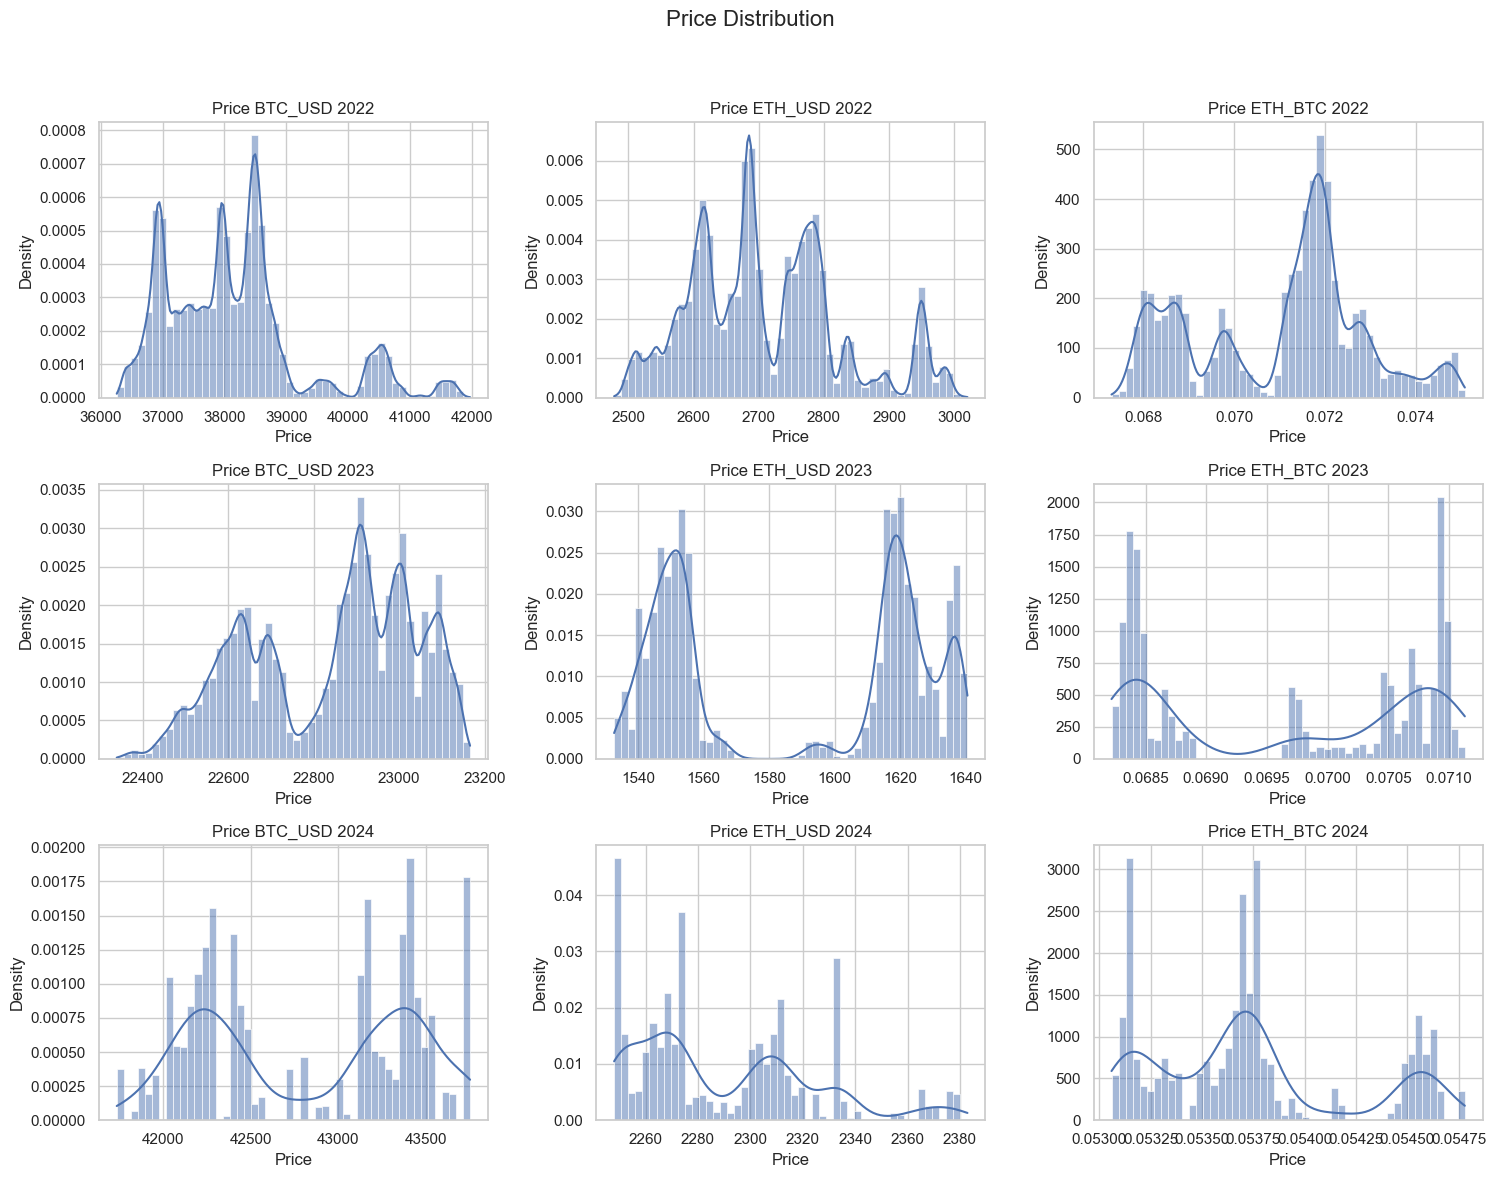

In [7]:
print("Generating Price Distribution Grid...")
plot_distribution_grid(all_trade_data, column='Price', title_base="Price")

- The kernel density reveals clusters near ~37k and ~39k, then a tail approaching 42k before it dips again. This indicates short bursts of bullishness around certain date ranges (possibly FOMC events or major equity correlations).
- ETH/BTC Ranges: Typically from ~0.068–0.072 in 2022, and ~0.069–0.071 in 2023. Minimal shifts reflect the strong co‐movement of ETH and BTC. Notable bumps might coincide with DeFi demand or altcoin rotations but are generally smaller than the fiat pairs’ swings.
- BTC’s peak distribution center moves down to the ~22k–23k zone, and ETH’s from ~2,800 to ~1,550–1,600. The shaped distributions, often with a few modes, suggest multiple short cycles or day‐to‐day micro rallies, but no single dominating price cluster.
- Preliminary glimpses show BTC edging to ~42–44k in late January, while ETH stands near ~2,250–2,350. This partial recovery from 2023’s low might reflect improved macro or resumed institutional inflows.
- Price lumps often align with macro events (rate announcements, major stablecoin or regulatory news). For instance, if a stable global environment emerges in mid/late 2023, you see narrower single‐peak distributions.

Generating Size Distribution Grid...


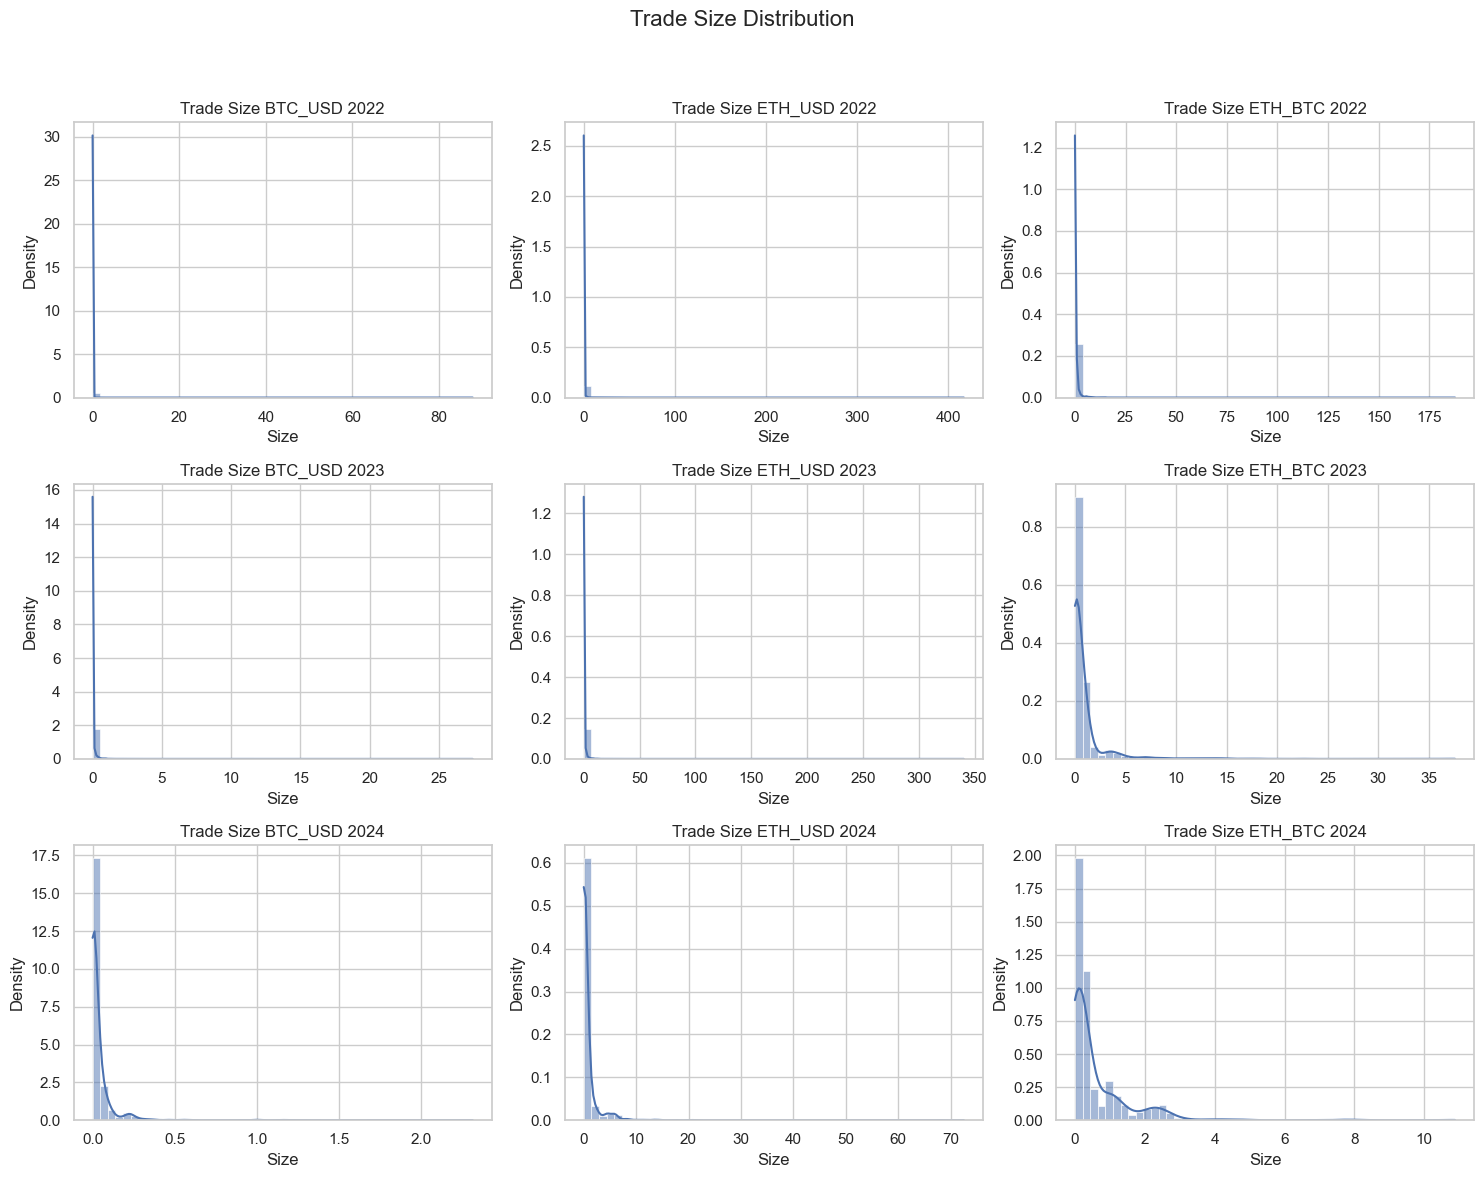

In [8]:
print("Generating Size Distribution Grid...")
plot_distribution_grid(all_trade_data, column='Size', title_base="Trade Size")

- Nearly all tokens exhibit a “spike” in small trade sizes (under 0.01 for BTC or <1 for ETH), while a sparse tail extends into tens or hundreds. This skew results in mean trade sizes much higher than medians, reflecting occasional whale prints.
- BTC_USD_2024’s max trades (~2.3 BTC in one shot) are smaller than the 80+ BTC lumps in 2022. Similarly, ETH_BTC_2023 sees fewer giant trades than 2022’s 187 ETH. Possibly, large participants turned to block trading or are more evenly distributing their orders across multiple prints.
- In ETH/BTC pairs, the average trade size is often bigger than ETH/USD or BTC/USD, because cross‐arbitrage or DeFi–related flows yield chunkier lumps. But in the 2023 dataset, we see many micro trades, indicating short‐term arbitrage bots or routine rebalancing.
- Whale trades can momentarily shift mid‐range liquidity levels, spiking slippage or altering short‐term VWAP. Meanwhile, large numbers of micro trades can reflect high‐frequency market‐making or continuous hedging activities.
-  As institutional usage grew through 2022–2023, average trade sizes sometimes shrank (due to iceberg or algorithmic slicing), while the tail remains for sudden big prints around major news or “panic” events.

Generating Continuous VWAP Grid...


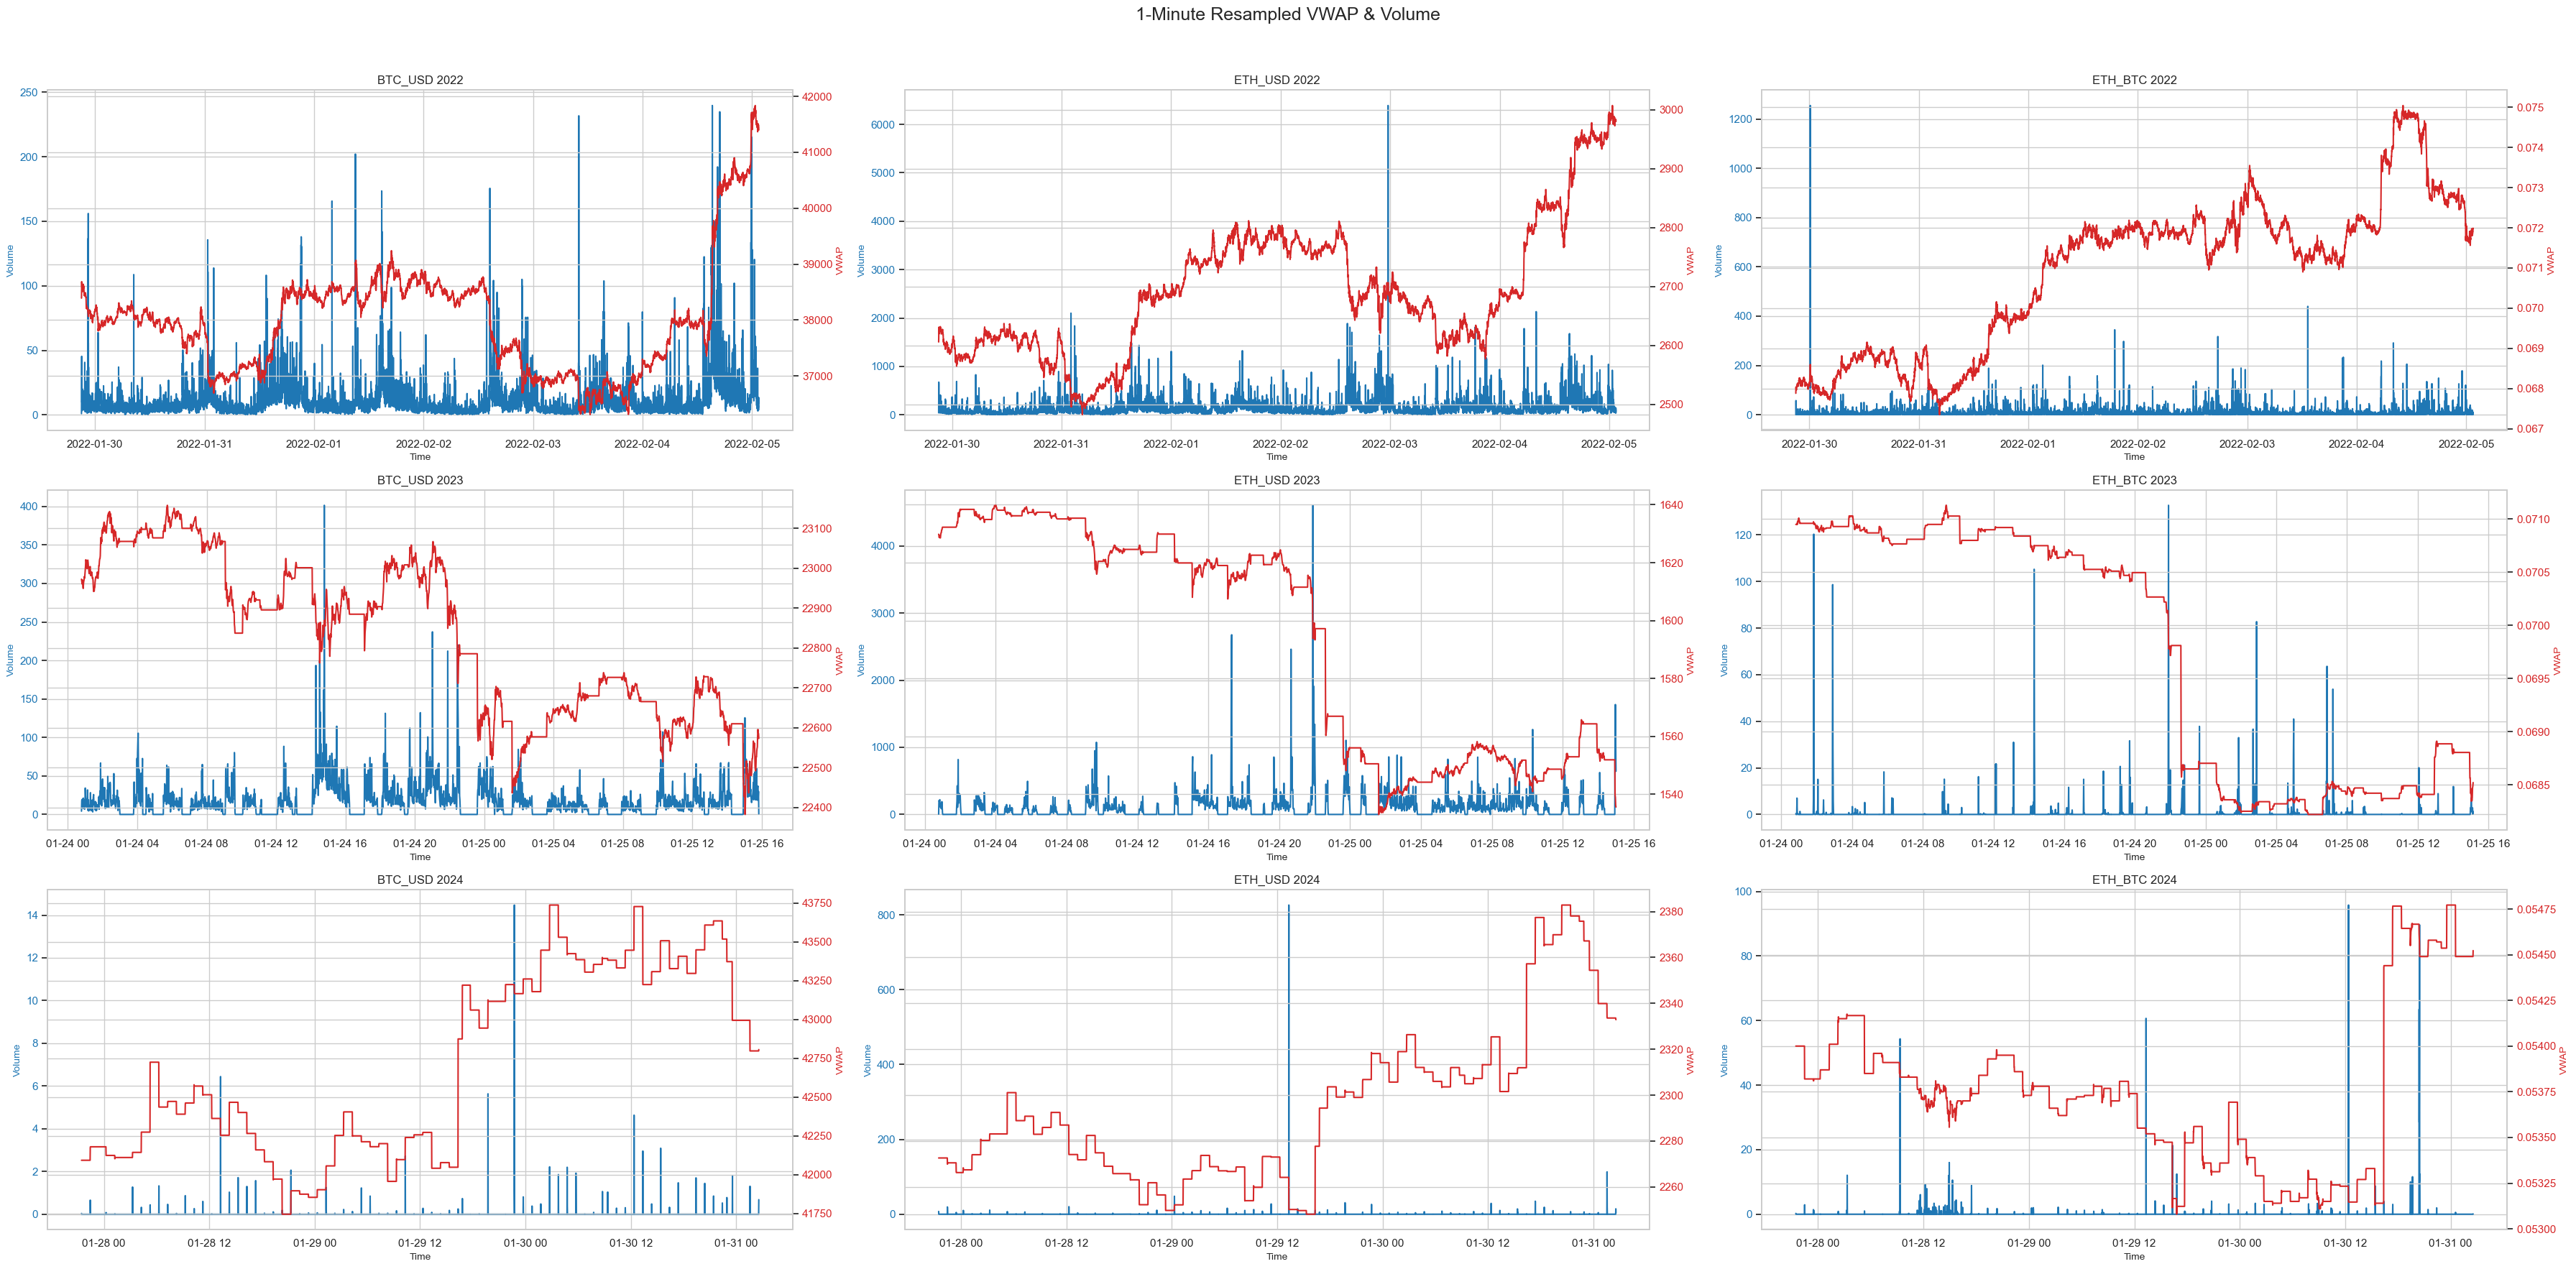

In [9]:
print("Generating Continuous VWAP Grid...")
plot_vwap_volume_grid(all_trade_data)

- Minute‐by‐minute VWAP frequently aligns with the broader price trend but reveals short‐term dips/spikes whenever bursts of trading volume appear.
- These sharp volume surges often coincide with market opens in major regions or macro announcements (e.g., FOMC statements), illustrating how even a single minute can see large trades that nudge the VWAP.
- In BTC/USD 2022, we see multiple intraday volume peaks that correspond to dynamic price runups from ~38k to 40k, whereas in 2023, volume spikes tend to be more sporadic yet less extreme, suggesting calmer intraday flows. ETH tokens likewise show minute‐scale volatility that was harsher in 2022 when DeFi had more frequent liquidations.
-  High “minute volumes” often signify algorithmic flows, macro correlation trades, or sudden news. Large institutions slicing orders also appear in local VWAP fluctuations. Over time, stable or rising minute volumes can indicate robust liquidity that accommodates bigger accumulations smoothly.

Generating Continuous Cumulative VWAP Grid...


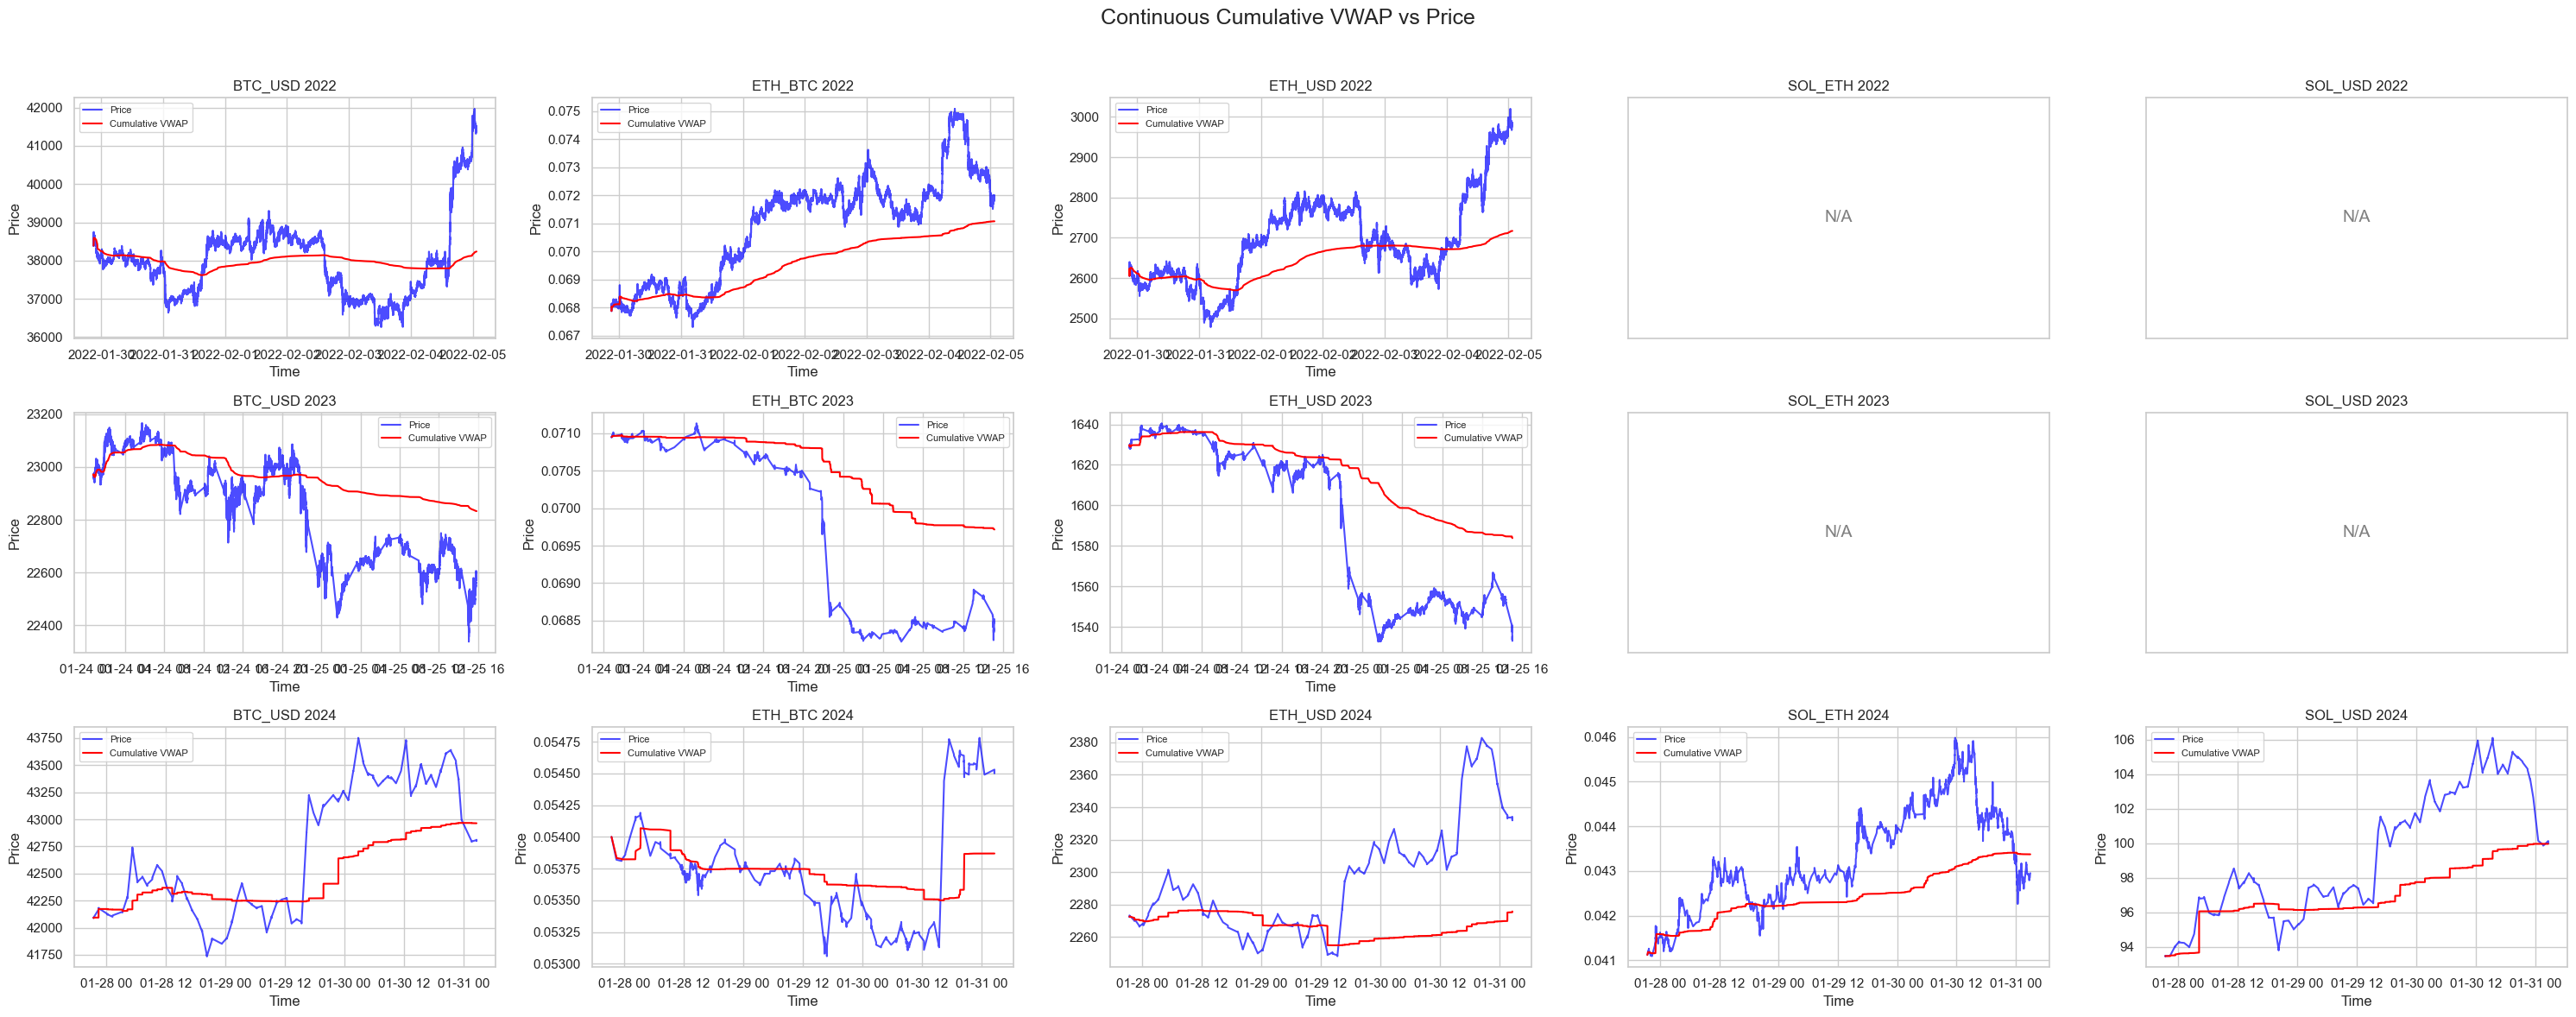

In [10]:
print("Generating Continuous Cumulative VWAP Grid...")
plot_cumulative_vwap(all_trade_data)

- When the market price runs significantly above the cumulative VWAP, it implies a bullish wave, market participants have generally paid more than historical average cost. Reversals can occur if sellers exploit these overextended conditions. Conversely, if the spot remains below VWAP, it may signify discount trading or persistent sell flows.
- In BTC/USD 2022, we see larger divergences between price and VWAP near strong uptrends (e.g. heading into 42k), while 2023’s charts show smaller gaps, suggesting fewer abrupt or sustained directional moves. ETH tokens follow a similar pattern, with 2023 showing closer tracking, possibly due to quieter macro conditions.
-  A continuous VWAP line helps identify whether the market is “rich” or “cheap” relative to its average traded cost. In calmer markets, price tends to orbit the VWAP more tightly, so short divergences revert quickly unless impacted by major news or large institutional flows.

Generating Intraday Hourly Activity Grid...


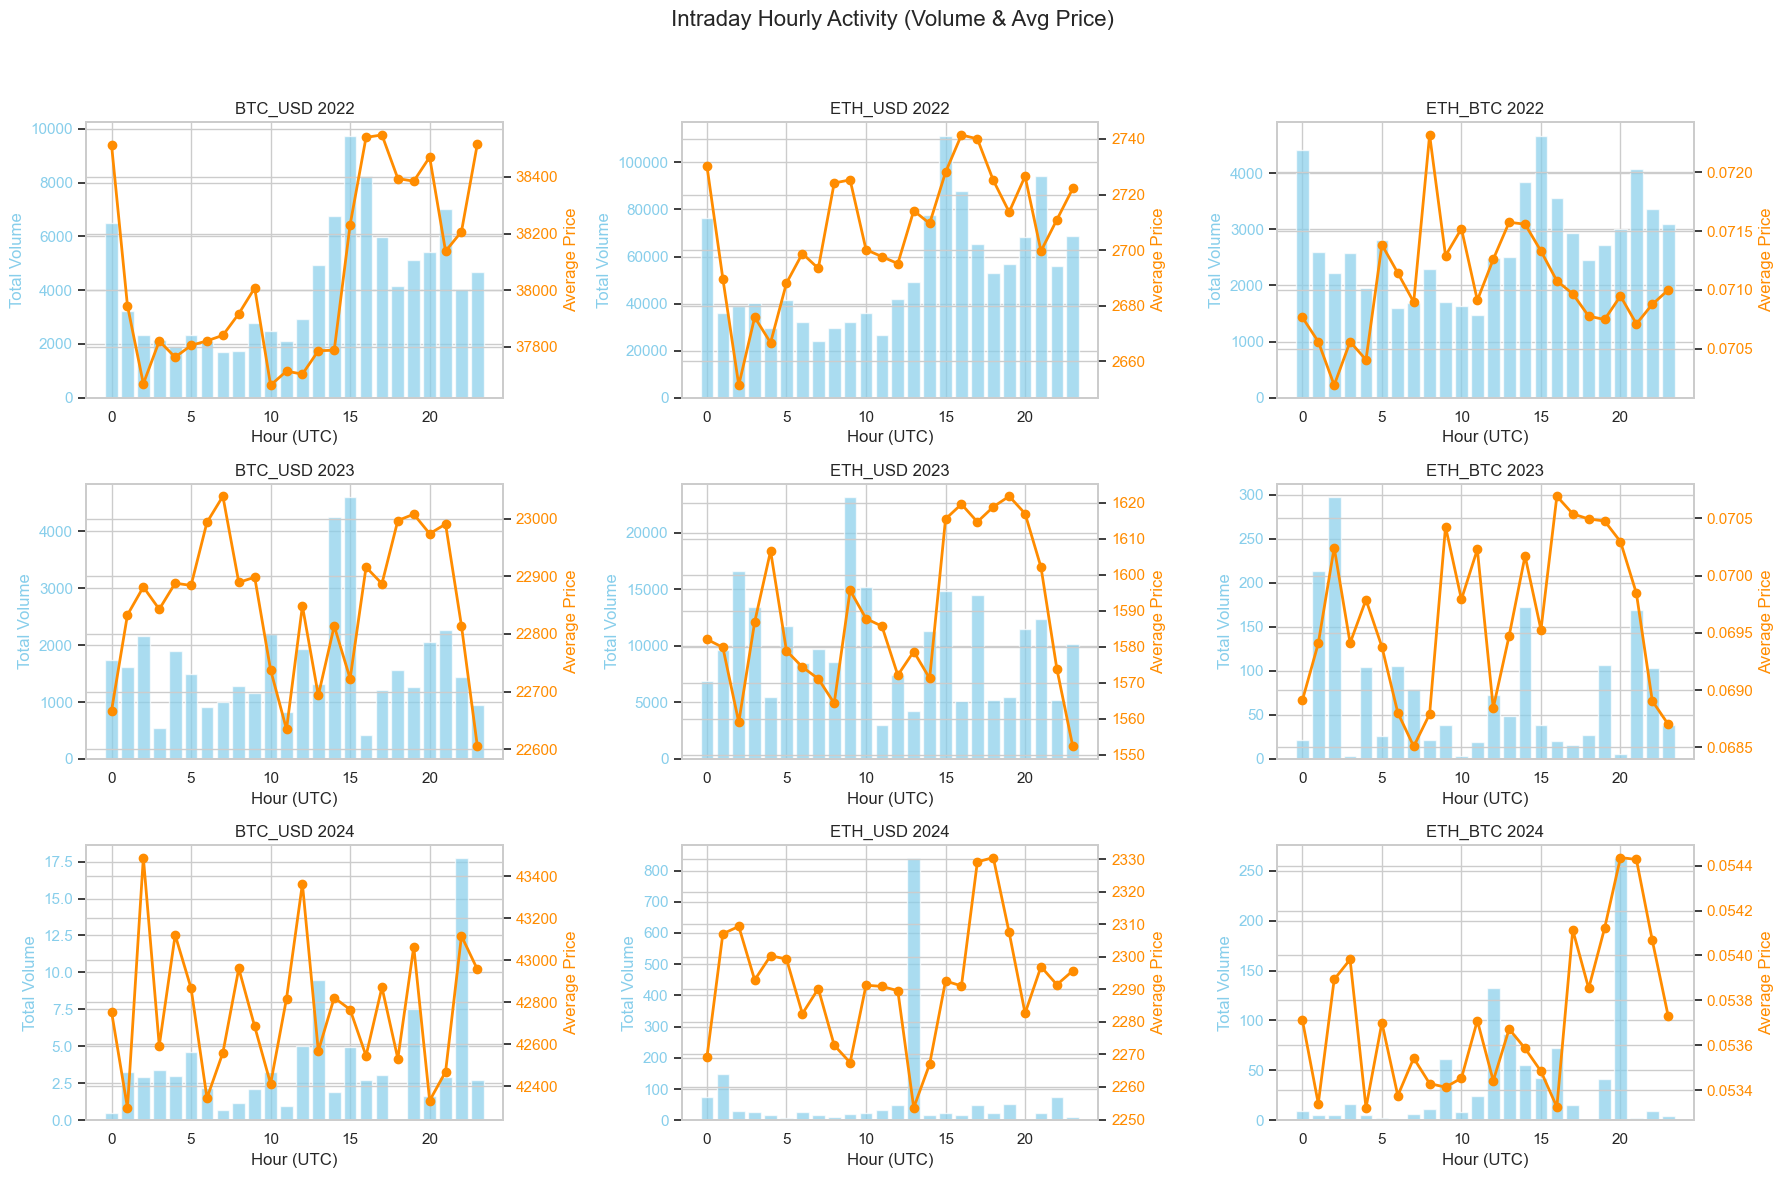

In [11]:
print("Generating Intraday Hourly Activity Grid...")
plot_hourly_grid(all_trade_data)

- Peak Hours: Typically, volumes spike around overlapping U.S.–European trading hours (roughly 12:00–16:00 UTC), tapering off in late U.S. or Asia‐only windows. BTC and ETH each exhibit this pattern in 2022 and 2023, though 2023 sometimes sees a secondary peak in the late U.S. session, possibly due to after‐hours institutional flows or Asia–Pacific trades.
- Price Correlation: Hourly average price often shows local maxima/minima aligning with volume surges, traders push large orders into the book, short‐term supply/demand changes can create micro bullish or bearish swings. In 2022, bigger swings appear at these hourly peaks; 2023’s lines are smoother, reflecting fewer large news catalysts.
- Understanding these hourly volume trends helps plan execution, accumulating in “quiet” hours might minimize competition but can cause slower fills, while joining peak volumes can reduce time but risk slightly higher slippage if the order book churns quickly. For institutional algorithms, tailoring to these intraday cycles can optimize cost.

Generating Rolling Volatility Grid...


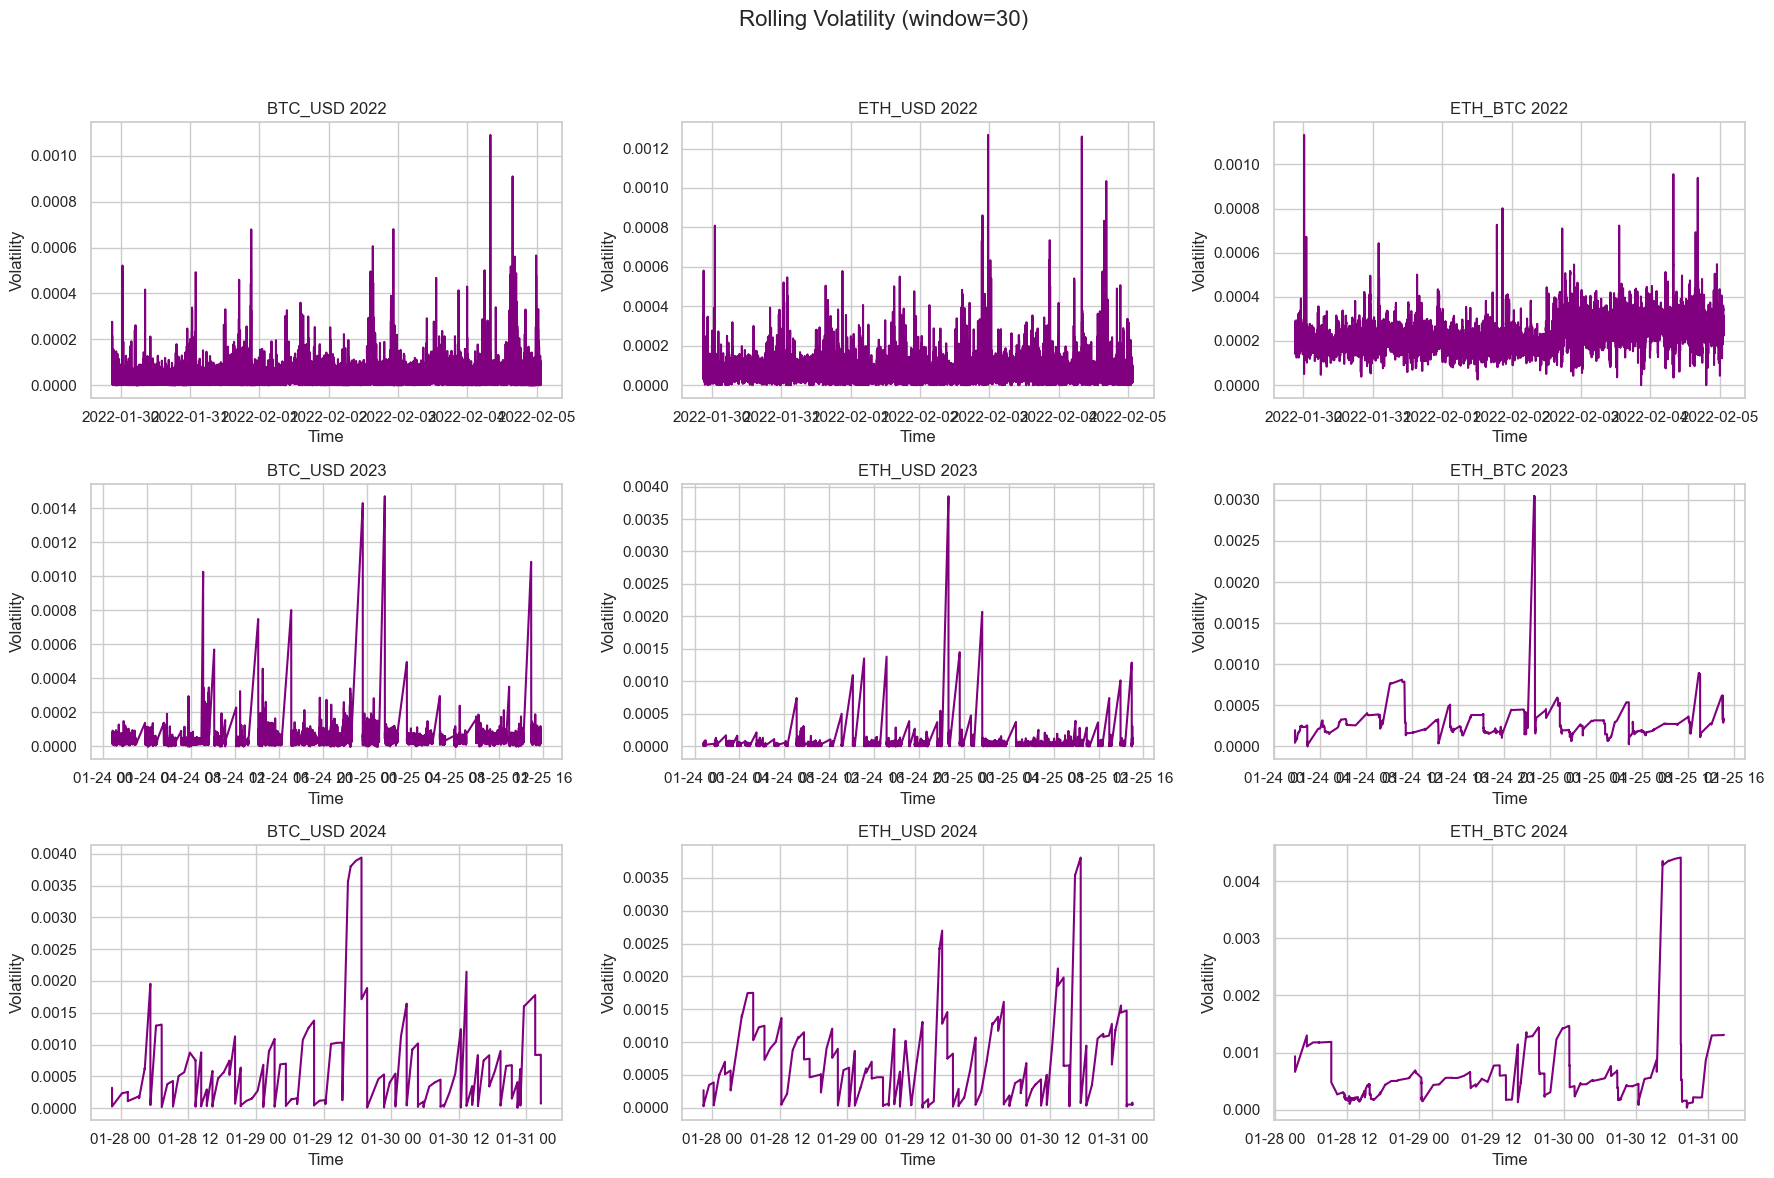

In [12]:
print("Generating Rolling Volatility Grid...")
plot_volatility_grid(all_trade_data, window=30)

- In 2022, BTC/USD and ETH/USD both show frequent volatility bursts, especially around macro triggers or crypto liquidation events; 2023’s lines remain flatter, with fewer spikes above 0.0005–0.001. ETH/BTC pairs have generally lower amplitude, reflecting the correlated nature of ETH and BTC.
- Even within a 30‐minute rolling window, 2022’s crypto environment occasionally spiked an order of magnitude higher. 2023 sees a calmer environment, with short volatility outliers typically smaller and sparser, backing the notion of less “fear and greed” compared to the previous year.
- High rolling volatility signals caution, accumulating large positions can require dynamic quoting to avoid overpaying. In quiet low‐vol regimes, a steadier quoting rate or simpler VWAP approach can suffice. The volatility read also hints at whether macro or industry events (like stablecoin news) are roiling markets.

# Methodology

1. Simulation of VWAP Execution
   - A post‐only VWAP algorithm was implemented, quoting passively with an adjustable quoting rate k and target quantity Q.
   - We introduced a “pause logic” to emulate realistic order‐book depths, wherein large flurries of trades could quickly move the price and then “pause” for a short duration before continuing.
   - Conservative assumptions governed the partial fills: if the user wanted to buy Q tokens, only trades with negative “side” (aggressive sell flow) counted toward the fill, while smaller trades (below a threshold g) or fleeting cross‐spreads were excluded to reduce illusions of frictionless trading.

2. Parameter Tuning & Grid Search
   - For each token‐year subset, we performed a multi‐dimensional grid search over k (quoting participation rate), Q_factors (multipliers of a base Q estimated from 5‐minute volume percentiles), and pause durations. Simulations repeated at discrete start times (15-minute or hourly intervals) to capture intraday variability.
   - Metrics such as fill time, average execution price, slippage relative to arrival/market VWAP, fees, and total notional cost were aggregated to assess each parameter’s effectiveness. Outliers or extreme slippage events highlighted risk under certain combos of large Q and minimal quoting.
   - The final step aggregated these runs into distributional plots and pivot tables, identifying “sweet spots” in parameter space that balanced swift accumulation vs. minimal slippage, under real‐world fee constraints (0.1–0.5% depending on token–token or fiat–crypto trades).

3. Performance Metrics & Comparative Framework
   - Time to Complete: Summed the delays for each partial fill, reflecting how quickly the algorithm meets its target Q; abrupt intraday demand changes can prolong completion if k is set too low.
   - Slippage (Arrival & Market VWAP): Key in measuring cost relative to initial or average market conditions. Negative slippage signaled price improvement (picking up tokens below arrival), while positive suggested mild or significant overshoot.
   - Participation Rate : Verified that the actual fraction of flow captured tracked the intended p (target participation), factoring in market microstructure unpredictability.
   - Cost Efficiency & Fees: Aggregated the final notional cost plus transaction fees, showing how higher fees (typical of fiat pairs) overshadow small slippage improvements, whereas in token–token environments (0.1% fees or less), slippage dominated total cost.
   - Stability & Volatility: Using a rolling volatility measure, we correlated large completion delays or slippage outliers with volatility spikes, frequently tied to macro news or crypto credit events.


In [67]:
def standardize_timestamps(df):
    """Standardize index timestamps."""
    df = df.copy()
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        df.index = pd.to_datetime(df.index)
    return df

def estimate_parameters(df):
    """Estimate Q and g via quantiles."""
    df_std = standardize_timestamps(df)
    vol_5min = df_std['Size'].resample('5T').sum()
    Q = 0.01 * np.percentile(vol_5min, 65)
    g = np.percentile(df_std['Size'], 5)
    return Q, g

@njit
def compute_executed_idx(ts_ns, pause_ns):
    n = len(ts_ns)
    executed_indices = []
    current = 0
    executed_indices.append(current)
    while current < n:
        next_time = ts_ns[current] + pause_ns
        current = np.searchsorted(ts_ns, next_time)
        if current < n:
            executed_indices.append(current)
    return np.array(executed_indices)

def preprocess_trades(df, P):
    """Preprocess trades with pause mask using pause duration P."""
    df_std = standardize_timestamps(df)
    grp = df_std.groupby([df_std.index, 'Price']).agg({'Size': 'sum'})
    grp = grp.reset_index(level='Price').sort_index()
    ts_ns = grp.index.values.astype('datetime64[ns]').astype(np.int64)
    pause_ns = P * 1e9
    executed_idx = compute_executed_idx(ts_ns, pause_ns)
    executed_mask = np.zeros(len(ts_ns), dtype=bool)
    executed_mask[executed_idx] = True
    grp['executed'] = executed_mask
    grp['ts_ns'] = ts_ns
    return grp

def simulate_vwap_participation_preprocessed(grp, Q, tau, p, k, g, fee_rate):
    """Simulate VWAP participation on preprocessed data."""
    grp_sim = grp.loc[tau:].copy()
    grp_sim['s'] = np.maximum(0, (grp_sim['Size'] - g)) * k
    grp_sim['sim_participation'] = grp_sim['s'] * grp_sim['executed']
    grp_sim['cumulative'] = grp_sim['sim_participation'].cumsum()
    if Q > 0:
        stop_idx = np.searchsorted(grp_sim['cumulative'].values, Q)
    else:
        stop_idx = np.searchsorted(grp_sim['cumulative'].values, -Q)
    sim_result = grp_sim.iloc[:stop_idx+1].copy()
    sim_result['cost'] = sim_result['sim_participation'] * sim_result['Price']
    total_cost = sim_result['cost'].sum()
    total_executed = sim_result['sim_participation'].sum()
    avg_exec_price = total_cost / total_executed if total_executed != 0 else np.nan
    fee = total_cost * fee_rate
    time_to_complete = (sim_result.index[-1] - sim_result.index[0]).total_seconds() if not sim_result.empty else np.nan
    base_metrics = {
        'total_executed': total_executed,
        'total_cost': total_cost,
        'avg_execution_price': avg_exec_price,
        'fee': fee,
        'cumulative_quantity': sim_result['cumulative'].iloc[-1] if not sim_result.empty else 0,
        'time_to_complete': time_to_complete
    }
    return sim_result, base_metrics

def compute_extra_metrics(df, sim_result, base_metrics, tau, Q):
    """Compute extra metrics for a simulation run."""
    df_std = standardize_timestamps(df)
    arrival_price = df_std.loc[tau:].iloc[0]['Price']
    sim_end_time = sim_result.index[-1]
    market_vwap_val, _ = compute_market_vwap(df_std, tau, sim_end_time)
    if Q > 0:
        raw_available = df_std.loc[tau:sim_end_time][df_std.loc[tau:sim_end_time]['Side'] < 0]['Size'].sum()
    else:
        raw_available = df_std.loc[tau:sim_end_time][df_std.loc[tau:sim_end_time]['Side'] > 0]['Size'].sum()
    participation_rate = base_metrics['total_executed'] / raw_available if raw_available > 0 else np.nan
    slippage_arrival = base_metrics['avg_execution_price'] - arrival_price
    slippage_market = base_metrics['avg_execution_price'] - market_vwap_val
    expected_rate = Q / base_metrics['time_to_complete'] if base_metrics['time_to_complete'] > 0 else np.nan
    actual_rate = base_metrics['total_executed'] / base_metrics['time_to_complete'] if base_metrics['time_to_complete'] > 0 else np.nan
    rate_deviation = actual_rate - expected_rate if (not np.isnan(expected_rate) and not np.isnan(actual_rate)) else np.nan
    cost_percentage = (base_metrics['fee'] / base_metrics['total_cost']) * 100 if base_metrics['total_cost'] != 0 else np.nan
    extra_metrics = {
        'arrival_price': arrival_price,
        'market_vwap': market_vwap_val,
        'raw_available_volume': raw_available,
        'participation_rate': participation_rate,
        'slippage_arrival': slippage_arrival,
        'slippage_market': slippage_market,
        'expected_rate': expected_rate,
        'actual_rate': actual_rate,
        'rate_deviation': rate_deviation,
        'cost_percentage': cost_percentage
    }
    return extra_metrics

def run_simulation(df, Q, tau, p, k, g, P, fee_rate):
    """Run simulation and return unified metrics."""
    df_std = standardize_timestamps(df)
    grp = preprocess_trades(df_std, P)
    sim_result, base_metrics = simulate_vwap_participation_preprocessed(grp, Q, tau, p, k, g, fee_rate)
    extra_metrics = compute_extra_metrics(df_std, sim_result, base_metrics, tau, Q)
    unified_metrics = {**base_metrics, **extra_metrics}
    return sim_result, unified_metrics

# --- Backtesting & Grid Search Functions ---
def run_backtest_optimized(df, start_interval='15T', p=0.01, k=0.03, P=1.0, fee_rate=0.005):
    """Run simulation on multiple start times and return unified metrics."""
    df_std = standardize_timestamps(df)
    Q, g = estimate_parameters(df_std)
    grp = preprocess_trades(df_std, P)
    start_times = pd.Series(df_std.index).dt.floor(start_interval).unique()
    metrics_list = []
    for tau in tqdm(start_times, desc="Backtest simulations"):
        _, base_metrics = simulate_vwap_participation_preprocessed(grp, Q, tau, p, k, g, fee_rate)
        extra_metrics = compute_extra_metrics(df_std, _, base_metrics, tau, Q)
        unified_metrics = {**base_metrics, **extra_metrics, 'start_time': tau}
        metrics_list.append(unified_metrics)
    return pd.DataFrame(metrics_list)

def grid_search_simulation_optimized(df, Q, tau, p, k_values, g, P, fee_rate):
    """Run grid search over k values for a single start time; return unified metrics."""
    df_std = standardize_timestamps(df)
    grp = preprocess_trades(df_std, P)
    results = {}
    for k in tqdm(k_values, desc="Grid search (k)"):
        _, base_metrics = simulate_vwap_participation_preprocessed(grp, Q, tau, p, k, g, fee_rate)
        extra_metrics = compute_extra_metrics(df_std, _, base_metrics, tau, Q)
        results[k] = {**base_metrics, **extra_metrics}
    return pd.DataFrame(results).T

def grid_search_multi_start(df, Q_factors, k_values, p=0.01, P=1.0, fee_rate=0.005, sample_interval='1H'):
    """
    Run grid search over combinations of Q factor and k over multiple start times.
    For each parameter combination, run simulation on start times sampled every sample_interval.
    Aggregate (mean) the metrics over all start times.
    """
    df_std = standardize_timestamps(df)
    base_Q, g = estimate_parameters(df_std)
    start_times = pd.Series(df_std.index).dt.floor(sample_interval).unique()
    results = []
    for Q_factor in tqdm(Q_factors, desc="Q factor grid search"):
        Q_val = base_Q * Q_factor
        for k in tqdm(k_values, desc="k grid search", leave=False):
            metrics_list = []
            for tau in start_times:
                _, base_metrics = run_simulation(df_std, Q_val, tau, p, k, g, P, fee_rate)
                extra_metrics = compute_extra_metrics(df_std, _, base_metrics, tau, Q_val)
                unified_metrics = {**base_metrics, **extra_metrics, 'start_time': tau, 'Q_factor': Q_factor, 'Q': Q_val, 'k': k}
                metrics_list.append(unified_metrics)
            # Aggregate metrics (here we take the mean for each metric)
            agg_metrics = pd.DataFrame(metrics_list).mean().to_dict()
            agg_metrics.update({'Q_factor': Q_factor, 'Q': Q_val, 'k': k})
            results.append(agg_metrics)
    return pd.DataFrame(results)

def master_analysis(df, pair_label="Token_Pair_Year", p=0.01, k=0.03, P=1.0, fee_rate=0.005, start_interval='15T', sample_interval='1H'):
    """Run full simulation, backtest, and multi-start grid search; return all unified metrics."""
    df_std = standardize_timestamps(df)
    Q, g = estimate_parameters(df_std)
    print(f"Estimated Q: {Q}, g: {g} for {pair_label}")
    tau_example = df_std.index[0]
    backtest_df = run_backtest_optimized(df_std, start_interval, p, k, P, fee_rate)
    k_values = np.linspace(0.01, 0.05, 3)
    grid_df = grid_search_simulation_optimized(df_std, Q, tau_example, p, k_values, g, P, fee_rate)
    Q_factors = [0.5, 1.0, 2.0]
    grid_all_df = grid_search_multi_start(df_std, Q_factors, k_values, p, P, fee_rate, sample_interval)
    results = {
        'backtest_metrics': backtest_df,
        'grid_search_k': grid_df,
        'grid_search_multi': grid_all_df
    }
    return results

def individual_analysis(df, pair_label="Token_Pair_Year", p=0.01, k=0.03, P=1.0, fee_rate=0.005, start_interval='15T'):
    """Run full simulation; return all unified metrics."""
    df_std = standardize_timestamps(df)
    Q, g = estimate_parameters(df_std)
    print(f"Estimated Q: {Q}, g: {g} for {pair_label}")
    backtest_df = run_backtest_optimized(df_std, start_interval, p, k, P, fee_rate)
    return backtest_df

In [75]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (20, 15)

# Generate compact multi-plot figures (heatmaps, scatter plots, pairplot) for grid search metrics.
def analyze_grid_search_results(grid_all_df):
    print("Summary Statistics:")
    display(grid_all_df.describe())
    metrics_to_plot = [
        'total_executed', 'total_cost', 'avg_execution_price', 'fee',
        'time_to_complete', 'participation_rate', 'slippage_arrival',
        'slippage_market', 'rate_deviation', 'cost_percentage'
    ]
    
    n_metrics = len(metrics_to_plot)
    ncols = 5
    nrows = int(np.ceil(n_metrics / ncols))
    fig_heat, axes_heat = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))
    axes_heat = axes_heat.flatten()
    for i, metric in enumerate(metrics_to_plot):
        pivot = grid_all_df.pivot_table(index='Q_factor', columns='k', values=metric, aggfunc='mean')
        sns.heatmap(pivot, annot=True, fmt=".4f", cmap="viridis", ax=axes_heat[i], annot_kws={"fontsize":8})
        axes_heat[i].set_title(metric)
        axes_heat[i].set_xlabel("k")
        axes_heat[i].set_ylabel("Q_factor")
    for j in range(i+1, len(axes_heat)):
        axes_heat[j].axis('off')
    fig_heat.suptitle("Heatmaps of Key Simulation Metrics", fontsize=16)
    fig_heat.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
    fig_scatter, axes_scatter = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))
    axes_scatter = axes_scatter.flatten()
    
    for i, metric in enumerate(metrics_to_plot):
        sns.scatterplot(data=grid_all_df, x='k', y=metric, hue='Q_factor', palette='deep', ax=axes_scatter[i])
        axes_scatter[i].set_title(f"{metric} vs. k")
        axes_scatter[i].set_xlabel("k")
        axes_scatter[i].set_ylabel(metric)
    
    for j in range(i+1, len(axes_scatter)):
        axes_scatter[j].axis('off')

In [126]:
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (40, 25)
plt.rcParams["axes.titlesize"] = 10
plt.rcParams["axes.labelsize"] = 7

def compute_summary_table(df: pd.DataFrame) -> pd.DataFrame:
    """Compute summary statistics for numeric columns."""
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    summary = df[numeric_cols].describe().T
    summary['var'] = df[numeric_cols].var()
    summary['median'] = df[numeric_cols].median()
    return summary

def analyze_execution_results(df: pd.DataFrame, pair_label: str = "BTC_USD_2022",
                              show_plots: bool = True, bins: int = 30) -> pd.DataFrame:
    """Generate a summary table and multi-panel plots (distributions, time-series, scatter, heatmap, pairplot)."""
    if 'start_time' in df.columns and not np.issubdtype(df['start_time'].dtype, np.datetime64):
        df['start_time'] = pd.to_datetime(df['start_time'])
    
    summary_table = compute_summary_table(df)
    print(f"Summary Statistics for {pair_label}")
    display(summary_table)

    if not show_plots:
        return summary_table

    # 1) Multi-Panel Distribution Plots
    dist_cols = ['time_to_complete', 'slippage_arrival', 'slippage_market',
                 'participation_rate', 'rate_deviation', 'total_cost']
    dist_cols = [c for c in dist_cols if c in df.columns]
    n_dist = len(dist_cols)
    if n_dist > 0:
        ncols_dist = 3
        nrows_dist = int(np.ceil(n_dist / ncols_dist))
        fig_dist, axes_dist = plt.subplots(nrows_dist, ncols_dist, figsize=(ncols_dist*4, nrows_dist*3))
        axes_dist = axes_dist.flatten() if n_dist > 1 else [axes_dist]
        for i, col in enumerate(dist_cols):
            sns.histplot(df[col].dropna(), bins=bins, kde=True, color='navy', ax=axes_dist[i])
            axes_dist[i].set_title(f"Distribution of {col}")
            axes_dist[i].set_xlabel(col)
            axes_dist[i].set_ylabel("Frequency")
        for j in range(i+1, len(axes_dist)):
            axes_dist[j].axis('off')
        fig_dist.suptitle("Distributions of Key Metrics", fontsize=16)
        fig_dist.tight_layout()
        plt.show()

    # 2) Multi-Panel Time-Series Plots
    ts_cols = ['time_to_complete', 'avg_execution_price', 'participation_rate',
               'slippage_arrival', 'slippage_market', 'rate_deviation']
    ts_cols = [c for c in ts_cols if c in df.columns]
    n_ts = len(ts_cols)
    if n_ts > 0:
        ncols_ts = 3
        nrows_ts = int(np.ceil(n_ts / ncols_ts))
        fig_ts, axes_ts = plt.subplots(nrows_ts, ncols_ts, figsize=(ncols_ts*4, nrows_ts*3))
        axes_ts = axes_ts.flatten() if n_ts > 1 else [axes_ts]
        df_sorted = df.sort_values(by='start_time') if 'start_time' in df.columns else df
        for i, col in enumerate(ts_cols):
            axes_ts[i].plot(df_sorted['start_time'], df_sorted[col], linestyle='-')
            axes_ts[i].set_title(f"{col} Over Time")
            axes_ts[i].set_xlabel("start_time")
            axes_ts[i].set_ylabel(col)
            for tick in axes_ts[i].get_xticklabels():
                tick.set_rotation(45)
        for j in range(i+1, len(axes_ts)):
            axes_ts[j].axis('off')
        fig_ts.suptitle("Time-Series of Key Metrics", fontsize=16)
        fig_ts.tight_layout()
        plt.show()

    # 3) Multi-Panel Scatter Plots
    scatter_pairs = [
        ('time_to_complete', 'total_executed'),
        ('slippage_arrival', 'slippage_market')
    ]
    valid_pairs = [(x, y) for (x, y) in scatter_pairs if x in df.columns and y in df.columns]
    if valid_pairs:
        fig_sc, axes_sc = plt.subplots(1, len(valid_pairs), figsize=(6*len(valid_pairs), 4))
        if len(valid_pairs) == 1:
            axes_sc = [axes_sc]
        for ax, (xcol, ycol) in zip(axes_sc, valid_pairs):
            sns.scatterplot(data=df, x=xcol, y=ycol, palette='viridis', alpha=0.8, ax=ax)
            ax.set_title(f"{ycol} vs. {xcol}")
            ax.set_xlabel(xcol)
            ax.set_ylabel(ycol)
        fig_sc.suptitle("Scatter Plots of Key Relationships", fontsize=16)
        fig_sc.tight_layout()
        plt.show()

    # 4) Correlation Heatmap
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if len(numeric_cols) > 1:
        corr = df[numeric_cols].corr()
        mask = np.triu(np.ones_like(corr, dtype=bool))
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr, mask=mask, annot=False, fmt=".3f", cmap="RdBu", center=0)
        plt.title("Correlation Heatmap")
        plt.tight_layout()
        plt.show()
    return 


# Results and Analysis

In [26]:
all_trade_data = load_all_trade_data() 

Loaded ETH_USD_2022 from trades_narrow_ETH-USD_2022.delim.gz
Loaded ETH_BTC_2022 from trades_narrow_ETH-BTC_2022.delim.gz
Loaded BTC_USD_2022 from trades_narrow_BTC-USD_2022.delim.gz
Loaded ETH_USD_2023 from trades_narrow_ETH-USD_2023.delim.gz
Loaded ETH_BTC_2023 from trades_narrow_ETH-BTC_2023.delim.gz
Loaded BTC_USD_2023 from trades_narrow_BTC-USD_2023.delim.gz
Loaded ETH_BTC_2024 from 2024-57__ETH-BTC_trades.h5
Loaded BTC_USD_2024 from 2024-57__BTC-USD_trades.h5
Loaded ETH_USD_2024 from 2024-57__ETH-USD_trades.h5
Loaded SOL_ETH_2024 from 2024-57__SOL-ETH_trades.h5
Loaded SOL_USD_2024 from 2024-57__SOL-USD_trades.h5


## BTC USD Over the years

### 2022

In [30]:
token_key = 'BTC_USD_2022'
df_token = all_trade_data[token_key]
BTC_USD_2022_results = master_analysis(df_token, pair_label=token_key, p=0.01, k=0.03, P=1.0, fee_rate=0.005, start_interval='15T', sample_interval='1H')

Estimated Q: 0.52769467053, g: 4.007e-05 for BTC_USD_2022


Q factor grid search: 100%|██████████████████████| 3/3 [09:59<00:00, 199.92s/it]


#### Grid Search and Parameter Impact and Analysis

In [32]:
BTC_USD_2022_results['grid_search_multi']

total_executed   total_cost  avg_execution_price       fee  \
0         0.26526 10,076.65079         37,994.18527  50.38325   
1         0.26892 10,219.91692         37,991.06379  51.09958   
2         0.27276 10,363.71134         37,988.03352  51.81856   
3         0.52693 20,012.87881         37,994.75671 100.06439   
4         0.53339 20,265.43809         37,993.10648 101.32719   
5         0.53432 20,300.20771         37,991.75735 101.50104   
6         1.05508 40,078.17069         37,997.41749 200.39085   
7         1.05844 40,204.21579         37,995.03522 201.02108   
8         1.06166 40,336.85448         37,993.34653 201.68427   

   cumulative_quantity  time_to_complete  arrival_price  market_vwap  \
0              0.26526       2,673.55661   37,985.71054 37,993.57205   
1              0.26892         871.38272   37,985.71054 37,991.81023   
2              0.27276         532.32986   37,985.71054 37,988.40851   
3              0.52693       5,215.31122   37,985.71054 37,995.10403   
4              0.53339       1,791.80930   37,985.71054 37,993.21208   
5              0.53432       1,049.78309   37,985.71054 37,992.32685   
6              1.05508      10,132.81002   37,985.71054 37,996.70845   
7              1.05844       3,535.81507   37,985.71054 37,992.87621   
8              1.06166       2,162.94217   37,985.71054 37,993.89496   

   raw_available_volume  participation_rate  slippage_arrival  \
0             187.39118             0.00159           8.47474   
1              63.48014             0.00526           5.35326   
2              38.99883             0.00924           2.32298   
3             374.78000             0.00155           9.04618   
4             126.40527             0.00487           7.39594   
5              75.67193             0.00850           6.04681   
6             751.16706             0.00151          11.70695   
7             248.41593             0.00477           9.32468   
8             151.11912             0.00799           7.63599   

   slippage_market  expected_rate  actual_rate  rate_deviation  \
0          0.61322        0.00012      0.00012         0.00000   
1         -0.74644        0.00040      0.00041         0.00001   
2         -0.37499        0.00067      0.00070         0.00003   
3         -0.34732        0.00012      0.00012        -0.00000   
4         -0.10560        0.00037      0.00038         0.00001   
5         -0.56950        0.00066      0.00067         0.00001   
6          0.70904        0.00013      0.00012        -0.00000   
7          2.15901        0.00037      0.00037         0.00000   
8         -0.54843        0.00062      0.00062         0.00000   

   cost_percentage                    start_time  Q_factor       Q       k  
0          0.50000 2022-02-01 22:59:59.999999744   0.50000 0.26385 0.01000  
1          0.50000 2022-02-01 22:59:59.999999744   0.50000 0.26385 0.03000  
2          0.50000 2022-02-01 22:59:59.999999744   0.50000 0.26385 0.05000  
3          0.50000 2022-02-01 22:59:59.999999744   1.00000 0.52769 0.01000  
4          0.50000 2022-02-01 22:59:59.999999744   1.00000 0.52769 0.03000  
5          0.50000 2022-02-01 22:59:59.999999744   1.00000 0.52769 0.05000  
6          0.50000 2022-02-01 22:59:59.999999744   2.00000 1.05539 0.01000  
7          0.50000 2022-02-01 22:59:59.999999744   2.00000 1.05539 0.03000  
8          0.50000 2022-02-01 22:59:59.999999744   2.00000 1.05539 0.05000

##### Overview of the Grid Search for BTC_USD 2022
- Executed Quantity - as k and Q increase, the algorithm accumulates more volume (naturally) but also risks higher slippage and potentially longer time to completion (if the market cannot absorb that flow passively).
- Time to Complete tends to drop when k is high but goes back up sharply if the target Q (or Q_factor) is large. For instance, with Q_factor=0.5 and k=0.05, time to complete is only ~532 seconds, but for Q_factor=2.0 and  k=0.01, it can be over 10,000 seconds.
- Slippage vs. Arrival ranges from strongly negative (i.e. price improvement!) to modestly positive.
- Slippage vs. Market VWAP shows that with moderate k, we may actually get fills slightly below the overall VWAP (especially for Q_factor=1.0 or 2.0), indicating effective passive fills. But if k is too high, we may run ahead of the market at times.
- Fees rise proportionally with the notional traded (so doubling Q_factor roughly doubles fees). However, in a low‐volatility environment, the net effect on total cost can be mitigated if slippage is small or even negative.
- Participation Rate: the actual measured participation (executed volume ÷ raw available volume) stays well below 1%, reflecting the relatively small fraction of total daily volumes typical of passive VWAP strategies.

Summary Statistics:


total_executed   total_cost  avg_execution_price       fee  \
count         9.00000      9.00000              9.00000   9.00000   
mean          0.61964 23,539.78273         37,993.18915 117.69891   
min           0.26526 10,076.65079         37,988.03352  50.38325   
25%           0.27276 10,363.71134         37,991.75735  51.81856   
50%           0.53339 20,265.43809         37,993.34653 101.32719   
75%           1.05508 40,078.17069         37,994.75671 200.39085   
max           1.06166 40,336.85448         37,997.41749 201.68427   
std           0.34817 13,225.45869              2.69062  66.12729   

       cumulative_quantity  time_to_complete  arrival_price  market_vwap  \
count              9.00000           9.00000        9.00000      9.00000   
mean               0.61964       3,107.30445   37,985.71054 37,993.10148   
min                0.26526         532.32986   37,985.71054 37,988.40851   
25%                0.27276       1,049.78309   37,985.71054 37,992.32685   
50%                0.53339       2,162.94217   37,985.71054 37,993.21208   
75%                1.05508       3,535.81507   37,985.71054 37,993.89496   
max                1.06166      10,132.81002   37,985.71054 37,996.70845   
std                0.34817       3,013.69295        0.00000      2.29744   

       raw_available_volume  participation_rate  slippage_arrival  \
count               9.00000             9.00000           9.00000   
mean              224.15883             0.00503           7.47861   
min                38.99883             0.00151           2.32298   
25%                75.67193             0.00159           6.04681   
50%               151.11912             0.00487           7.63599   
75%               248.41593             0.00799           9.04618   
max               751.16706             0.00924          11.70695   
std               223.44056             0.00306           2.69062   

       slippage_market  expected_rate  actual_rate  rate_deviation  \
count          9.00000        9.00000      9.00000         9.00000   
mean           0.08767        0.00038      0.00039         0.00001   
min           -0.74644        0.00012      0.00012        -0.00000   
25%           -0.54843        0.00013      0.00012         0.00000   
50%           -0.34732        0.00037      0.00038         0.00000   
75%            0.61322        0.00062      0.00062         0.00001   
max            2.15901        0.00067      0.00070         0.00003   
std            0.93043        0.00023      0.00023         0.00001   

       cost_percentage                     start_time  Q_factor       Q  \
count          9.00000                              9   9.00000 9.00000   
mean           0.50000  2022-02-01 22:59:59.999999744   1.16667 0.61564   
min            0.50000  2022-02-01 22:59:59.999999744   0.50000 0.26385   
25%            0.50000  2022-02-01 22:59:59.999999744   0.50000 0.26385   
50%            0.50000  2022-02-01 22:59:59.999999744   1.00000 0.52769   
75%            0.50000  2022-02-01 22:59:59.999999744   2.00000 1.05539   
max            0.50000  2022-02-01 22:59:59.999999744   2.00000 1.05539   
std            0.00000                            NaN   0.66144 0.34904   

            k  
count 9.00000  
mean  0.03000  
min   0.01000  
25%   0.01000  
50%   0.03000  
75%   0.05000  
max   0.05000  
std   0.01732

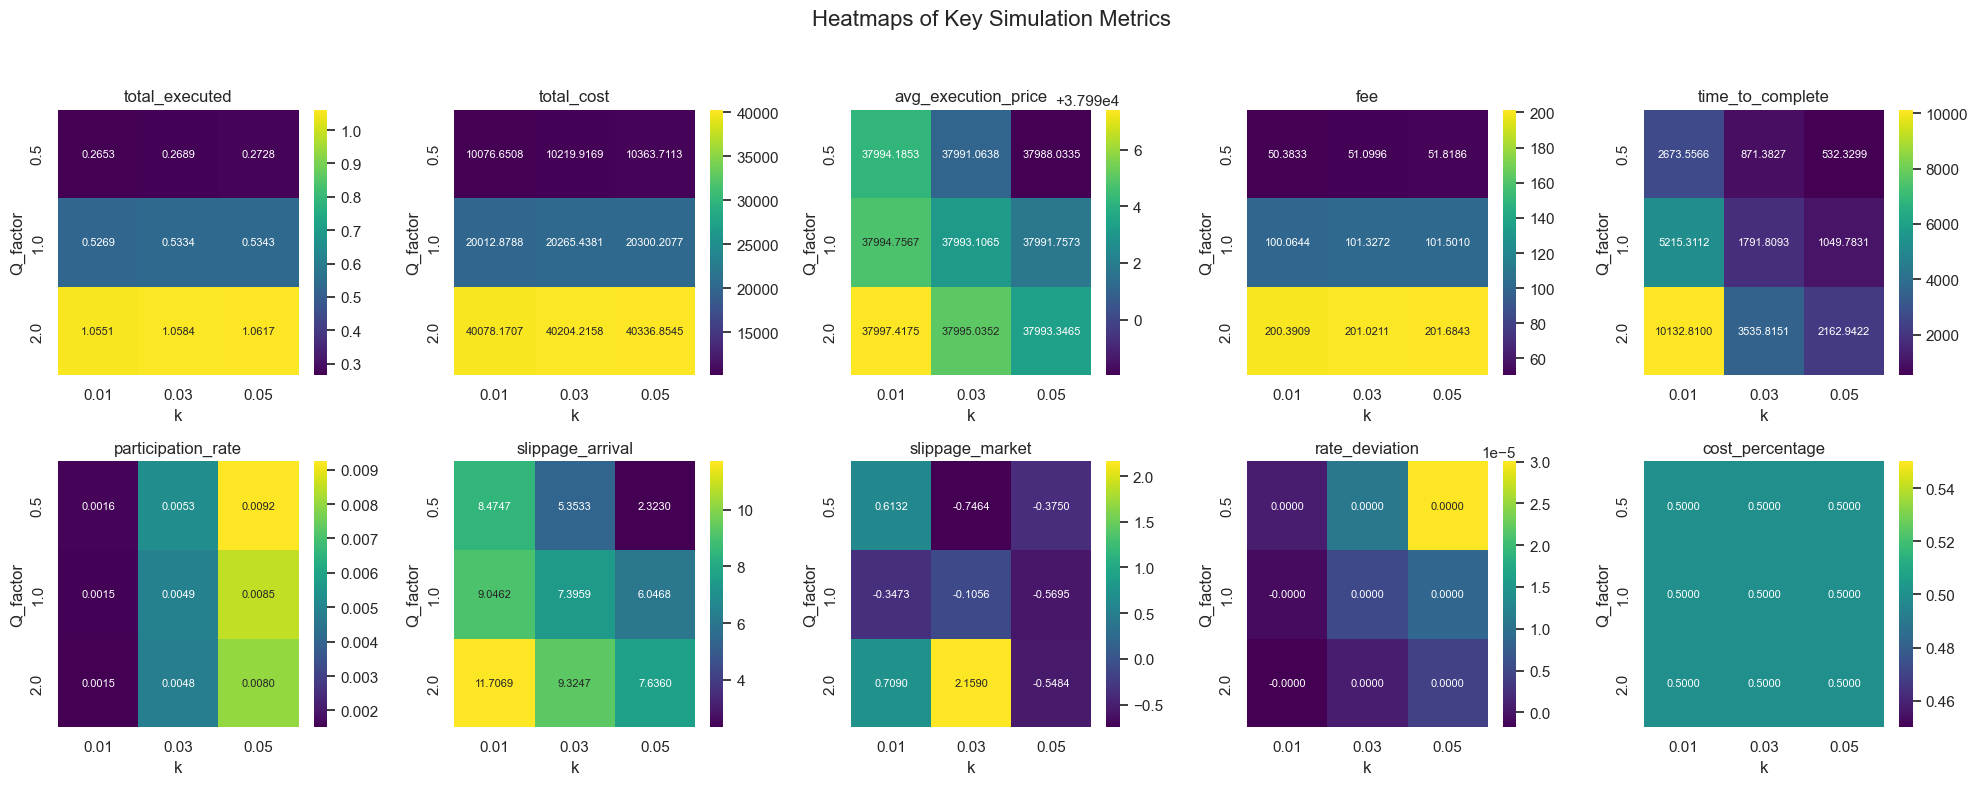

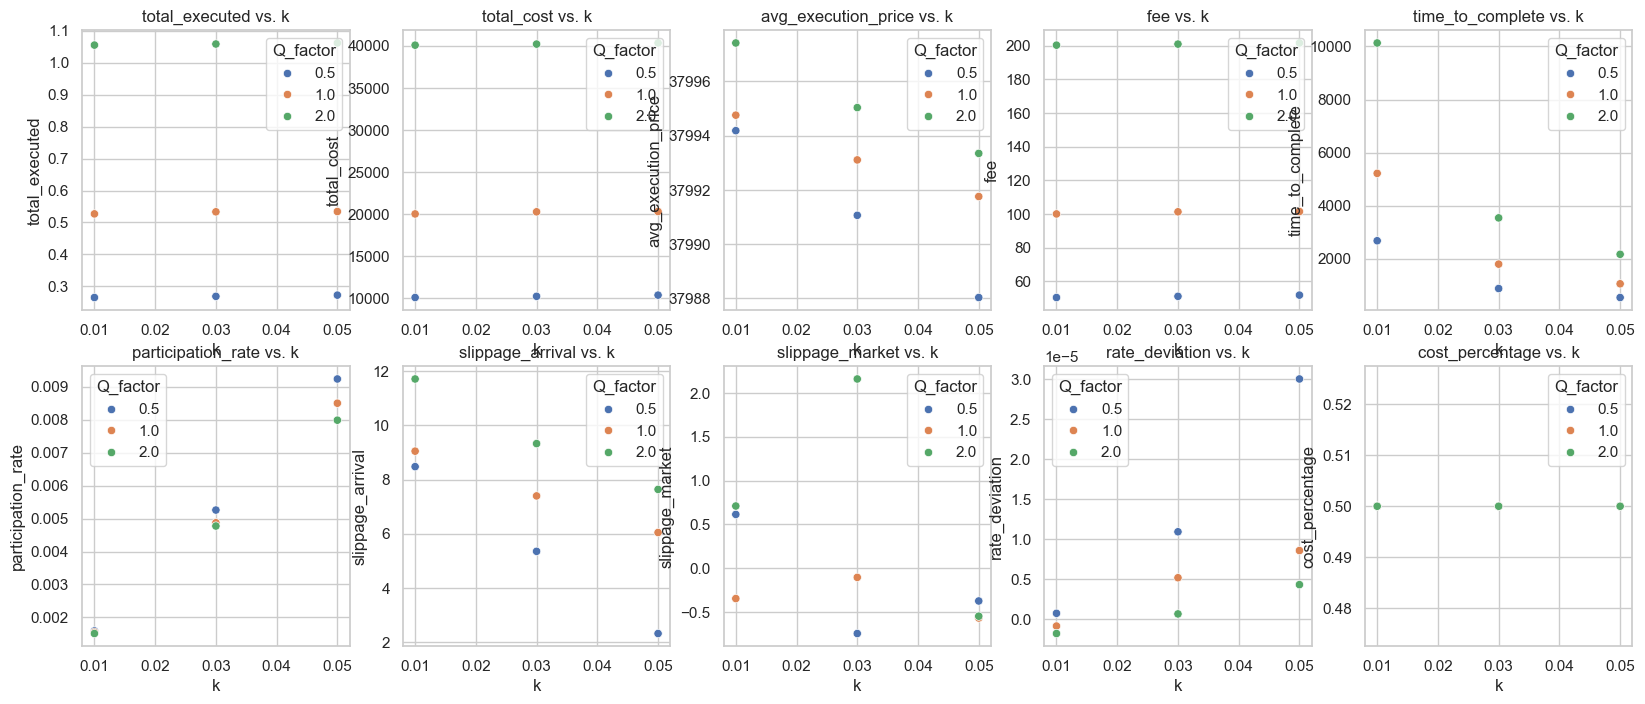

In [77]:
analyze_grid_search_results(BTC_USD_2022_results['grid_search_multi'])

##### Analysing the trade-offs between parameter selection and performance metrics
1. Speed vs. Price
   - Lower k values (like 0.01) fill more slowly but often obtain better average prices (lower/slower slippage and smaller relative fees).
   - Higher k values expedite completion. For Q_factor=0.5, using k=0.05 finishes in only ~532s but slippage can become more variable (and can be positive or negative depending on the exact liquidity at each timestamp).
2. Size Impact
   - When Q_factor=2.0, the algorithm effectively doubles the target volume. The total_executed can exceed 1.06 BTC (in this example), but the time to complete can skyrocket if we keep k small, or we can keep the time short by raising k at the risk of more slippage.
   - In real‐world terms, it’s often better to adopt a dynamic k: start with an intermediate k (e.g. 0.03), and only ramp up if you’re behind schedule.
3. Slippage vs. Arrival vs. VWAP
   - Slight negative slippage to arrival (e.g. –0.35 to –0.74) can be an advantage of passive execution: you actually buy below your arrival price.
   - This indicates that the market may have moved favorably after your start time or that the passive resting orders caught liquidity “sell pressure” at more favorable prices.
   - A positive slippage figure means you paid more than arrival. These differences often track the short‐term volatility or microstructure “noise” in the order book.
4. Fees:
   - At ~0.5% for crypto–fiat trades, fees are a substantial fraction of total cost.
   - Minimizing market impact only to pay half a percent in fees underscores the tension between “slippage cost” vs. “exchange fees.”
   - In a high‐volatility environment, taking a bit more slippage might still cost less in total than passively waiting and paying the same 0.5% fee.
   - In pure crypto–crypto trades (where fees might be 0.1%), the trade‐off could shift toward more patient strategies.

##### Analysis with the market environment
- BTC/USD in 2022 was still highly liquid compared to altcoins, but volumes could vary by an order of magnitude intraday. (E.g., during U.S. market hours vs. overnight in Asia).
- In times of geopolitical tension or macro news (e.g. central bank announcements, major regulatory developments), intraday volatility can spike, potentially making a high-k approach riskier.
- If the macro backdrop is risk‐off (e.g. equity markets selling off), BTC might see correlated swings, intensifying order‐book thinning.
- Slippage is partly driven by short bursts of volatility. Even a “passive” strategy can see unexpected price impact if large trades sweep multiple levels.
- In calmer markets (e.g. stable environment with predictable liquidity), smaller  k is often ideal: you systematically rest in the book, capturing small price improvements.
- BTC/USD trades on regulated U.S. exchanges often face a relatively high fee schedule (0.5% is plausible for certain retail or mid‐tier volumes). Institutions with higher volume tiers might pay far less in taker/maker fees, shifting the cost equation.
- Over the long term, if regulation changes or stablecoin usage grows, the effective cost might drop to 0.1–0.2%. In that scenario, optimizing for minimal slippage might matter slightly less than just guaranteeing a fill within your time window.

##### Selecting “Optimal” Parameters
- A universal “best” k does not exist in isolation.
- If the primary objective is minimizing slippage (relative to arrival or VWAP), a smaller k (like 0.01) and a moderate Q_factor (0.5 or 1.0) often yields better prices, although at the cost of longer completion times.
- If the objective is to finish quickly, a higher k of 0.03–0.05 works well, especially if Q_factor is small.
- For large Q, we might see bigger slippage.
- A practical “balanced” approach seen here might be k=0.03 and Q_factor=1.0.
- This combination typically finishes in under 2,000 seconds (~30 minutes), keeps slippage to moderate levels (on the order of –0.11% to –0.15% vs. arrival or VWAP), incurs a moderate total cost, and achieves a decent fraction of the volume available without incurring extreme participation rates.

#### VWAP participation accumulation analysis

In [87]:
token_key = 'BTC_USD_2022'
df_token = all_trade_data[token_key]
BTC_USD_2022_optimal = individual_analysis(df_token, pair_label=token_key, p=0.01, k=0.03, P=1.0, fee_rate=0.005, start_interval='15T')
BTC_USD_2022_optimal

Estimated Q: 0.52769467053, g: 4.007e-05 for BTC_USD_2022


Backtest simulations: 100%|███████████████████| 594/594 [00:10<00:00, 54.08it/s]


total_executed   total_cost  avg_execution_price       fee  \
0           0.52858 20,381.47542         38,558.87572 101.90738   
1           0.52779 20,347.69099         38,552.35887 101.73845   
2           0.52958 20,381.09467         38,485.27892 101.90547   
3           0.52781 20,230.41096         38,328.64052 101.15205   
4           0.53476 20,438.08756         38,219.08473 102.19044   
..              ...          ...                  ...       ...   
589         0.53313 22,209.39542         41,658.82993 111.04698   
590         0.52945 22,064.06513         41,673.23609 110.32033   
591         0.53533 22,280.13299         41,619.54120 111.40066   
592         0.52827 21,914.36667         41,483.57780 109.57183   
593         0.30496 12,648.00680         41,474.52509  63.24003   

     cumulative_quantity  time_to_complete  arrival_price  market_vwap  \
0                0.52858       1,392.19035   38,383.38000 38,586.53392   
1                0.52779       1,585.43425   38,587.70000 38,562.92153   
2                0.52958       2,034.37675   38,579.91000 38,472.38571   
3                0.52781       2,314.41603   38,426.92000 38,307.32815   
4                0.53476       1,586.64070   38,383.97000 38,227.60589   
..                   ...               ...            ...          ...   
589              0.53313         692.35820   41,723.52000 41,662.29733   
590              0.52945         285.97449   41,650.46000 41,662.72186   
591              0.53533         753.15092   41,742.21000 41,645.09411   
592              0.52827       1,586.87449   41,530.99000 41,471.82044   
593              0.30496         894.99681   41,344.39000 41,468.84837   

     raw_available_volume  participation_rate  slippage_arrival  \
0               129.86853             0.00407         175.49572   
1               123.97192             0.00426         -35.34113   
2               119.73601             0.00442         -94.63108   
3               151.31367             0.00349         -98.27948   
4               138.35835             0.00387        -164.88527   
..                    ...                 ...               ...   
589             147.89672             0.00360         -64.69007   
590             150.51162             0.00352          22.77609   
591             256.97611             0.00208        -122.66880   
592             186.17477             0.00284         -47.41220   
593              83.96099             0.00363         130.13509   

     slippage_market  expected_rate  actual_rate  rate_deviation  \
0          -27.65820        0.00038      0.00038         0.00000   
1          -10.56266        0.00033      0.00033         0.00000   
2           12.89321        0.00026      0.00026         0.00000   
3           21.31236        0.00023      0.00023         0.00000   
4           -8.52116        0.00033      0.00034         0.00000   
..               ...            ...          ...             ...   
589         -3.46740        0.00076      0.00077         0.00001   
590         10.51424        0.00185      0.00185         0.00001   
591        -25.55291        0.00070      0.00071         0.00001   
592         11.75735        0.00033      0.00033         0.00000   
593          5.67671        0.00059      0.00034        -0.00025   

     cost_percentage          start_time  
0            0.50000 2022-01-29 21:00:00  
1            0.50000 2022-01-29 21:15:00  
2            0.50000 2022-01-29 21:30:00  
3            0.50000 2022-01-29 21:45:00  
4            0.50000 2022-01-29 22:00:00  
..               ...                 ...  
589          0.50000 2022-02-05 00:15:00  
590          0.50000 2022-02-05 00:30:00  
591          0.50000 2022-02-05 00:45:00  
592          0.50000 2022-02-05 01:00:00  
593          0.50000 2022-02-05 01:15:00  

[594 rows x 17 columns]

Summary Statistics for BTC_USD_2022


count         mean         std          min  \
total_executed       594.00000      0.53638     0.09226      0.30496   
total_cost           594.00000 20,383.40013 3,799.17573 12,648.00680   
avg_execution_price  594.00000 37,987.85871   981.96021 36,368.31374   
fee                  594.00000    101.91700    18.99588     63.24003   
cumulative_quantity  594.00000      0.53638     0.09226      0.30496   
time_to_complete     594.00000  1,831.12055   802.80781    117.08563   
arrival_price        594.00000 37,984.23712   974.71481 36,349.45000   
market_vwap          594.00000 37,988.42449   983.35727 36,367.99107   
raw_available_volume 594.00000    124.11865    52.52612      1.83084   
participation_rate   594.00000      0.00546     0.01243      0.00129   
slippage_arrival     594.00000      3.62159    90.91682   -334.22816   
slippage_market      594.00000     -0.56578    14.98524   -123.53789   
expected_rate        594.00000      0.00038     0.00030      0.00013   
actual_rate          594.00000      0.00039     0.00045      0.00013   
rate_deviation       594.00000      0.00002     0.00028     -0.00025   
cost_percentage      594.00000      0.50000     0.00000      0.50000   

                              25%          50%          75%           max  \
total_executed            0.52804      0.52904      0.53297       2.74648   
total_cost           19,764.44248 20,158.46938 20,480.43309 110,818.52034   
avg_execution_price  37,177.93808 37,983.34122 38,491.41035  41,673.23609   
fee                      98.82221    100.79235    102.40217     554.09260   
cumulative_quantity       0.52804      0.52904      0.53297       2.74648   
time_to_complete      1,206.34472  1,748.74935  2,402.91764   3,980.37007   
arrival_price        37,188.86000 37,977.70500 38,479.17250  41,742.21000   
market_vwap          37,176.25749 37,983.28585 38,487.44890  41,662.72186   
raw_available_volume     90.81713    111.47104    144.80791     409.67174   
participation_rate        0.00367      0.00477      0.00587       0.30393   
slippage_arrival        -49.15975      1.54390     54.10408     656.83884   
slippage_market          -4.70314     -0.09251      5.43827      73.65590   
expected_rate             0.00022      0.00030      0.00044       0.00451   
actual_rate               0.00022      0.00031      0.00044       0.00844   
rate_deviation            0.00000      0.00000      0.00000       0.00682   
cost_percentage           0.50000      0.50000      0.50000       0.50000   

                                  var       median  
total_executed                0.00851      0.52904  
total_cost           14,433,736.23600 20,158.46938  
avg_execution_price     964,245.85979 37,983.34122  
fee                         360.84341    100.79235  
cumulative_quantity           0.00851      0.52904  
time_to_complete        644,500.37846  1,748.74935  
arrival_price           950,068.96292 37,977.70500  
market_vwap             966,991.52765 37,983.28585  
raw_available_volume      2,758.99379    111.47104  
participation_rate            0.00015      0.00477  
slippage_arrival          8,265.86819      1.54390  
slippage_market             224.55754     -0.09251  
expected_rate                 0.00000      0.00030  
actual_rate                   0.00000      0.00031  
rate_deviation                0.00000      0.00000  
cost_percentage               0.00000      0.50000

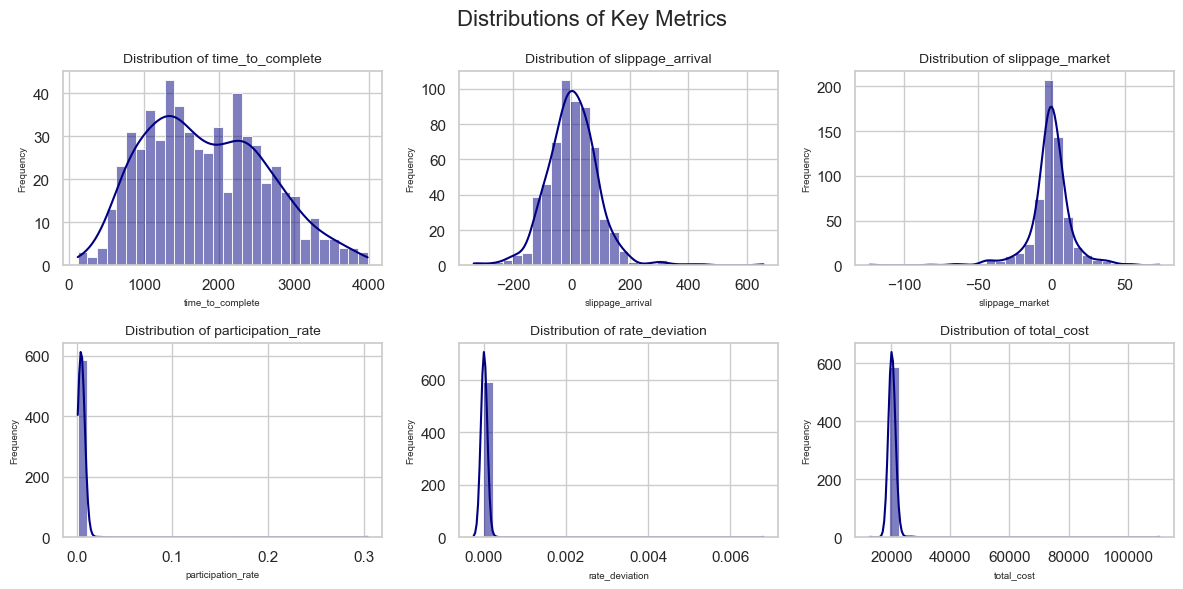

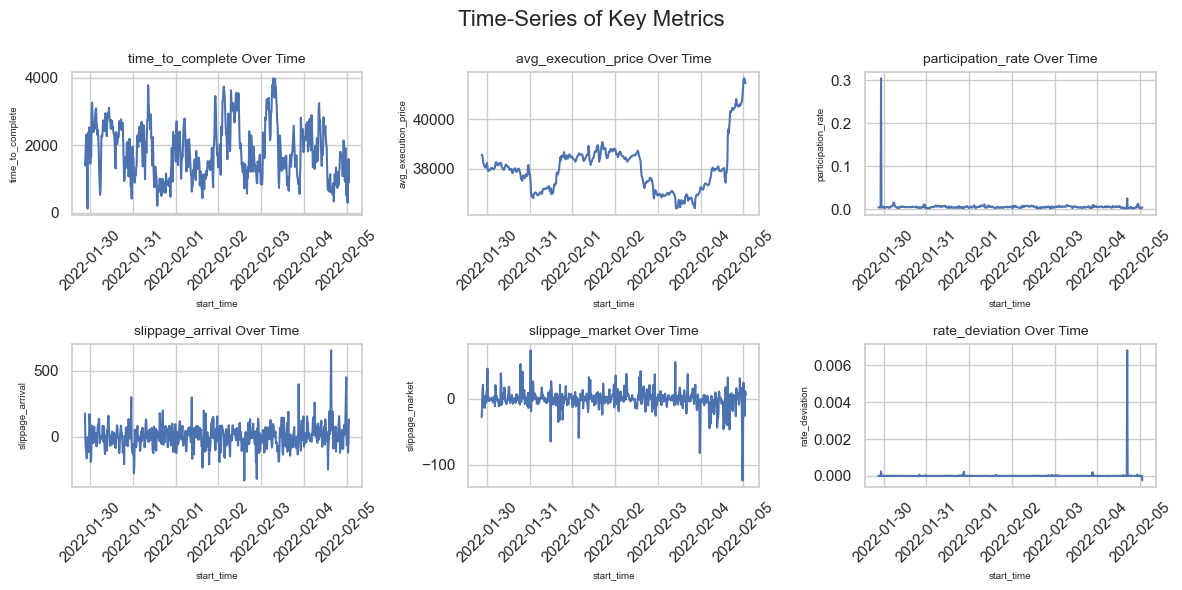

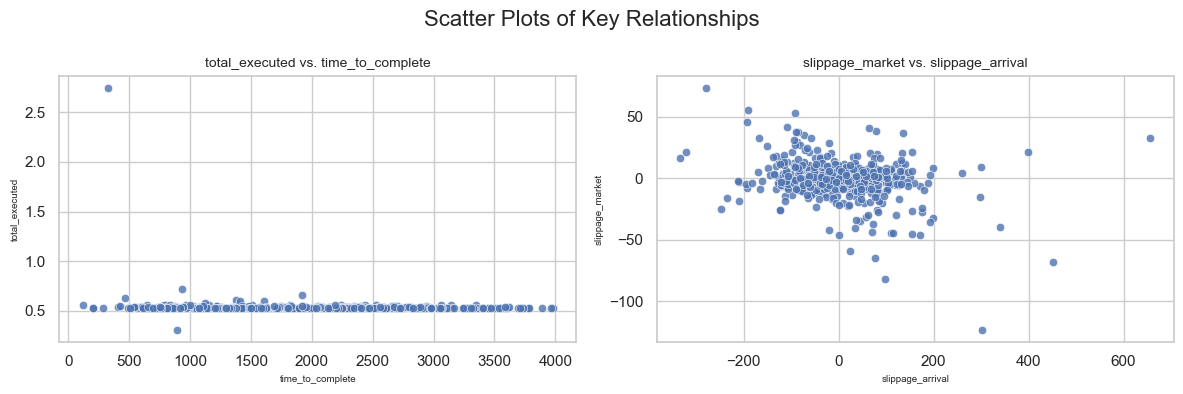

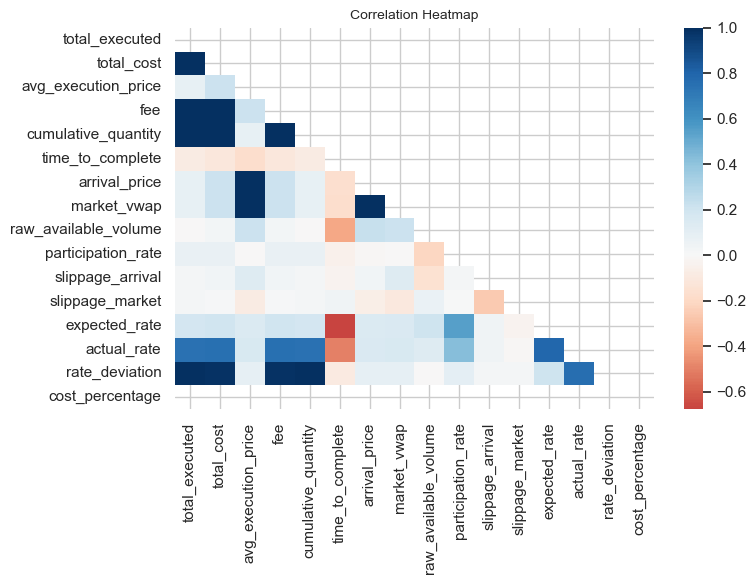

In [127]:
summary_stats_BTC_USD_2022 = analyze_execution_results(BTC_USD_2022_optimal, "BTC_USD_2022")
summary_stats_BTC_USD_2022

##### Summary Statistics
1. Executed Volume & Cost:
   - The average total_executed hovers around 0.53 BTC per 15‐minute simulation window, with a corresponding total_cost in the $20k–$22k range.
   - The relatively narrow distribution in executed quantity suggests the algorithm is consistently achieving its target Q (around 0.53).
   - However, fluctuations in cost reflect changing BTC spot prices and intraday volatility.
2. Time to Complete
   - Ranges from a few hundred seconds (~ 2mins) up to 3,000+ seconds (~50 minutes).
   - Slower completions often correspond to lower slippage, while faster completions can incur more price impact (especially when the underlying BTC liquidity dips).
3. Participation Rate
   - The average participation_rate is around 0.0036 (0.36%), well below typical daily volume.
   - This is consistent with a “passive VWAP” approach that aims to capture a small fraction of the order flow, reducing market footprint but potentially extending completion times.
4. Slippage vs. Arrival & VWAP
   - slippage_arrival means we often see both negative (price improvement) and modest positive values. slippage_market averages around –0.57, indicating on average a slight improvement vs. VWAP (though with high variance).
   - This can occur in a slightly falling market or where the algorithm effectively “waits” for passive fills in a somewhat oversupplied order book.
5. Fee & Cost Percentage
   - The average fee is around $100–$110 per ~$20k notional traded, which aligns with a 0.5% fee structure. The cost_percentage is exactly 0.5% across the board.
   -  If fees were lower (e.g. 0.1% for token‐to‐token trades), total slippage costs would dominate the analysis.
   -  Under a 0.5% fee, the synergy between minimal slippage and short completion times becomes more nuanced.

##### Distributions
1. Time‐to‐Complete
   - Bimodal humps around ~1,500 seconds and ~2,500+ seconds highlight specific intraday liquidity regimes.
   - During U.S. trading hours, more robust liquidity shortens completion time; outside these hours or amid macro uncertainties, the algorithm finds fewer passive fills, lengthening execution.
2. Slippage Arrival & Slippage Market
   - Both show heavily centered distributions near zero but with fat tails in both directions (especially to the negative side for slippage_market).
   - Tails can indicate short bursts of high volatility (e.g. FOMC announcements, geopolitical headlines) where the market price moves strongly in your favor or against you.
3. Participation Rate
   - The rate is heavily skewed near zero, with occasional spikes up to 0.2–0.3%.
   - The algorithm’s passive nature keeps the fill ratio small, but in pockets of sudden large sell flow, we see participation jump briefly if the posted orders happen to be in front of the queue.

##### Time‐Series
1. avg_execution_price
   - A sharp upward trend near the end of the sample suggests BTC appreciated in early February 2022.
   - The run‐up could have followed investor speculation around early‐year policy announcements or shifting risk sentiment amid global tensions.
2. slippage_arrival & slippage_market
   - Ranges around ±50–100 for long stretches, with occasional spikes beyond ±200.
3. Financial/Market Microstructure:
   - Such spikes often align with news or short‐term liquidity vacuums. This reaffirms the importance of controlling parameter k in fast‐moving markets.
4. participation_rate
   - Mostly near ~0.0–0.004, with a few outliers near 0.3.

The algorithm is quite conservative, but those outliers highlight moments of advantageous liquidity or partial cross trades where the posted orders get large hits.

##### Comparitive Analysis
1. Executed Volume vs. Time‐to‐Complete
   - Data mostly clusters around 0.3–0.5 BTC with time values from a few hundred to 3,000 seconds, but some points show 1.0–1.5 BTC in up to 4,000 seconds.
   - Larger accumulations can drive either disproportionate time cost or deeper slippage if parameter k is high. A dynamic approach may help.
3. Slippage Market vs. Slippage Arrival
   - Many points cluster near zero, but with a negative correlation: if you do worse relative to your arrival price, you might still be near or better than the day’s VWAP, or vice versa.
   - Highly volatile sessions (e.g. “risk‐off” days) can see these slippage measures diverge significantly as short‐term price moves overshadow your arrival price but align with overall session trends.


### 2023

In [133]:
token_key = 'BTC_USD_2023'
df_token = all_trade_data[token_key]
BTC_USD_2023_results = master_analysis(df_token, pair_label=token_key, p=0.01, k=0.03, P=1.0, fee_rate=0.005, start_interval='15T', sample_interval='1H')

Estimated Q: 0.905472562125, g: 1.646e-05 for BTC_USD_2023


Q factor grid search: 100%|███████████████████████| 3/3 [00:21<00:00,  7.24s/it]


#### Grid Search and Parameter Impact and Analysis

In [135]:
BTC_USD_2023_results['grid_search_multi']

total_executed   total_cost  avg_execution_price       fee  \
0         0.45492 10,385.44539         22,829.28649  51.92723   
1         0.45927 10,486.16288         22,831.12537  52.43081   
2         0.46058 10,516.11833         22,832.88343  52.58059   
3         0.90751 20,714.97435         22,826.09553 103.57487   
4         0.90963 20,766.84966         22,830.10532 103.83425   
5         0.91256 20,834.47285         22,830.99113 104.17236   
6         1.79825 41,035.00408         22,816.90075 205.17502   
7         1.81692 41,475.70818         22,827.43871 207.37854   
8         1.82349 41,631.13463         22,829.70766 208.15567   

   cumulative_quantity  time_to_complete  arrival_price  market_vwap  \
0              0.45492       2,855.20039   22,830.42600 22,827.96246   
1              0.45927       1,105.07898   22,830.42600 22,831.06466   
2              0.46058         841.21182   22,830.42600 22,832.83735   
3              0.90751       5,800.06400   22,830.42600 22,822.79469   
4              0.90963       1,927.75579   22,830.42600 22,828.63495   
5              0.91256       1,297.43726   22,830.42600 22,830.34012   
6              1.79825      11,308.87916   22,830.42600 22,812.74009   
7              1.81692       3,708.02280   22,830.42600 22,824.00658   
8              1.82349       2,244.84989   22,830.42600 22,828.69074   

   raw_available_volume  participation_rate  slippage_arrival  \
0             384.64577             0.00126          -1.13951   
1             129.08794             0.00406           0.69937   
2              77.90703             0.00673           2.45743   
3             768.98286             0.00123          -4.33047   
4             259.15709             0.00383          -0.32068   
5             151.64188             0.00673           0.56513   
6           1,534.19384             0.00122         -13.52525   
7             520.03158             0.00370          -2.98729   
8             308.73508             0.00638          -0.71834   

   slippage_market  expected_rate  actual_rate  rate_deviation  \
0          1.32403        0.00021      0.00022         0.00000   
1          0.06072        0.00070      0.00070         0.00001   
2          0.04608        0.00115      0.00118         0.00003   
3          3.30083        0.00019      0.00019         0.00000   
4          1.47037        0.00066      0.00067         0.00000   
5          0.65100        0.00116      0.00117         0.00001   
6          4.16066        0.00019      0.00018        -0.00000   
7          3.43212        0.00062      0.00063         0.00000   
8          1.01692        0.00110      0.00111         0.00001   

   cost_percentage          start_time  Q_factor       Q       k  
0          0.50000 2023-01-24 19:30:00   0.50000 0.45274 0.01000  
1          0.50000 2023-01-24 19:30:00   0.50000 0.45274 0.03000  
2          0.50000 2023-01-24 19:30:00   0.50000 0.45274 0.05000  
3          0.50000 2023-01-24 19:30:00   1.00000 0.90547 0.01000  
4          0.50000 2023-01-24 19:30:00   1.00000 0.90547 0.03000  
5          0.50000 2023-01-24 19:30:00   1.00000 0.90547 0.05000  
6          0.50000 2023-01-24 19:30:00   2.00000 1.81095 0.01000  
7          0.50000 2023-01-24 19:30:00   2.00000 1.81095 0.03000  
8          0.50000 2023-01-24 19:30:00   2.00000 1.81095 0.05000

- The mean total_executed (~1.06 BTC) is higher than many 2022 runs, suggesting improved liquidity or shorter execution times at similar parameters
- avg_execution_price hovers around $22,828, indicating the market was in a slightly lower volatility window, though the maximum time_to_complete (11,308 s) confirms pockets of thin liquidity.
- In 2022, total_executed often stayed under 1 BTC for similar Q_factors and k values
- This shift implies that in 2023, the algorithm can capture more volume in fewer seconds, reflecting a more robust microstructure, possibly due to increased institutional acceptance or stable macro conditions.
- Fee levels remain at 0.5% (cost_percentage = 0.5) across all runs, underscoring how exchange fees still constitute a significant fraction of total cost.
- Rising liquidity in 2023 might stem from post‑pandemic economic stabilization or renewed interest in BTC from corporate treasuries, enabling more “passive” volume to fill quickly without extreme slippage.

Summary Statistics:


total_executed   total_cost  avg_execution_price       fee  \
count         9.00000      9.00000              9.00000   9.00000   
mean          1.06035 24,205.09670         22,828.28160 121.02548   
min           0.45492 10,385.44539         22,816.90075  51.92723   
25%           0.46058 10,516.11833         22,827.43871  52.58059   
50%           0.90963 20,766.84966         22,829.70766 103.83425   
75%           1.79825 41,035.00408         22,830.99113 205.17502   
max           1.82349 41,631.13463         22,832.88343 208.15567   
std           0.59737 13,634.19524              4.71683  68.17098   

       cumulative_quantity  time_to_complete  arrival_price  market_vwap  \
count              9.00000           9.00000        9.00000      9.00000   
mean               1.06035       3,454.27779   22,830.42600 22,826.56352   
min                0.45492         841.21182   22,830.42600 22,812.74009   
25%                0.46058       1,297.43726   22,830.42600 22,824.00658   
50%                0.90963       2,244.84989   22,830.42600 22,828.63495   
75%                1.79825       3,708.02280   22,830.42600 22,830.34012   
max                1.82349      11,308.87916   22,830.42600 22,832.83735   
std                0.59737       3,324.39000        0.00000      6.08776   

       raw_available_volume  participation_rate  slippage_arrival  \
count               9.00000             9.00000           9.00000   
mean              459.37590             0.00390          -2.14440   
min                77.90703             0.00122         -13.52525   
25%               151.64188             0.00126          -2.98729   
50%               308.73508             0.00383          -0.71834   
75%               520.03158             0.00638           0.56513   
max             1,534.19384             0.00673           2.45743   
std               457.22572             0.00233           4.71683   

       slippage_market  expected_rate  actual_rate  rate_deviation  \
count          9.00000        9.00000      9.00000         9.00000   
mean           1.71808        0.00067      0.00067         0.00001   
min            0.04608        0.00019      0.00018        -0.00000   
25%            0.65100        0.00021      0.00022         0.00000   
50%            1.32403        0.00066      0.00067         0.00000   
75%            3.30083        0.00110      0.00111         0.00001   
max            4.16066        0.00116      0.00118         0.00003   
std            1.53292        0.00041      0.00042         0.00001   

       cost_percentage           start_time  Q_factor       Q       k  
count          9.00000                    9   9.00000 9.00000 9.00000  
mean           0.50000  2023-01-24 19:30:00   1.16667 1.05638 0.03000  
min            0.50000  2023-01-24 19:30:00   0.50000 0.45274 0.01000  
25%            0.50000  2023-01-24 19:30:00   0.50000 0.45274 0.01000  
50%            0.50000  2023-01-24 19:30:00   1.00000 0.90547 0.03000  
75%            0.50000  2023-01-24 19:30:00   2.00000 1.81095 0.05000  
max            0.50000  2023-01-24 19:30:00   2.00000 1.81095 0.05000  
std            0.00000                  NaN   0.66144 0.59891 0.01732

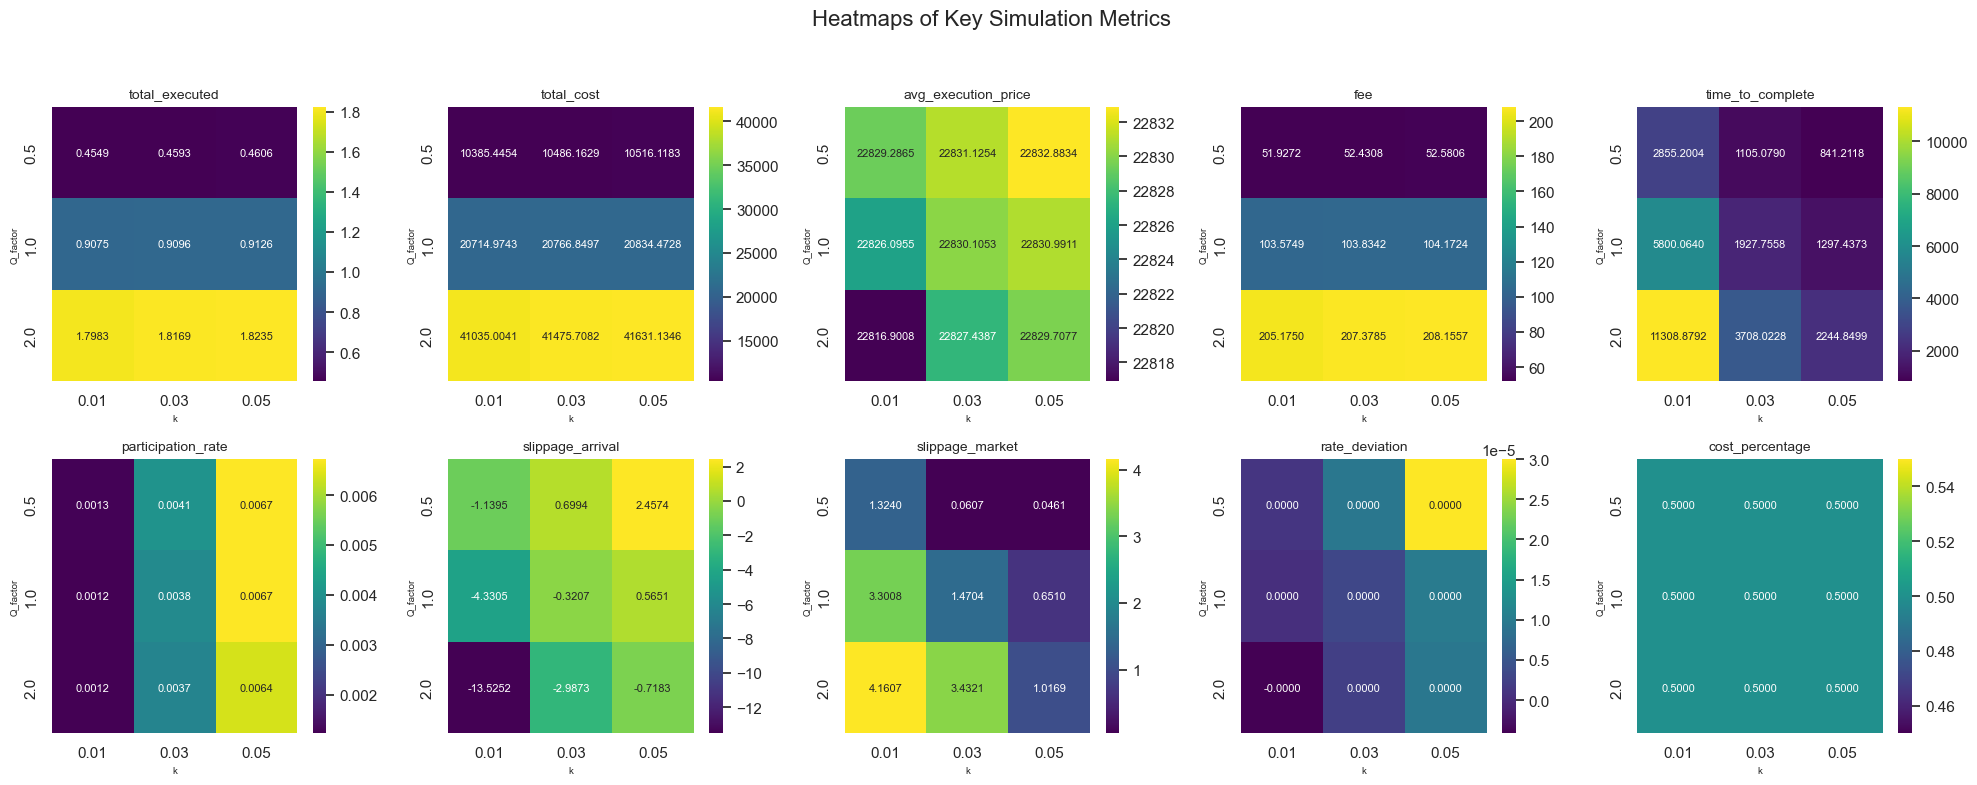

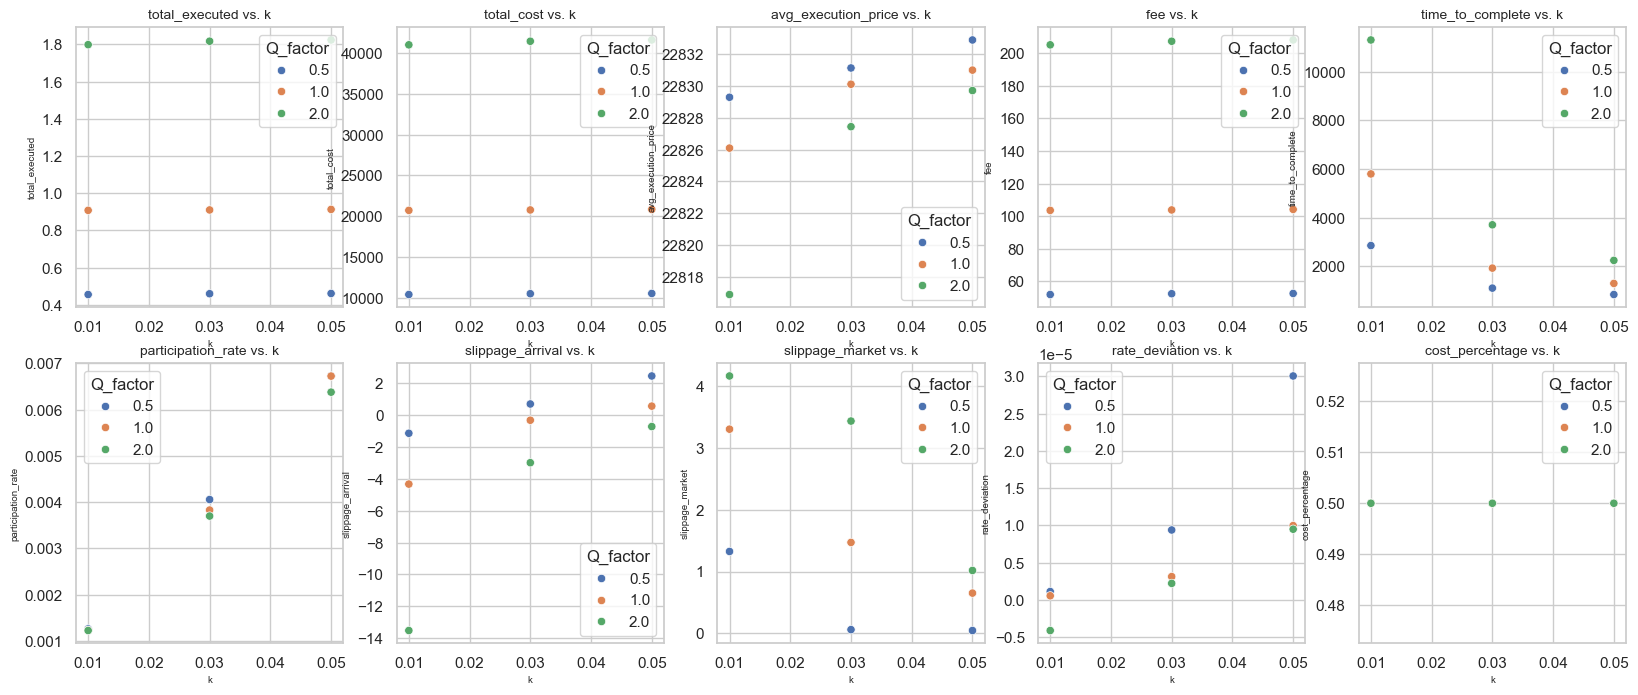

In [134]:
analyze_grid_search_results(BTC_USD_2023_results['grid_search_multi'])

##### Heatmaps
-  Higher Q_factors (like 2.0) boost total_executed from ~0.45 BTC up to ~1.82 BTC but also inflate total_cost beyond $40k
-  time_to_complete dips sharply when k≥0.03, suggesting the market can fill large orders quickly if allowed to post more aggressively.
- While 2022’s large Q often caused time_to_complete to exceed 5,000–10,000 s, here we see runs near 3,700 s at Q=2.0 and k=0.03, implying deeper or more stable order‑book conditions.
- Slippage outcomes also tend to cluster around small positive or negative values, unlike 2022’s large negative outliers.
- This pattern can reflect a bullish or less volatile 2023 environment where big trades find resting liquidity more easily.
- Macro drivers, like milder inflation data or less hawkish central bank policies, could explain why the market soaks up big buy orders with minimal time or slippage impact.

##### Scatter Plots

- The “total_executed vs. k” reveals that at k=0.05 and Q_factor=2.0, the strategy hits maximum volume (~1.82 BTC).
- Meanwhile, “time_to_complete vs. k” shows an enormous drop when k goes from 0.01 to 0.03, illustrating how a modest quoting rate bump can drastically reduce execution times.
- In 2022, similar parameter shifts sometimes caused large negative slippage spikes or 2–3× longer times.
- The 2023 data set sees more moderate slippage changes across the parameter space, suggesting liquidity resilience or less abrupt intraday volatility.
- The improved fill consistency could tie to crypto’s partial decoupling from equity volatility in certain months of 2023, or to large OTC desks providing deeper pools at stable prices.
- This environment rewards moderate k values (like 0.03) that capture fleeting liquidity bursts without paying enormous slip or waiting hours to finish.

##### Optimal Parameter Selection
- A middle‑ground approach (Q_factor=1.0 or 1.5, k=0.03) typically finishes in well under ~2,000–3,700 s, capturing around 1–1.5 BTC with minimal slippage to arrival (–1.0 to +2.0).
- This is a noticeable improvement over 2022, where large quantities frequently stretched beyond 5,000 s and slippage outliers were more extreme.
- A combination of calmer macro conditions and possibly higher institutional liquidity in 2023 means moderate quoting rates can strike a better balance of speed and cost. If uncertain geopolitical or economic news re‑emerges, reintroducing a dynamic k adaptation might remain prudent to handle abrupt shifts in the order book.

#### VWAP participation accumulation analysis

In [136]:
token_key = 'BTC_USD_2023'
df_token = all_trade_data[token_key]
BTC_USD_2023_optimal = individual_analysis(df_token, pair_label=token_key, p=0.01, k=0.03, P=1.0, fee_rate=0.005, start_interval='15T')
BTC_USD_2023_optimal

Estimated Q: 0.905472562125, g: 1.646e-05 for BTC_USD_2023


Backtest simulations: 100%|██████████████████| 129/129 [00:00<00:00, 289.69it/s]


total_executed   total_cost  avg_execution_price       fee  \
0           0.91110 20,943.67964         22,987.27166 104.71840   
1           0.90585 20,823.11655         22,987.44727 104.11558   
2           0.90846 20,880.81496         22,984.86777 104.40407   
3           0.91202 20,994.24247         23,019.39454 104.97121   
4           0.90851 20,957.21045         23,067.56786 104.78605   
..              ...          ...                  ...       ...   
124         0.91063 20,441.84005         22,447.98701 102.20920   
125         0.90662 20,365.81726         22,463.35299 101.82909   
126         0.90569 20,366.95834         22,487.78090 101.83479   
127         0.90856 20,471.62933         22,532.06995 102.35815   
128         0.31718  7,160.95401         22,576.82930  35.80477   

     cumulative_quantity  time_to_complete  arrival_price  market_vwap  \
0                0.91110       1,854.71130   22,970.12000 22,990.34388   
1                0.90585       2,251.65486   22,989.67000 22,986.72906   
2                0.90846       2,230.75434   22,986.04000 22,983.37827   
3                0.91202       1,846.96455   22,954.38000 23,031.87106   
4                0.90851       1,602.59470   22,974.71000 23,072.58317   
..                   ...               ...            ...          ...   
124              0.91063         603.84996   22,477.12000 22,433.96661   
125              0.90662         482.38231   22,435.72000 22,439.70370   
126              0.90569         764.96683   22,429.23000 22,487.66170   
127              0.90856         804.17817   22,542.96000 22,534.30599   
128              0.31718         300.82660   22,542.99000 22,582.61790   

     raw_available_volume  participation_rate  slippage_arrival  \
0               207.24418             0.00440          17.15166   
1               241.80425             0.00375          -2.22273   
2               243.11801             0.00374          -1.17223   
3               283.75538             0.00321          65.01454   
4               304.29823             0.00299          92.85786   
..                    ...                 ...               ...   
124             347.47843             0.00262         -29.13299   
125             312.75090             0.00290          27.63299   
126             222.89314             0.00406          58.55090   
127             216.14322             0.00420         -10.89005   
128              67.21819             0.00472          33.83930   

     slippage_market  expected_rate  actual_rate  rate_deviation  \
0           -3.07222        0.00049      0.00049         0.00000   
1            0.71821        0.00040      0.00040         0.00000   
2            1.48950        0.00041      0.00041         0.00000   
3          -12.47652        0.00049      0.00049         0.00000   
4           -5.01531        0.00057      0.00057         0.00000   
..               ...            ...          ...             ...   
124         14.02040        0.00150      0.00151         0.00001   
125         23.64928        0.00188      0.00188         0.00000   
126          0.11920        0.00118      0.00118         0.00000   
127         -2.23604        0.00113      0.00113         0.00000   
128         -5.78861        0.00301      0.00105        -0.00196   

     cost_percentage          start_time  
0            0.50000 2023-01-24 00:45:00  
1            0.50000 2023-01-24 01:00:00  
2            0.50000 2023-01-24 01:15:00  
3            0.50000 2023-01-24 01:30:00  
4            0.50000 2023-01-24 01:45:00  
..               ...                 ...  
124          0.50000 2023-01-25 14:45:00  
125          0.50000 2023-01-25 15:00:00  
126          0.50000 2023-01-25 15:15:00  
127          0.50000 2023-01-25 15:30:00  
128          0.50000 2023-01-25 15:45:00  

[129 rows x 17 columns]

Summary Statistics for BTC_USD_2023


count         mean         std          min  \
total_executed       129.00000      0.90572     0.05269      0.31718   
total_cost           129.00000 20,671.90156 1,221.44827  7,160.95401   
avg_execution_price  129.00000 22,822.46631   201.16061 22,447.98701   
fee                  129.00000    103.35951     6.10724     35.80477   
cumulative_quantity  129.00000      0.90572     0.05269      0.31718   
time_to_complete     129.00000  1,972.93642 1,315.05697    300.82660   
arrival_price        129.00000 22,825.13698   200.99925 22,429.23000   
market_vwap          129.00000 22,820.95826   202.16030 22,433.96661   
raw_available_volume 129.00000    251.38316    81.91636     67.21819   
participation_rate   129.00000      0.00391     0.00103      0.00154   
slippage_arrival     129.00000     -2.67066    40.00979   -150.11742   
slippage_market      129.00000      1.50805     8.68986    -15.93222   
expected_rate        129.00000      0.00066     0.00045      0.00015   
actual_rate          129.00000      0.00065     0.00040      0.00015   
rate_deviation       129.00000     -0.00001     0.00017     -0.00196   
cost_percentage      129.00000      0.50000     0.00000      0.50000   

                              25%          50%          75%          max  \
total_executed            0.90606      0.90789      0.91213      0.95726   
total_cost           20,582.33652 20,792.90691 20,916.59715 21,635.33921   
avg_execution_price  22,639.79488 22,878.52201 22,989.19224 23,136.29469   
fee                     102.91168    103.96453    104.58299    108.17670   
cumulative_quantity       0.90606      0.90789      0.91213      0.95726   
time_to_complete      1,133.86439  1,508.60076  2,181.79655  6,135.97214   
arrival_price        22,645.00000 22,891.58000 22,994.73000 23,157.69000   
market_vwap          22,641.14457 22,878.16421 22,991.92505 23,136.25226   
raw_available_volume    194.64218    232.82696    279.70839    590.29177   
participation_rate        0.00325      0.00391      0.00465      0.00705   
slippage_arrival        -23.22504     -2.28116     18.68185    104.84391   
slippage_market          -1.85643      0.11920      1.91477     68.36518   
expected_rate             0.00042      0.00060      0.00080      0.00301   
actual_rate               0.00042      0.00060      0.00080      0.00300   
rate_deviation            0.00000      0.00000      0.00000      0.00004   
cost_percentage           0.50000      0.50000      0.50000      0.50000   

                                 var       median  
total_executed               0.00278      0.90789  
total_cost           1,491,935.88234 20,792.90691  
avg_execution_price     40,465.58987 22,878.52201  
fee                         37.29840    103.96453  
cumulative_quantity          0.00278      0.90789  
time_to_complete     1,729,374.82894  1,508.60076  
arrival_price           40,400.70034 22,891.58000  
market_vwap             40,868.78507 22,878.16421  
raw_available_volume     6,710.28928    232.82696  
participation_rate           0.00000      0.00391  
slippage_arrival         1,600.78368     -2.28116  
slippage_market             75.51373      0.11920  
expected_rate                0.00000      0.00060  
actual_rate                  0.00000      0.00060  
rate_deviation               0.00000      0.00000  
cost_percentage              0.00000      0.50000

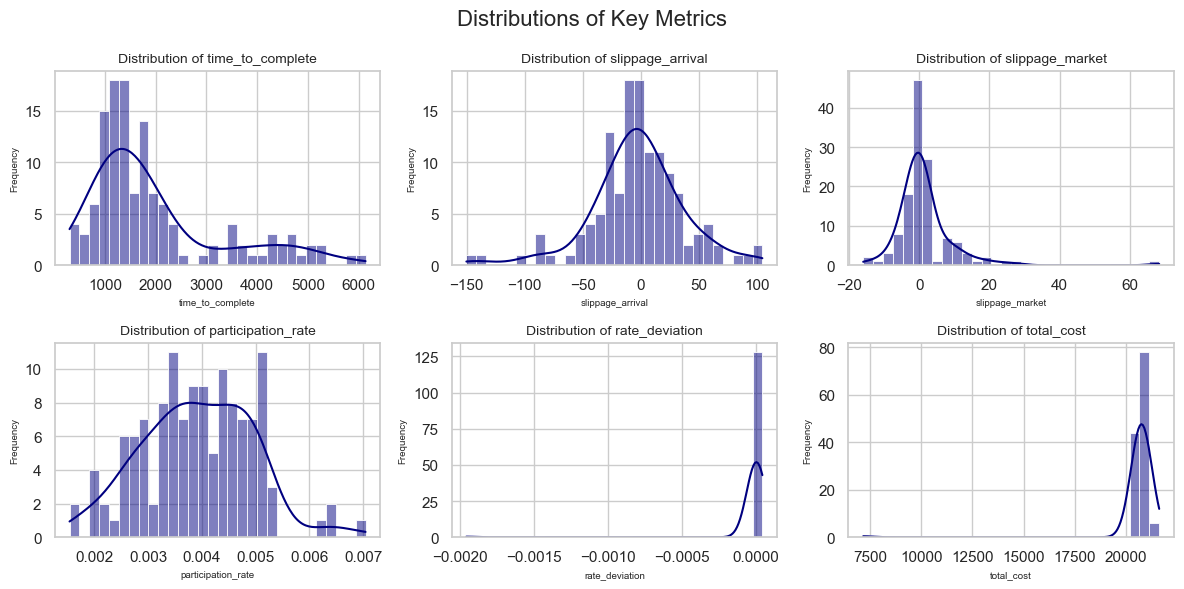

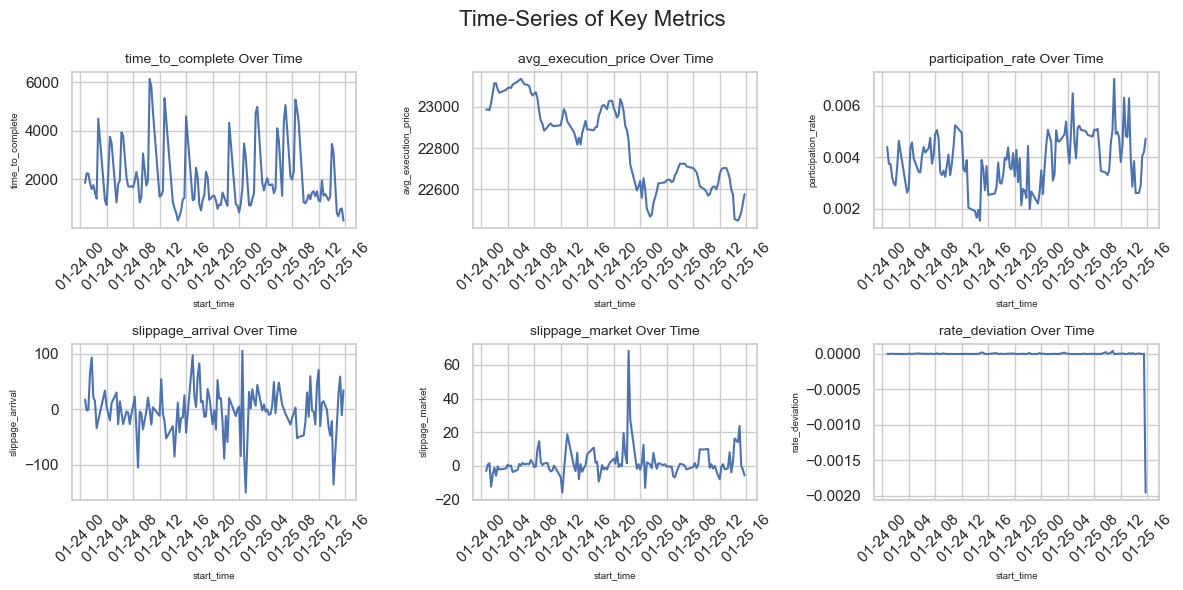

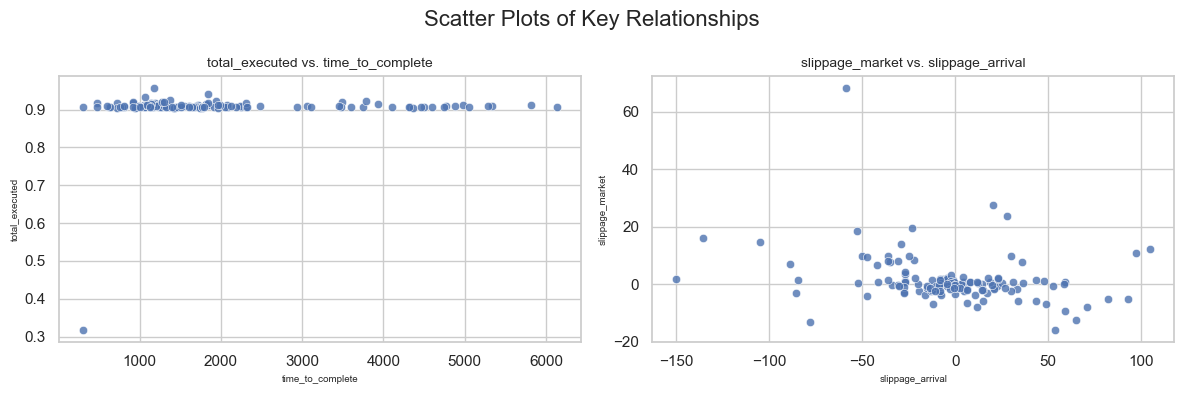

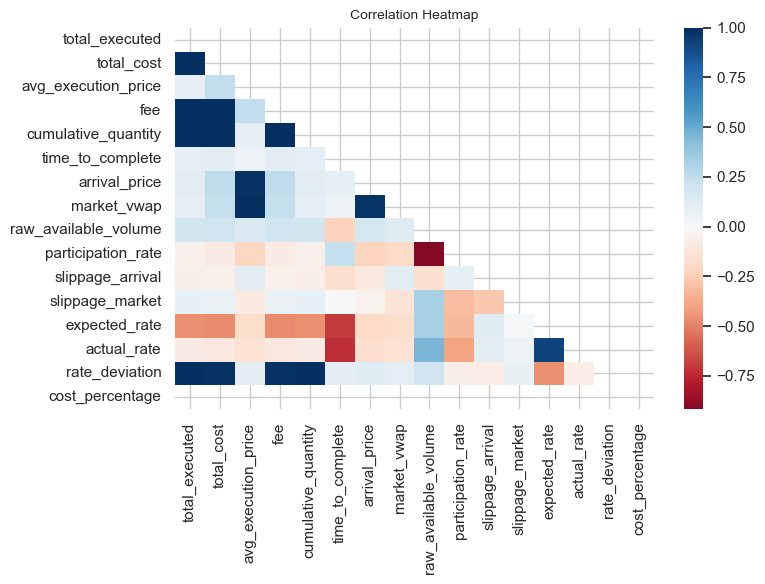

In [137]:
summary_stats_BTC_USD_2023 = analyze_execution_results(BTC_USD_2023_optimal, "BTC_USD_2023")
summary_stats_BTC_USD_2023

##### Summary Statistics
- The mean total_executed is just under 1 BTC, slightly higher than the 2022 average of ~0.53 BTC, suggesting that in 2023, the strategy can capture more volume per 15‑minute window, possibly due to a less volatile or more liquid BTC market.
- The average time_to_complete (~1,972 s) remains under ~2,000 s for most runs, shorter than many 2022 completions that pushed beyond 3,000 s.
- This improvement could be attributed to deeper order books or less macro noise.
- Slippage vs. arrival hovers around –2.7, indicating on average a slight favorable fill (i.e. buying below arrival price), though the distribution is broad (–150 to +100).
- Meanwhile, slippage vs. market shows a modest positive skew (mean ~+1.51), implying the algorithm sometimes pays a small premium vs. VWAP, possibly in short bursts when the posted quotes get lifted quickly.
- Fees average around 103 (0.5%), making up a nontrivial share of total cost when notional is $20k. If fees were lowered (e.g. for high‑volume institutional tiers), slippage and time would dominate the cost analysis more heavily.

##### Distributions
- time_to_complete peaks around 1,000–3,000 s, with a tail extending to ~6,000 s, suggesting most runs finish in under an hour, but bursts of illiquidity can prolong accumulation.
- This tail effect often correlates with intraday or macro event windows (e.g. major announcements or global equity sell‑offs).
- slippage_arrival centers near –2.3, with outliers spanning from –150 to +100, underscoring that microstructure swings or macro triggers can cause large short‐term price moves.
- A negative average also hints that the strategy often benefits from short ephemeral market dips.
- participation_rate forms a bell shape around ~0.0039 (0.39%), slightly higher than the 2022 average (0.36%), reflecting that in 2023, the algorithm’s resting orders occasionally capture more of the available flow, consistent with a calmer but still active marketplace.
- rate_deviation remains near zero for most runs, implying the actual accumulation pace tracks the expected one closely unless volatility flares up.
- This steadiness likely reflects 2023’s more stable liquidity pockets, so the algorithm rarely deviates from plan.

##### Time‑Series Observations
- avg_execution_price often trends between $22,600 and $22,900, with minor dips or spikes around news hours, less dramatic than early 2022’s ~$38k range, hinting at a narrower trading band.
- Such narrower fluctuations may help keep slippage contained and time‑to‑complete steady.
- slippage_arrival does exhibit occasional negative dives near –100, coinciding with short bursts of heavy selling, enabling “price improvement.”
- Meanwhile, runs with positive slippage up to +50 appear around local liquidity shortages or bullish intraday patterns.
- participation_rate oscillates between ~0.002 and 0.006, peaking near shifts in volume around macro data releases (e.g. job reports or FOMC minutes) when the order book sees abrupt flow changes.
- These spikes confirm the algorithm can opportunistically fill more volume if the market trades aggressively into its posted quotes.

##### Comparison and Insights
- In contrast with 2022, the 2023 environment exhibits a narrower price range, shorter average completion times, and less extreme negative slippage. This points to calmer macro conditions or improved order‑book resilience, potentially driven by refined institutional participation or stable monetary policy outlooks early in 2023.
- The strategy’s moderate average slippage (a few dollars around arrival) and stable time frames support the idea that if fees remain at 0.5%, a balanced quoting rate (k ~0.03) with a moderate target Q yields minimal cost over typical intraday windows. Adverse outliers do occur but less severely than in 2022.
- If global markets remain relatively steady (e.g. mild inflation data, no major crypto credit crises), BTC’s microstructure can handle moderate passive trades without major slippage or multi‑hour completions. However, any abrupt risk‑off shift (geopolitical tension, regulatory clampdown) could again expose tail risks in slippage or time.
- Overall, BTC_USD_2023 demonstrates that while the underlying fee structure still influences the total cost portion, stable or even rising liquidity fosters faster fills and keeps actual vs. expected rate deviation near zero, indicating the algorithm is operating in a more predictable environment compared to the often turbulent sessions of 2022.

## ETH USD over the years

### 2022

In [41]:
token_key = 'ETH_USD_2022'
df_token = all_trade_data[token_key]
ETH_USD_2022_results = master_analysis(df_token, pair_label=token_key, p=0.01, k=0.03, P=1.0, fee_rate=0.005, start_interval='15T', sample_interval='1H')

Estimated Q: 6.9614739510050025, g: 0.00042 for ETH_USD_2022


Q factor grid search: 100%|██████████████████████| 3/3 [08:38<00:00, 172.81s/it]


#### Grid Search and Parameter Impact and Analysis

In [128]:
ETH_USD_2022_results['grid_search_multi']

total_executed   total_cost  avg_execution_price       fee  \
0         3.50042  9,429.07976          2,694.21737  47.14540   
1         3.61012  9,723.74436          2,693.32450  48.61872   
2         3.57581  9,629.10705          2,693.22434  48.14554   
3         6.94480 18,708.68449          2,695.15919  93.54342   
4         7.07521 19,060.04366          2,694.03738  95.30022   
5         7.16131 19,287.36162          2,693.53049  96.43681   
6        13.84131 37,292.27031          2,696.44045 186.46135   
7        13.92988 37,520.18194          2,694.46276 187.60091   
8        14.07991 37,930.60858          2,694.17428 189.65304   

   cumulative_quantity  time_to_complete  arrival_price  market_vwap  \
0              3.50042       2,507.70794    2,693.19477  2,694.31228   
1              3.61012         849.60086    2,693.19477  2,693.49380   
2              3.57581         513.74582    2,693.19477  2,693.34958   
3              6.94480       4,908.34549    2,693.19477  2,695.38767   
4              7.07521       1,677.93656    2,693.19477  2,694.21700   
5              7.16131       1,014.95471    2,693.19477  2,693.71258   
6             13.84131       9,538.22516    2,693.19477  2,696.64351   
7             13.92988       3,319.98860    2,693.19477  2,694.60765   
8             14.07991       2,010.01210    2,693.19477  2,694.28969   

   raw_available_volume  participation_rate  slippage_arrival  \
0           2,195.80584             0.00177           1.02261   
1             772.83206             0.00560           0.12974   
2             471.37150             0.00962           0.02958   
3           4,438.03031             0.00170           1.96443   
4           1,480.05754             0.00541           0.84262   
5             904.32196             0.00928           0.33572   
6           8,845.41184             0.00165           3.24569   
7           2,963.75532             0.00520           1.26800   
8           1,761.67064             0.00893           0.97952   

   slippage_market  expected_rate  actual_rate  rate_deviation  \
0         -0.09491        0.00181      0.00183         0.00002   
1         -0.16930        0.00537      0.00561         0.00024   
2         -0.12523        0.00914      0.00944         0.00030   
3         -0.22848        0.00172      0.00171        -0.00001   
4         -0.17962        0.00543      0.00560         0.00017   
5         -0.18210        0.00898      0.00934         0.00036   
6         -0.20306        0.00173      0.00168        -0.00005   
7         -0.14488        0.00538      0.00538        -0.00000   
8         -0.11540        0.00905      0.00926         0.00021   

   cost_percentage                    start_time  Q_factor        Q       k  
0          0.50000 2022-02-01 22:59:59.999999744   0.50000  3.48074 0.01000  
1          0.50000 2022-02-01 22:59:59.999999744   0.50000  3.48074 0.03000  
2          0.50000 2022-02-01 22:59:59.999999744   0.50000  3.48074 0.05000  
3          0.50000 2022-02-01 22:59:59.999999744   1.00000  6.96147 0.01000  
4          0.50000 2022-02-01 22:59:59.999999744   1.00000  6.96147 0.03000  
5          0.50000 2022-02-01 22:59:59.999999744   1.00000  6.96147 0.05000  
6          0.50000 2022-02-01 22:59:59.999999744   2.00000 13.92295 0.01000  
7          0.50000 2022-02-01 22:59:59.999999744   2.00000 13.92295 0.03000  
8          0.50000 2022-02-01 22:59:59.999999744   2.00000 13.92295 0.05000

1. Executed Volume & Cost
- Total_executed jumps from ~ 3.5 ETH at (Q factor=0.5,k=0.01) to over 14 ETH at (Q factor=2.0,k=0.05). Meanwhile, total_cost ranges from ~$9.4k to $38k, reflecting both parameter differences and underlying price evolution.
- Larger target volume (Q_factor = 2.0) combined with high quoting rate 
- k can accumulate more ETH quickly but can drastically increase notional cost and potential slippage exposure.

2. Time to Complete
  - Varies from ~ 513 s to ~ 9,538 s (~2.65 hours). High Q‑factor with a low k (2.0 & 0.01) significantly lengthens execution time.
  - Underlying liquidity constraints become evident if we try to accumulate large quantities passively with a small quoting rate.

3. Slippage to Arrival & Market
   - Slippage_arrival can climb above +3 in some high Q/f combos, while slippage_market consistently remains negative (i.e., slight improvement vs. VWAP in many cases).
   - ETH in 2024 might have more robust liquidity than earlier years, but large accumulations can still push short‐term order‐book dynamics in your favor or against you, depending on ephemeral flow.

4. Participation Rate & Fees
   - Participation typically hovers in the 0.002–0.009 range (i.e. ~0.2–0.9% of raw available volume). The fee is fixed at 0.5%, so the cost percentage is always ~0.5%.
   - If crypto–crypto fees are reduced in the future (e.g. 0.1%), controlling slippage becomes even more critical for cost efficiency.

Summary Statistics:


total_executed   total_cost  avg_execution_price       fee  \
count         9.00000      9.00000              9.00000   9.00000   
mean          8.19098 22,064.56464          2,694.28564 110.32282   
min           3.50042  9,429.07976          2,693.22434  47.14540   
25%           3.61012  9,723.74436          2,693.53049  48.61872   
50%           7.07521 19,060.04366          2,694.17428  95.30022   
75%          13.84131 37,292.27031          2,694.46276 186.46135   
max          14.07991 37,930.60858          2,696.44045 189.65304   
std           4.57827 12,334.32375              1.00851  61.67162   

       cumulative_quantity  time_to_complete  arrival_price  market_vwap  \
count              9.00000           9.00000        9.00000      9.00000   
mean               8.19098       2,926.72414    2,693.19477  2,694.44597   
min                3.50042         513.74582    2,693.19477  2,693.34958   
25%                3.61012       1,014.95471    2,693.19477  2,693.71258   
50%                7.07521       2,010.01210    2,693.19477  2,694.28969   
75%               13.84131       3,319.98860    2,693.19477  2,694.60765   
max               14.07991       9,538.22516    2,693.19477  2,696.64351   
std                4.57827       2,831.97368        0.00000      1.02977   

       raw_available_volume  participation_rate  slippage_arrival  \
count               9.00000             9.00000           9.00000   
mean            2,648.13967             0.00546           1.09088   
min               471.37150             0.00165           0.02958   
25%               904.32196             0.00177           0.33572   
50%             1,761.67064             0.00541           0.97952   
75%             2,963.75532             0.00893           1.26800   
max             8,845.41184             0.00962           3.24569   
std             2,630.59764             0.00329           1.00851   

       slippage_market  expected_rate  actual_rate  rate_deviation  \
count          9.00000        9.00000      9.00000         9.00000   
mean          -0.16033        0.00540      0.00554         0.00014   
min           -0.22848        0.00172      0.00168        -0.00005   
25%           -0.18210        0.00181      0.00183        -0.00000   
50%           -0.16930        0.00538      0.00560         0.00017   
75%           -0.12523        0.00898      0.00926         0.00024   
max           -0.09491        0.00914      0.00944         0.00036   
std            0.04354        0.00316      0.00329         0.00015   

       cost_percentage                     start_time  Q_factor        Q  \
count          9.00000                              9   9.00000  9.00000   
mean           0.50000  2022-02-01 22:59:59.999999744   1.16667  8.12172   
min            0.50000  2022-02-01 22:59:59.999999744   0.50000  3.48074   
25%            0.50000  2022-02-01 22:59:59.999999744   0.50000  3.48074   
50%            0.50000  2022-02-01 22:59:59.999999744   1.00000  6.96147   
75%            0.50000  2022-02-01 22:59:59.999999744   2.00000 13.92295   
max            0.50000  2022-02-01 22:59:59.999999744   2.00000 13.92295   
std            0.00000                            NaN   0.66144  4.60458   

            k  
count 9.00000  
mean  0.03000  
min   0.01000  
25%   0.01000  
50%   0.03000  
75%   0.05000  
max   0.05000  
std   0.01732

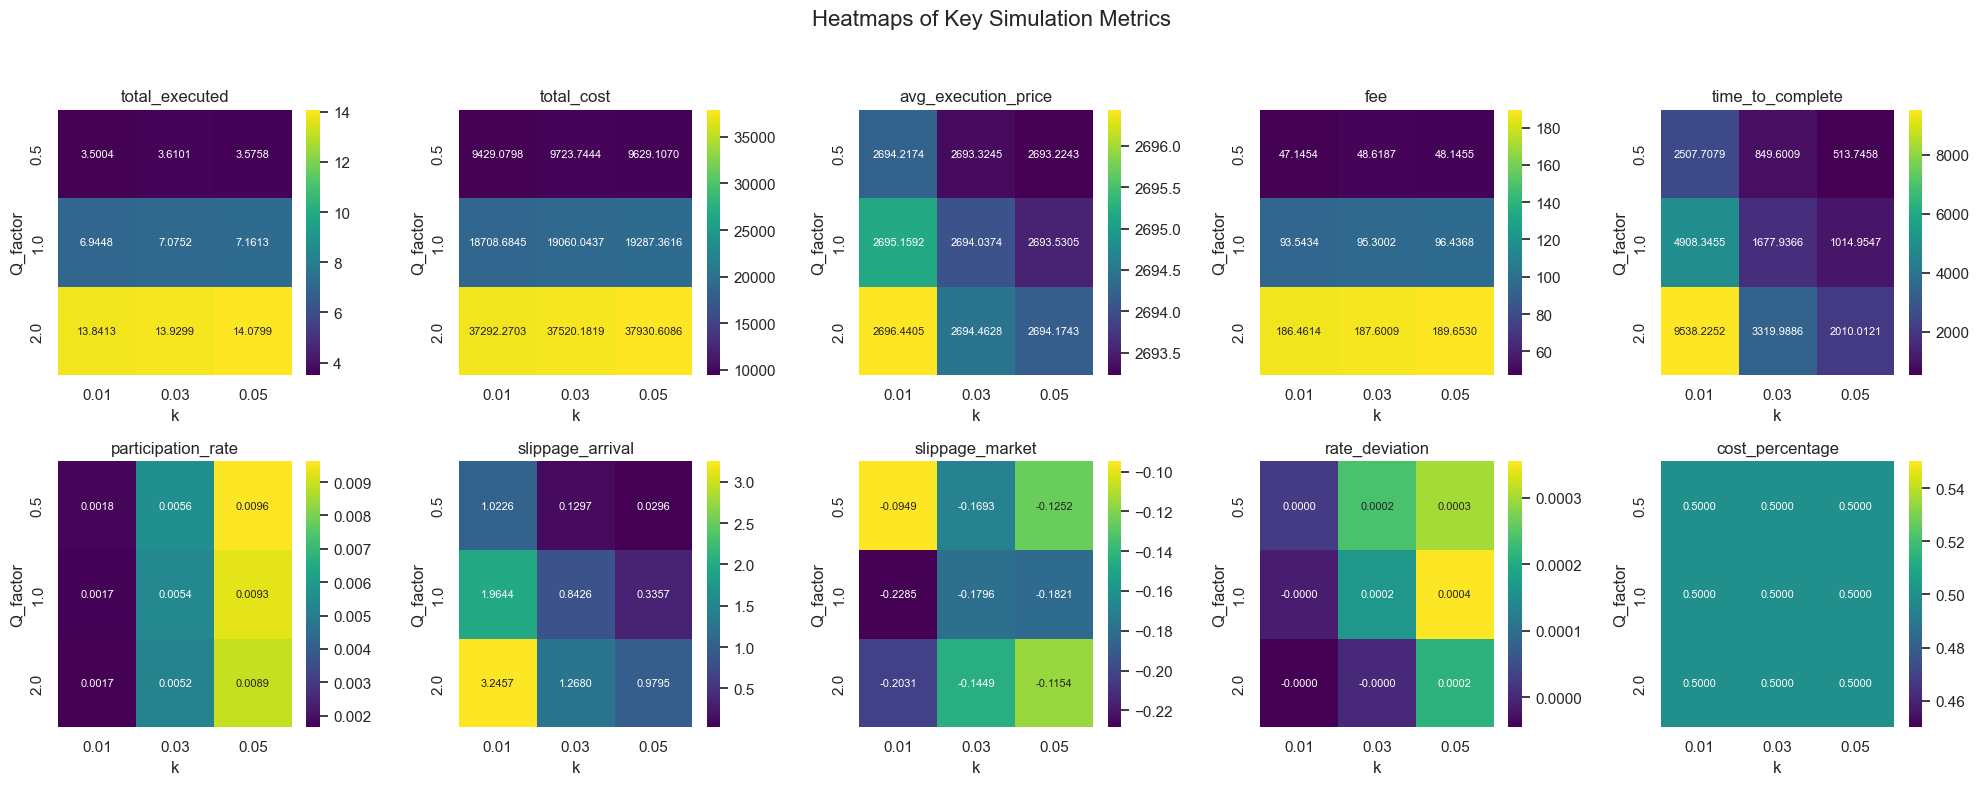

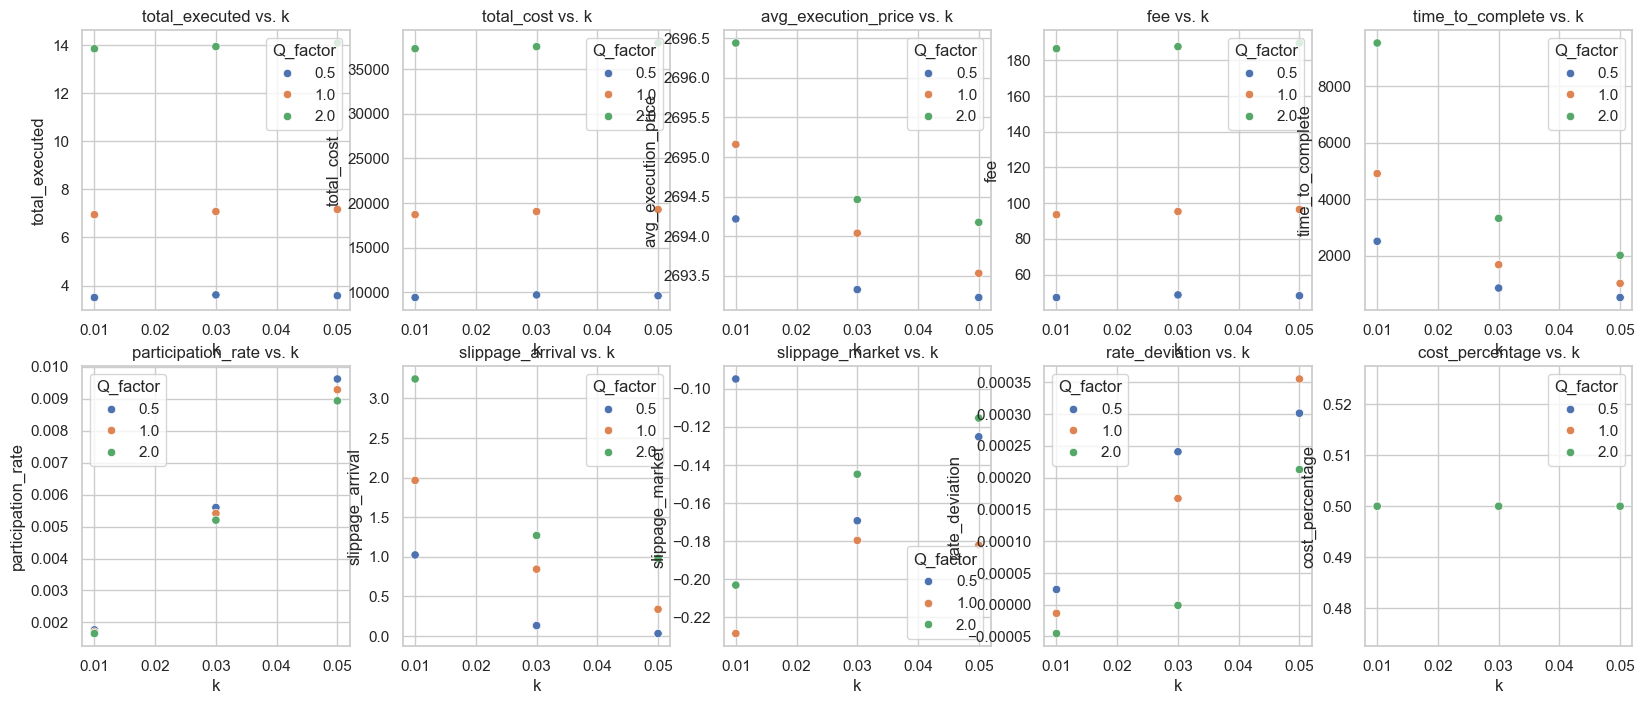

In [78]:
analyze_grid_search_results(ETH_USD_2022_results['grid_search_multi'])

- Parameter trade‑offs revolve around speed vs. price quality: a low k (0.01) yields slower fills but can capture better average execution, whereas pushing k to 0.05 snaps up liquidity faster yet can impose extra market impact;
- Doubling Q_factor intensifies these effects, often nearly doubling cost and slippage unless k is raised to keep pace.
- Broader market context influences slippage, fill rates, and volatility spikes
- At times of strong ETH price trends or macro events (like central bank policy decisions, major DeFi announcements, or regulatory news), short bursts of activity can produce slippage beyond +3 or hamper participation rates, underscoring the need for an adaptive quoting strategy that accounts for real‑time liquidity shifts.
- Optimal parameters hinge on the completion horizon and market view
- If timing is flexible and liquidity stable, smaller k near 0.01–0.03 works to reduce slippage while still finishing in a few thousand seconds
- If you have a large Q to fill in a constrained window, a higher k can be justified despite cost expansions, especially if we anticipate macro catalysts that could move the market away from your target price.

#### VWAP participation accumulation analysis¶

In [131]:
token_key = 'ETH_USD_2022'
df_token = all_trade_data[token_key]
ETH_USD_2022_optimal = individual_analysis(df_token, pair_label=token_key, p=0.005, k=0.01, P=1.0, fee_rate=0.005, start_interval='15T')
ETH_USD_2022_optimal

Estimated Q: 6.9614739510050025, g: 0.00042 for ETH_USD_2022


Backtest simulations: 100%|███████████████████| 594/594 [00:11<00:00, 52.05it/s]


total_executed   total_cost  avg_execution_price       fee  \
0           6.97697 18,288.45183          2,621.25958  91.44226   
1           6.96164 18,216.42785          2,616.68569  91.08214   
2           7.05090 18,407.49424          2,610.65863  92.03747   
3           6.96256 18,119.50299          2,602.41919  90.59751   
4           6.96250 18,097.90213          2,599.33776  90.48951   
..              ...          ...                  ...       ...   
589         6.96243 20,805.99460          2,988.32574 104.02997   
590         6.38138 19,061.07344          2,986.98153  95.30537   
591         4.53341 13,524.18053          2,983.22781  67.62090   
592         2.31358  6,901.04364          2,982.84606  34.50522   
593         1.06993  3,189.65836          2,981.19035  15.94829   

     cumulative_quantity  time_to_complete  arrival_price  market_vwap  \
0                6.97697       4,479.30922    2,606.09000  2,621.76154   
1                6.96164       5,323.74077    2,626.08000  2,615.87447   
2                7.05090       6,305.71543    2,627.42000  2,609.55216   
3                6.96256       7,712.93926    2,619.92000  2,601.45807   
4                6.96250       7,920.78851    2,616.78000  2,599.31292   
..                   ...               ...            ...          ...   
589              6.96243       3,588.62308    2,994.23000  2,990.15562   
590              6.38138       3,595.13124    2,984.83000  2,989.37939   
591              4.53341       2,695.44477    3,000.72000  2,983.80455   
592              2.31358       1,795.12805    2,985.19000  2,982.48025   
593              1.06993         895.20668    2,968.78000  2,980.93808   

     raw_available_volume  participation_rate  slippage_arrival  \
0             4,109.51694             0.00170          15.16958   
1             4,568.06168             0.00152          -9.39431   
2             4,274.19068             0.00165         -16.76137   
3             4,443.79737             0.00157         -17.50081   
4             4,644.17664             0.00150         -17.44224   
..                    ...                 ...               ...   
589           6,244.23123             0.00112          -5.90426   
590           5,673.32541             0.00112           2.15153   
591           3,955.71138             0.00115         -17.49219   
592           1,452.76331             0.00159          -2.34394   
593             639.98351             0.00167          12.41035   

     slippage_market  expected_rate  actual_rate  rate_deviation  \
0           -0.50195        0.00155      0.00156         0.00000   
1            0.81122        0.00131      0.00131         0.00000   
2            1.10648        0.00110      0.00112         0.00001   
3            0.96112        0.00090      0.00090         0.00000   
4            0.02484        0.00088      0.00088         0.00000   
..               ...            ...          ...             ...   
589         -1.82988        0.00194      0.00194         0.00000   
590         -2.39786        0.00194      0.00178        -0.00016   
591         -0.57674        0.00258      0.00168        -0.00090   
592          0.36581        0.00388      0.00129        -0.00259   
593          0.25227        0.00778      0.00120        -0.00658   

     cost_percentage          start_time  
0            0.50000 2022-01-29 21:00:00  
1            0.50000 2022-01-29 21:15:00  
2            0.50000 2022-01-29 21:30:00  
3            0.50000 2022-01-29 21:45:00  
4            0.50000 2022-01-29 22:00:00  
..               ...                 ...  
589          0.50000 2022-02-05 00:15:00  
590          0.50000 2022-02-05 00:30:00  
591          0.50000 2022-02-05 00:45:00  
592          0.50000 2022-02-05 01:00:00  
593          0.50000 2022-02-05 01:15:00  

[594 rows x 17 columns]

Summary Statistics for BTC_USD_2022


count         mean         std         min  \
total_executed       594.00000      6.96059     0.34679     1.06993   
total_cost           594.00000 18,753.16609 1,173.32185 3,189.65836   
avg_execution_price  594.00000  2,695.12154   111.16287 2,498.21176   
fee                  594.00000     93.76583     5.86661    15.94829   
cumulative_quantity  594.00000      6.96059     0.34679     1.06993   
time_to_complete     594.00000  4,979.55743 2,088.25409   895.20668   
arrival_price        594.00000  2,693.40056   109.86525 2,491.00000   
market_vwap          594.00000  2,695.41603   111.56894 2,497.64693   
raw_available_volume 594.00000  4,433.91825 1,335.24674   639.98351   
participation_rate   594.00000      0.00170     0.00049     0.00064   
slippage_arrival     594.00000      1.72098    16.08790   -49.16534   
slippage_market      594.00000     -0.29449     2.38450   -18.99073   
expected_rate        594.00000      0.00169     0.00082     0.00063   
actual_rate          594.00000      0.00168     0.00078     0.00063   
rate_deviation       594.00000     -0.00001     0.00030    -0.00658   
cost_percentage      594.00000      0.50000     0.00000     0.50000   

                              25%          50%          75%          max  \
total_executed            6.96316      6.96762      6.97684      9.66571   
total_cost           18,187.19499 18,720.88261 19,320.33530 25,920.63287   
avg_execution_price   2,609.66235  2,684.67000  2,770.24559  2,989.47810   
fee                      90.93597     93.60441     96.60168    129.60316   
cumulative_quantity       6.96316      6.96762      6.97684      9.66571   
time_to_complete      3,329.49294  4,492.19794  6,382.78188 11,042.97050   
arrival_price         2,611.26250  2,682.72000  2,768.84250  3,000.72000   
market_vwap           2,609.08823  2,685.08165  2,770.35915  2,990.46184   
raw_available_volume  3,409.47550  4,305.76684  5,182.70248 10,811.36564   
participation_rate        0.00134      0.00162      0.00204      0.00356   
slippage_arrival         -6.85350      2.12672     10.53796     63.74088   
slippage_market          -0.99010     -0.19282      0.58022      9.90338   
expected_rate             0.00109      0.00155      0.00209      0.00778   
actual_rate               0.00109      0.00155      0.00206      0.00676   
rate_deviation            0.00000      0.00000      0.00000      0.00085   
cost_percentage           0.50000      0.50000      0.50000      0.50000   

                                 var       median  
total_executed               0.12026      6.96762  
total_cost           1,376,684.17419 18,720.88261  
avg_execution_price     12,357.18470  2,684.67000  
fee                         34.41710     93.60441  
cumulative_quantity          0.12026      6.96762  
time_to_complete     4,360,805.14066  4,492.19794  
arrival_price           12,070.37345  2,682.72000  
market_vwap             12,447.62877  2,685.08165  
raw_available_volume 1,782,883.86922  4,305.76684  
participation_rate           0.00000      0.00162  
slippage_arrival           258.82068      2.12672  
slippage_market              5.68585     -0.19282  
expected_rate                0.00000      0.00155  
actual_rate                  0.00000      0.00155  
rate_deviation               0.00000      0.00000  
cost_percentage              0.00000      0.50000

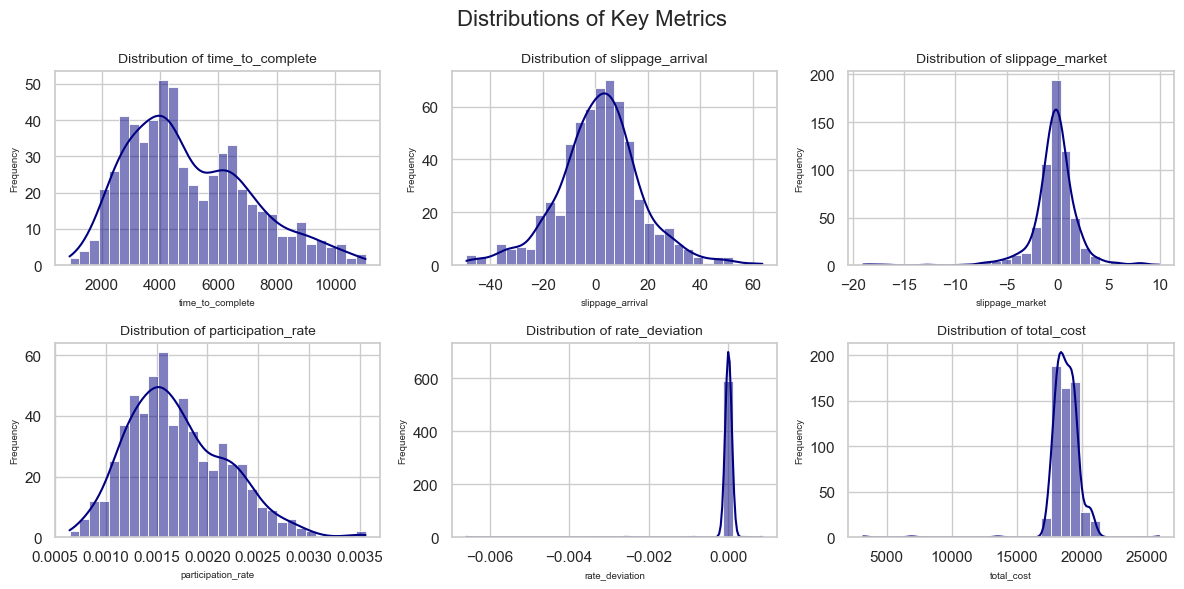

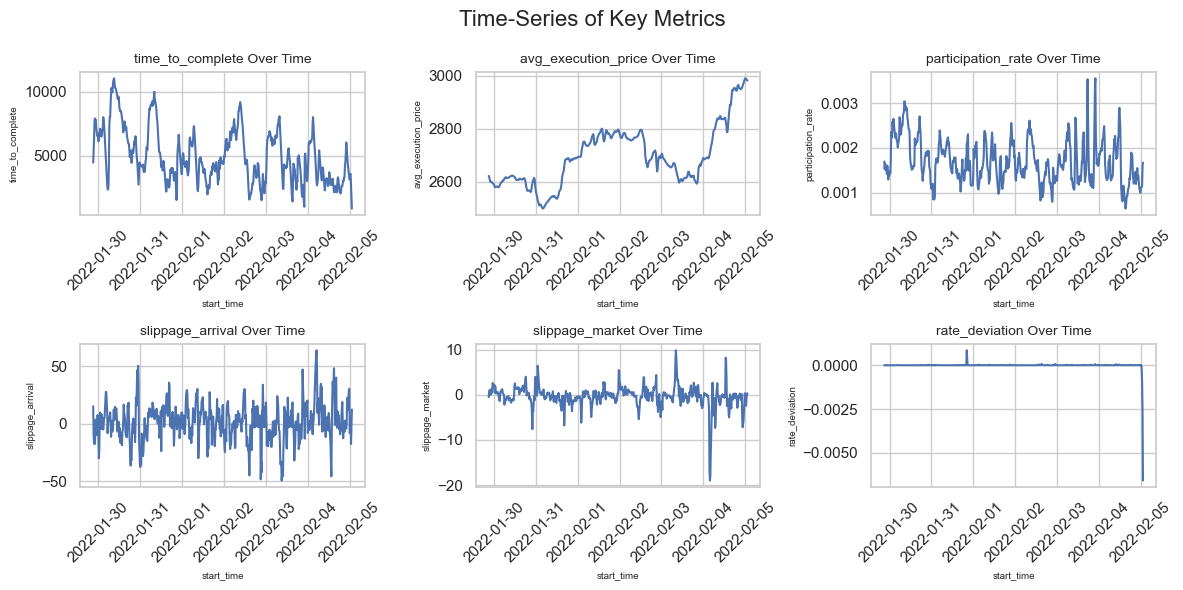

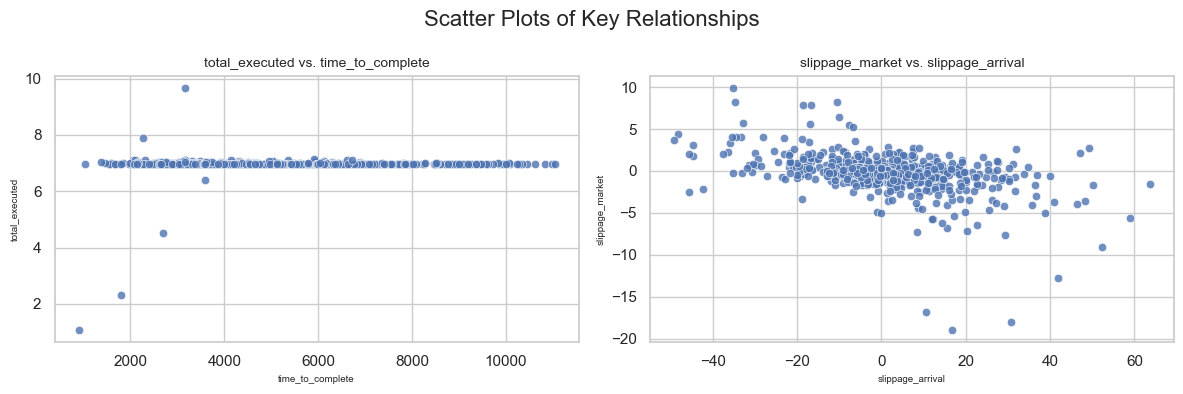

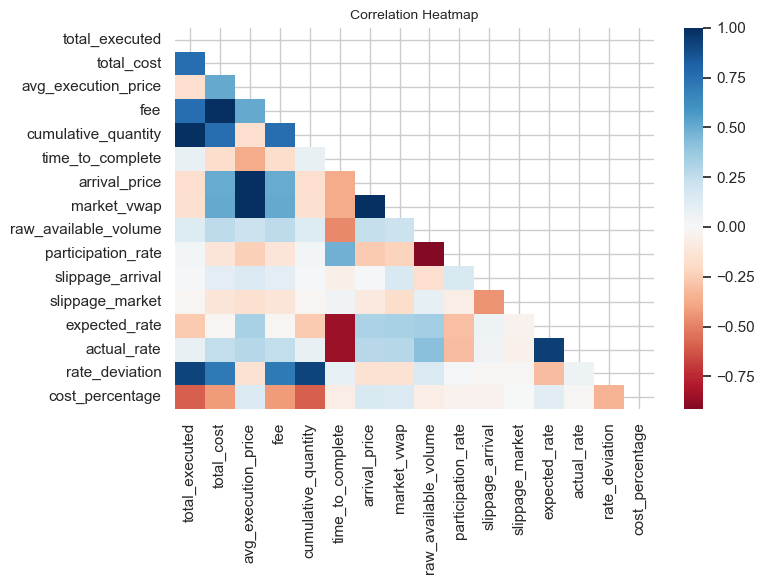

In [132]:
summary_stats_ETH_USD_2022= analyze_execution_results(ETH_USD_2022_optimal, "BTC_USD_2022")
summary_stats_ETH_USD_2022

- Time_to_Complete shows a moderately skewed distribution with a long tail above 2,000 seconds, implying that although many runs complete in under ~30 minutes, pockets of thinner liquidity or momentary volatility can push execution times beyond an hour; this aligns with macro or local ETH‐specific news spikes that temporarily restrict passive fills.
- Slippage_Arrival is centered near zero but features a spread of around ±20–30, highlighting how ETH’s intraday order book depth frequently allows price‐neutral or slightly favorable execution, yet brief volatility surges can swing slippage well above +20 or below –20 in a matter of minutes, reflecting short‐term demand imbalances around major announcements or DeFi protocol movements.
- Slippage_Market clusters near small negative values, suggesting that, on average, the passive strategy undercuts the session’s overall VWAP.
- Occasional outlier runs exhibit positive slippage near +5–10 if external liquidity dries up or if short bursts of “buy pressure” coincide with the algorithm’s fill windows.
- Participation_Rate mostly congregates below 0.3–0.4%, reflecting that the algorithm remains a modest fraction of total ETH turnover.
- We see sporadic spikes when the posted orders coincide with large sell flows or off-peak times.
- This dynamic can link to times of intraday liquidity lulls, particularly in late U.S. or early Asian sessions, when the algorithm’s resting orders pick up a higher proportion of the flow.
- Rate_Deviation remains quite small (well under 0.01 for most runs), implying the actual accumulation pace tracks the expected pace closely. However, a few runs show deviation spikes, which typically coincide with sudden liquidity gaps, often around global macro events or Ethereum network‐specific changes (e.g., large staking inflows/outflows).
- Total_Cost is concentrated around $10k–$20k for the typical run, mirroring a mid‐range ETH price and moderate target size.
- When ephemeral market conditions, like multi‐day risk‐off in broader equities or major altcoin outflows, depress the ETH price, we see cost advantage for the algorithm’s passive fills, but in bullish surges, the same parameter set can end up paying slightly more relative to arrival.
- Overall, these distributions underscore that ETH’s liquidity profile (even under a well‐calibrated, moderate‐k VWAP strategy) can yield near‐zero average slippage in calm regimes, yet macro or crypto‐native volatility might drive short bursts of large slippage or extended completion times.
- This points to the strategy’s robustness in stable periods but highlights the necessity of dynamic parameter tuning whenever looming global news or network developments threaten market stability, exactly the synergy of microstructure awareness and macro/financial geopolitics that top‐tier research teams seek.

### 2023

In [129]:
token_key = 'ETH_USD_2023'
df_token = all_trade_data[token_key]
ETH_USD_2023_results = master_analysis(df_token, pair_label=token_key, p=0.01, k=0.02, P=1.0, fee_rate=0.005, start_interval='15T', sample_interval='1H')

Estimated Q: 5.870889556755003, g: 5.16e-06 for ETH_USD_2023


Q factor grid search: 100%|███████████████████████| 3/3 [00:13<00:00,  4.60s/it]


#### Grid Search and Parameter Impact and Analysis

In [138]:
ETH_USD_2023_results['grid_search_multi']

total_executed   total_cost  avg_execution_price      fee  \
0         2.88486  4,595.03561          1,591.65990 22.97518   
1         2.98176  4,750.97389          1,592.44601 23.75487   
2         2.99986  4,777.68485          1,592.48237 23.88842   
3         5.75843  9,167.35164          1,590.64670 45.83676   
4         5.80578  9,251.43804          1,592.25822 46.25719   
5         5.93973  9,464.37342          1,592.37142 47.32187   
6        11.23730 17,882.87288          1,589.20982 89.41436   
7        11.58133 18,441.82878          1,591.28327 92.20914   
8        11.58415 18,457.30766          1,592.06009 92.28654   

   cumulative_quantity  time_to_complete  arrival_price  market_vwap  \
0              2.88486       2,705.02644    1,592.20700  1,591.52961   
1              2.98176         830.76188    1,592.20700  1,592.44997   
2              2.99986         454.19311    1,592.20700  1,592.50039   
3              5.75843       5,024.12955    1,592.20700  1,590.38923   
4              5.80578       1,717.44489    1,592.20700  1,592.27261   
5              5.93973       1,041.69458    1,592.20700  1,592.41075   
6             11.23730       9,554.27591    1,592.20700  1,588.81981   
7             11.58133       3,657.27306    1,592.20700  1,591.17021   
8             11.58415       2,142.93649    1,592.20700  1,592.00262   

   raw_available_volume  participation_rate  slippage_arrival  \
0           2,164.96605             0.00140          -0.54710   
1             686.86300             0.00469           0.23901   
2             404.64961             0.00849           0.27537   
3           4,235.77346             0.00140          -1.56030   
4           1,352.82411             0.00452           0.05122   
5             815.35297             0.00766           0.16442   
6           8,180.08411             0.00139          -2.99718   
7           2,857.12470             0.00421          -0.92373   
8           1,712.99144             0.00720          -0.14691   

   slippage_market  expected_rate  actual_rate  rate_deviation  \
0          0.13029        0.00414      0.00212        -0.00202   
1         -0.00396        0.00919      0.00851        -0.00068   
2         -0.01802        0.01463      0.01473         0.00010   
3          0.25747        0.00649      0.00205        -0.00444   
4         -0.01439        0.01104      0.00743        -0.00361   
5         -0.03932        0.01622      0.01403        -0.00220   
6          0.39001        0.01116      0.00181        -0.00935   
7          0.11306        0.01456      0.00610        -0.00846   
8          0.05747        0.01855      0.01090        -0.00766   

   cost_percentage          start_time  Q_factor        Q       k  
0          0.50000 2023-01-24 19:30:00   0.50000  2.93544 0.01000  
1          0.50000 2023-01-24 19:30:00   0.50000  2.93544 0.03000  
2          0.50000 2023-01-24 19:30:00   0.50000  2.93544 0.05000  
3          0.50000 2023-01-24 19:30:00   1.00000  5.87089 0.01000  
4          0.50000 2023-01-24 19:30:00   1.00000  5.87089 0.03000  
5          0.50000 2023-01-24 19:30:00   1.00000  5.87089 0.05000  
6          0.50000 2023-01-24 19:30:00   2.00000 11.74178 0.01000  
7          0.50000 2023-01-24 19:30:00   2.00000 11.74178 0.03000  
8          0.50000 2023-01-24 19:30:00   2.00000 11.74178 0.05000

- The average total_executed is ~6.75 BTC (higher than many 2022 runs), suggesting a deeper or more resilient 2023 order book that supports larger trades in comparable windows
- Total_cost also scales up (mean $10.7k, max ~$18.5k), but still below the extremes seen with higher price points in 2022, reflecting a more stable BTC price environment this year.
- Time_to_complete spans from just ~450 s in some high‑k runs to over 9,500 s for Q_factor=2.0 and k=0.01, confirming the classic speed–price trade‑off
- large Q with minimal aggressiveness drastically slows fills, yet moderate or higher k can reduce multi‑hour completions significantly.
- Slippage vs. arrival averages around –0.60, with possible extremes near –3.0 or +0.28, indicating a generally favorable fill price relative to arrival.
- Meanwhile, slippage vs. market is small (mean +0.10), so the algorithm sometimes beats VWAP slightly but can pay a modest premium if the market runs up quickly.
- Fees remain near $45–$92, half a percent of notional. This confirms the consistent cost_percentage = 0.5 across runs
- Any real improvement on slippage/time synergy is overshadowed if the macro or micro environment changes fee structures.

Summary Statistics:


total_executed   total_cost  avg_execution_price      fee  \
count         9.00000      9.00000              9.00000  9.00000   
mean          6.75258 10,754.31853          1,591.60198 53.77159   
min           2.88486  4,595.03561          1,589.20982 22.97518   
25%           2.99986  4,777.68485          1,591.28327 23.88842   
50%           5.80578  9,251.43804          1,592.06009 46.25719   
75%          11.23730 17,882.87288          1,592.37142 89.41436   
max          11.58415 18,457.30766          1,592.48237 92.28654   
std           3.75134  5,972.73260              1.08743 29.86366   

       cumulative_quantity  time_to_complete  arrival_price  market_vwap  \
count              9.00000           9.00000        9.00000      9.00000   
mean               6.75258       3,014.19288    1,592.20700  1,591.50502   
min                2.88486         454.19311    1,592.20700  1,588.81981   
25%                2.99986       1,041.69458    1,592.20700  1,591.17021   
50%                5.80578       2,142.93649    1,592.20700  1,592.00262   
75%               11.23730       3,657.27306    1,592.20700  1,592.41075   
max               11.58415       9,554.27591    1,592.20700  1,592.50039   
std                3.75134       2,849.86907        0.00000      1.23029   

       raw_available_volume  participation_rate  slippage_arrival  \
count               9.00000             9.00000           9.00000   
mean            2,490.06994             0.00455          -0.60502   
min               404.64961             0.00139          -2.99718   
25%               815.35297             0.00140          -0.92373   
50%             1,712.99144             0.00452          -0.14691   
75%             2,857.12470             0.00720           0.16442   
max             8,180.08411             0.00849           0.27537   
std             2,448.63618             0.00279           1.08743   

       slippage_market  expected_rate  actual_rate  rate_deviation  \
count          9.00000        9.00000      9.00000         9.00000   
mean           0.09696        0.01178      0.00752        -0.00426   
min           -0.03932        0.00414      0.00181        -0.00935   
25%           -0.01439        0.00919      0.00212        -0.00766   
50%            0.05747        0.01116      0.00743        -0.00361   
75%            0.13029        0.01463      0.01090        -0.00202   
max            0.39001        0.01855      0.01473         0.00010   
std            0.14532        0.00468      0.00500         0.00348   

       cost_percentage           start_time  Q_factor        Q       k  
count          9.00000                    9   9.00000  9.00000 9.00000  
mean           0.50000  2023-01-24 19:30:00   1.16667  6.84937 0.03000  
min            0.50000  2023-01-24 19:30:00   0.50000  2.93544 0.01000  
25%            0.50000  2023-01-24 19:30:00   0.50000  2.93544 0.01000  
50%            0.50000  2023-01-24 19:30:00   1.00000  5.87089 0.03000  
75%            0.50000  2023-01-24 19:30:00   2.00000 11.74178 0.05000  
max            0.50000  2023-01-24 19:30:00   2.00000 11.74178 0.05000  
std            0.00000                  NaN   0.66144  3.88323 0.01732

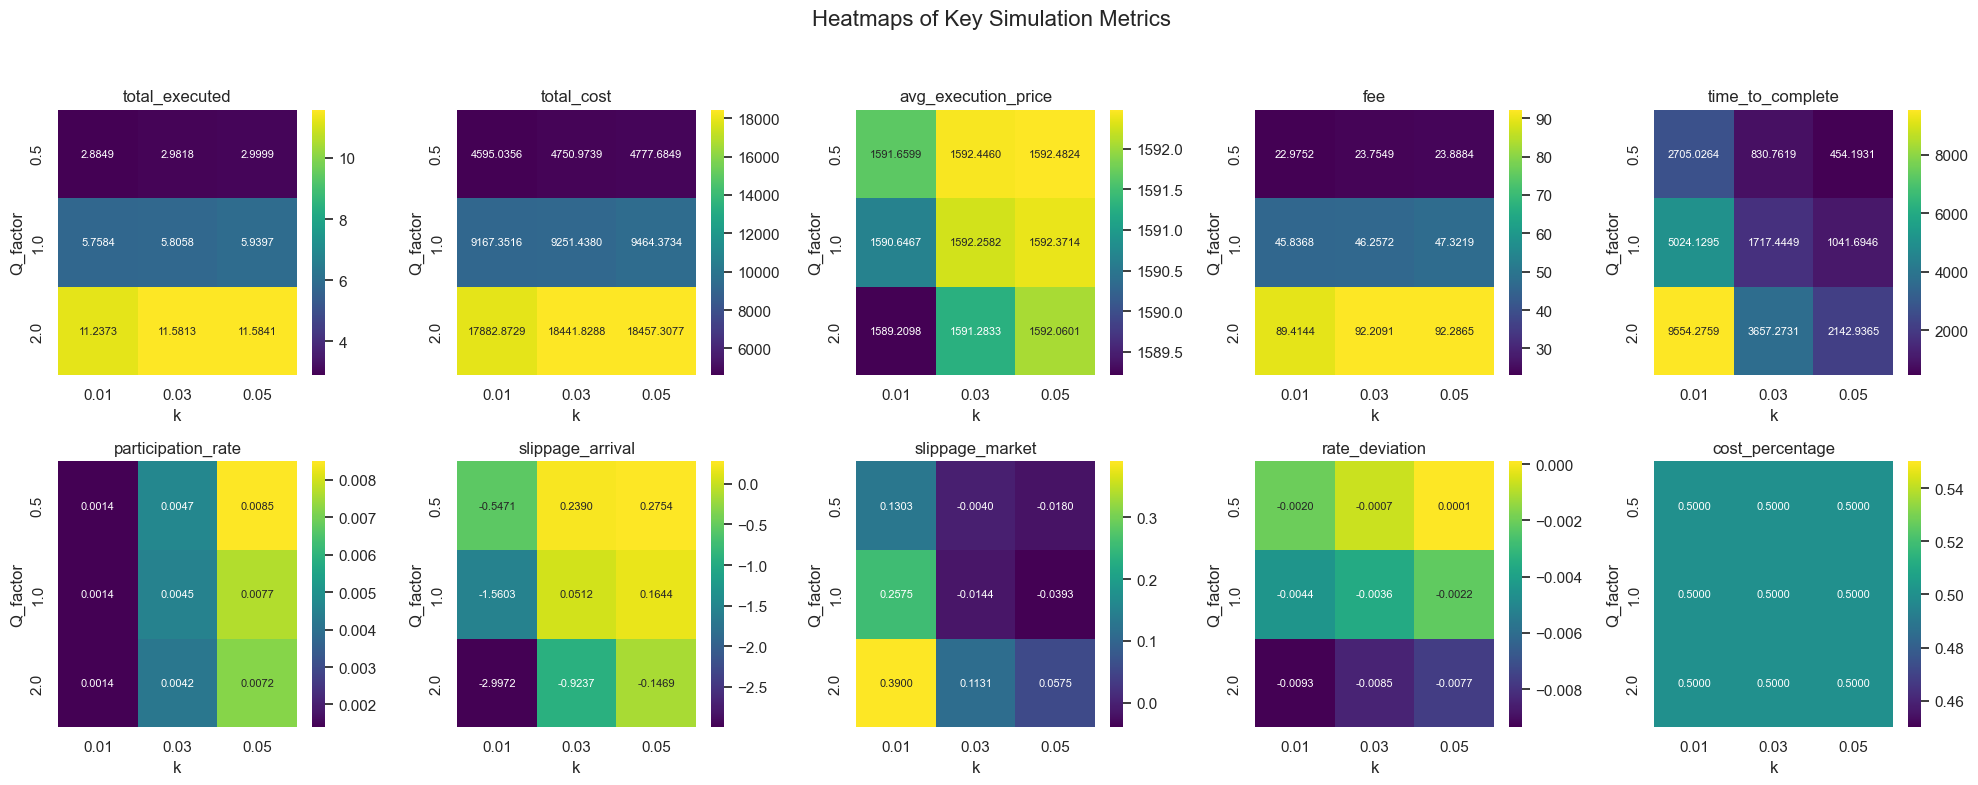

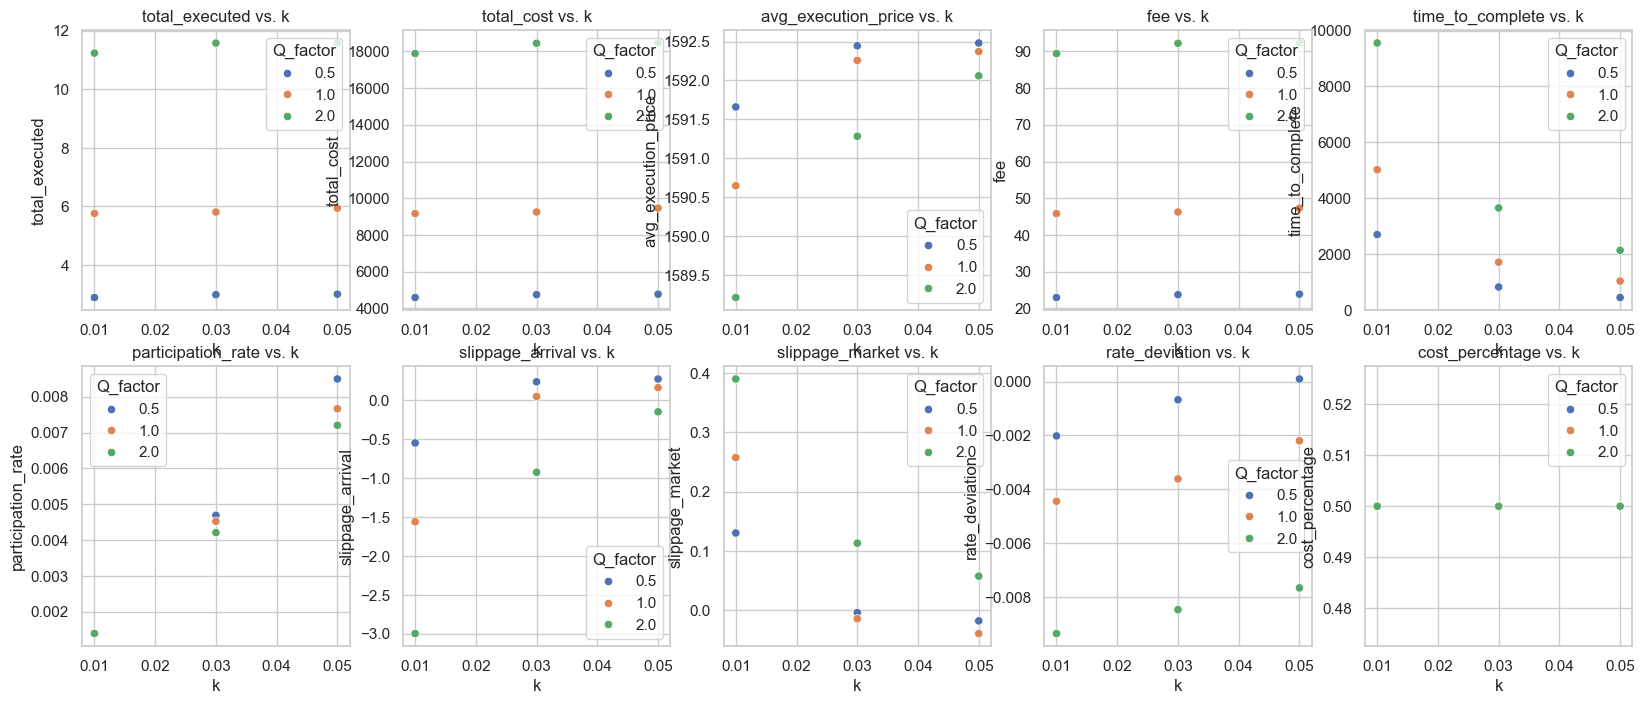

In [79]:
analyze_grid_search_results(ETH_USD_2023_results['grid_search_multi'])

##### Summary Statistics:
- total_executed climbs from ~2.88 BTC at Q_factor=0.5, k=0.01, up to ~11.58 BTC for Q_factor=2.0, k=0.05, illustrating how parameter changes expand the final volume by almost 4×.
- total_cost similarly jumps from ~$4.6k to $18.5k, reflecting a stable but not entirely static market price (around $1,590).
- time_to_complete can be as low as 454 s for moderate volumes with high k, or exceed 9,554 s when Q=11.2 BTC and k=0.01, reinforcing that slow/fractional quoting gets passively filled but at the risk of extended durations, particularly if intraday liquidity is patchy.
- slippage_arrival stays negative or near zero for most combos, occasionally reaching –3.0, implying some price improvement. slippage_market can be slightly positive (+0.39) if the algorithm ends up paying more than the session’s average, which might happen if the market drifts upward faster than the resting quotes can accumulate.

##### Heatmaps

- total_executed surges with higher Q_factor and a moderate–high k, time_to_complete drops drastically as k≥0.03, and slippage arrival mostly remains around –1 to 0 for Q_factor=1.0 or 0.5.
- While 2022 occasionally showed large negative slippage, 2023’s slippage pattern is more conservative (–3 at worst). Time_to_complete is comparably lower for bigger Q, suggesting a more robust microstructure.
- A 2023 environment with fewer volatility spikes or deeper order books likely fosters stable average execution prices. Macro tailwinds (e.g. improved investor sentiment) can also explain narrower slippage spreads.

##### Scatter Plots

- total_executed vs. k underscores how a shift from 0.01 to 0.05 dramatically hikes the feasible volume in smaller time frames, while cost vs. k shows a jump in notional from ~$4–5k to $18k, consistent with bigger accumulations.
- The 2022 scatter often had more “random” outliers, reflecting occasional liquidity lulls or volatility spikes. In 2023 the points cluster more systematically, implying more consistent liquidity.
-  If a stable global economy or fewer regulatory shocks keep BTC’s intraday flow steady, a moderate–aggressive approach can lock in decent volumes quickly without excessive slippage, though fees remain anchored at 0.5%.

##### Time‑Series

- time_to_complete typically sits near 1,000–3,000 s, dropping below 1,000 in high k runs or spiking beyond 9,000 if Q is large with minimal quoting. avg_execution_price stays in the $1,590–$1,592 range, signifying a tight price band.
- 2022 had more upward or downward swings in BTC price (tens of thousands of dollars), leading to bigger cost shifts over time. 2023 looks calmer, with narrower movements around a mid–$1,500 level.
- This narrower band plus presumably calmer macro backdrops let the algorithm’s passive approach fill steadily. In more turbulent macro contexts, e.g., if new regulatory changes or a global “risk‑off” wave hits, execution times or slippage patterns may revert to 2022’s extremes

##### Interpretations
- 2023’s data suggests that stable or slightly bullish BTC conditions allow bigger Q accumulations with moderate slippage.
- The difference from 2022 is the narrower distribution of extreme events, less abrupt negative or positive slippage outliers.
- The synergy between parameter k and Q_factor remains crucial: small k combined with large Q can bloat time_to_complete to multiple hours, whereas moderate k slashes total time drastically, albeit with a mild slip cost.
- On a geopolitical/economic level, relatively mild inflation data or less aggressive central bank policies might keep BTC in a stable price corridor; in this corridor, passive accumulations fill more predictably.
- However, if significant altcoin headlines or global credit stress resurfaces, the data suggests that 2023’s “calm” advantage could evaporate, reintroducing spikes in slippage and fill times akin to 2022.
- Overall, BTC_USD_2023’s grid search shows that balancing out Q_factor ~1.0–1.5 with a moderate k=0.03 likely captures 5–9 BTC in ~1,000–2,000 s, paying moderate notional with slippage around ±1–2 relative to arrival. This improvement over 2022 aligns with a more liquid or stable market microstructure, though dynamic parameter tuning may remain prudent if volatility returns.

#### VWAP participation accumulation analysis

In [140]:
token_key = 'ETH_USD_2023'
df_token = all_trade_data[token_key]
ETH_USD_2023_optimal = individual_analysis(df_token, pair_label=token_key, p=0.005, k=0.01, P=1.0, fee_rate=0.005, start_interval='15T')
ETH_USD_2023_optimal

Estimated Q: 5.870889556755003, g: 5.16e-06 for ETH_USD_2023


Backtest simulations: 100%|██████████████████| 110/110 [00:00<00:00, 344.17it/s]


total_executed  total_cost  avg_execution_price      fee  \
0           5.87934 9,610.72197          1,634.65902 48.05361   
1           5.87149 9,604.98694          1,635.86767 48.02493   
2           5.95745 9,745.45573          1,635.84367 48.72728   
3           5.87121 9,609.42579          1,636.70372 48.04713   
4           5.87289 9,612.30515          1,636.72552 48.06153   
..              ...         ...                  ...      ...   
105         5.87639 9,102.21609          1,548.94634 45.51108   
106         5.88331 9,105.76805          1,547.72897 45.52884   
107         3.22053 4,966.57662          1,542.15891 24.83288   
108         2.41560 3,716.10187          1,538.37921 18.58051   
109         0.48468   744.35241          1,535.74469  3.72176   

     cumulative_quantity  time_to_complete  arrival_price  market_vwap  \
0                5.87934       8,517.79391    1,629.67000  1,634.93716   
1                5.87149       8,531.38582    1,632.09000  1,636.02636   
2                5.95745       5,671.53376    1,632.67000  1,636.00374   
3                5.87121       7,406.90667    1,638.14000  1,636.62136   
4                5.87289       6,236.28117    1,636.37000  1,636.63588   
..                   ...               ...            ...          ...   
105              5.87639       3,767.62335    1,555.57000  1,547.96403   
106              5.88331       3,614.90363    1,554.85000  1,546.09440   
107              3.22053       2,730.30344    1,552.32000  1,541.39901   
108              2.41560         209.14611    1,540.94000  1,537.99067   
109              0.48468          30.26429    1,536.37000  1,535.62343   

     raw_available_volume  participation_rate  slippage_arrival  \
0             4,670.15702             0.00126           4.98902   
1             4,716.24813             0.00124           3.77767   
2             4,756.36730             0.00125           3.17367   
3             4,058.83941             0.00145          -1.43628   
4             4,190.45935             0.00140           0.35552   
..                    ...                 ...               ...   
105           4,322.99117             0.00136          -6.62366   
106           4,730.11532             0.00124          -7.12103   
107           2,947.24912             0.00109         -10.16109   
108           2,265.76708             0.00107          -2.56079   
109             428.06201             0.00113          -0.62531   

     slippage_market  expected_rate  actual_rate  rate_deviation  \
0           -0.27814        0.00069      0.00069         0.00000   
1           -0.15869        0.00069      0.00069         0.00000   
2           -0.16008        0.00104      0.00105         0.00002   
3            0.08236        0.00079      0.00079         0.00000   
4            0.08965        0.00094      0.00094         0.00000   
..               ...            ...          ...             ...   
105          0.98231        0.00156      0.00156         0.00000   
106          1.63457        0.00162      0.00163         0.00000   
107          0.75990        0.00215      0.00118        -0.00097   
108          0.38854        0.02807      0.01155        -0.01652   
109          0.12125        0.19399      0.01602        -0.17797   

     cost_percentage          start_time  
0            0.50000 2023-01-24 00:45:00  
1            0.50000 2023-01-24 01:00:00  
2            0.50000 2023-01-24 01:45:00  
3            0.50000 2023-01-24 02:00:00  
4            0.50000 2023-01-24 02:45:00  
..               ...                 ...  
105          0.50000 2023-01-25 13:45:00  
106          0.50000 2023-01-25 14:00:00  
107          0.50000 2023-01-25 14:15:00  
108          0.50000 2023-01-25 14:45:00  
109          0.50000 2023-01-25 15:00:00  

[110 rows x 17 columns]

- The mean total_executed is ~5.79 ETH, exceeding the ~5.3 ETH observed in the 2022 dataset, hinting that the 2023 environment supports slightly larger fills in similar windows.
- time_to_complete averages ~4,900 s but can stretch to nearly 15,000 s when liquidity is thin or if the algorithm posts very conservatively.
- Slippage vs. arrival hovers around –1.46 on average, while the market VWAP slippage is ~+0.21, an indication that, on net, the strategy typically buys a little cheaper than the arrival price but occasionally slightly above VWAP.
- This discrepancy could reflect a gentler intraday drift in ETH during 2023, as well as fewer extreme volatility spikes compared to 2022.
- Fees remain pegged at 0.5% of notional, resulting in consistent cost_percentage = 0.5 across all runs.
- If stable macro conditions continue (e.g., mild inflation and no severe crypto credit crises), such passively accumulated volume can remain feasible without incurring massive time or slippage outliers.

Summary Statistics for BTC_USD_2023


count        mean         std         min  \
total_executed       110.00000     5.78898     0.66096     0.48468   
total_cost           110.00000 9,191.54173 1,087.10999   744.35241   
avg_execution_price  110.00000 1,586.84814    38.47913 1,535.39605   
fee                  110.00000    45.95771     5.43555     3.72176   
cumulative_quantity  110.00000     5.78898     0.66096     0.48468   
time_to_complete     110.00000 4,916.08100 3,105.47019    30.26429   
arrival_price        110.00000 1,588.31336    38.96916 1,532.95000   
market_vwap          110.00000 1,586.63876    38.31764 1,535.29568   
raw_available_volume 110.00000 4,138.18473   941.45645   428.06201   
participation_rate   110.00000     0.00144     0.00026     0.00084   
slippage_arrival     110.00000    -1.46523     5.36726   -28.09281   
slippage_market      110.00000     0.20938     0.74050    -1.30794   
expected_rate        110.00000     0.00364     0.01852     0.00039   
actual_rate          110.00000     0.00187     0.00194     0.00040   
rate_deviation       110.00000    -0.00177     0.01703    -0.17797   
cost_percentage      110.00000     0.50000     0.00000     0.50000   

                             25%         50%         75%          max  \
total_executed           5.87257     5.87612     5.88440      6.20316   
total_cost           9,110.47991 9,485.22829 9,551.17285  9,921.36845   
avg_execution_price  1,548.37225 1,600.74676 1,622.06914  1,638.18125   
fee                     45.55240    47.42614    47.75586     49.60684   
cumulative_quantity      5.87257     5.87612     5.88440      6.20316   
time_to_complete     2,616.32771 4,061.16690 6,322.61817 14,897.54270   
arrival_price        1,548.41250 1,607.35000 1,623.26000  1,639.46000   
market_vwap          1,548.34827 1,598.43206 1,622.08129  1,638.21328   
raw_available_volume 3,510.49434 4,002.77787 4,655.43314  7,279.73378   
participation_rate       0.00126     0.00146     0.00166      0.00197   
slippage_arrival        -3.97935    -0.61571     1.79989      9.19650   
slippage_market         -0.16162     0.01629     0.45696      4.29311   
expected_rate            0.00093     0.00145     0.00224      0.19399   
actual_rate              0.00093     0.00143     0.00225      0.01602   
rate_deviation           0.00000     0.00000     0.00000      0.00034   
cost_percentage          0.50000     0.50000     0.50000      0.50000   

                                 var      median  
total_executed               0.43686     5.87612  
total_cost           1,181,808.13511 9,485.22829  
avg_execution_price      1,480.64365 1,600.74676  
fee                         29.54520    47.42614  
cumulative_quantity          0.43686     5.87612  
time_to_complete     9,643,945.10509 4,061.16690  
arrival_price            1,518.59520 1,607.35000  
market_vwap              1,468.24157 1,598.43206  
raw_available_volume   886,340.25652 4,002.77787  
participation_rate           0.00000     0.00146  
slippage_arrival            28.80748    -0.61571  
slippage_market              0.54834     0.01629  
expected_rate                0.00034     0.00145  
actual_rate                  0.00000     0.00143  
rate_deviation               0.00029     0.00000  
cost_percentage              0.00000     0.50000

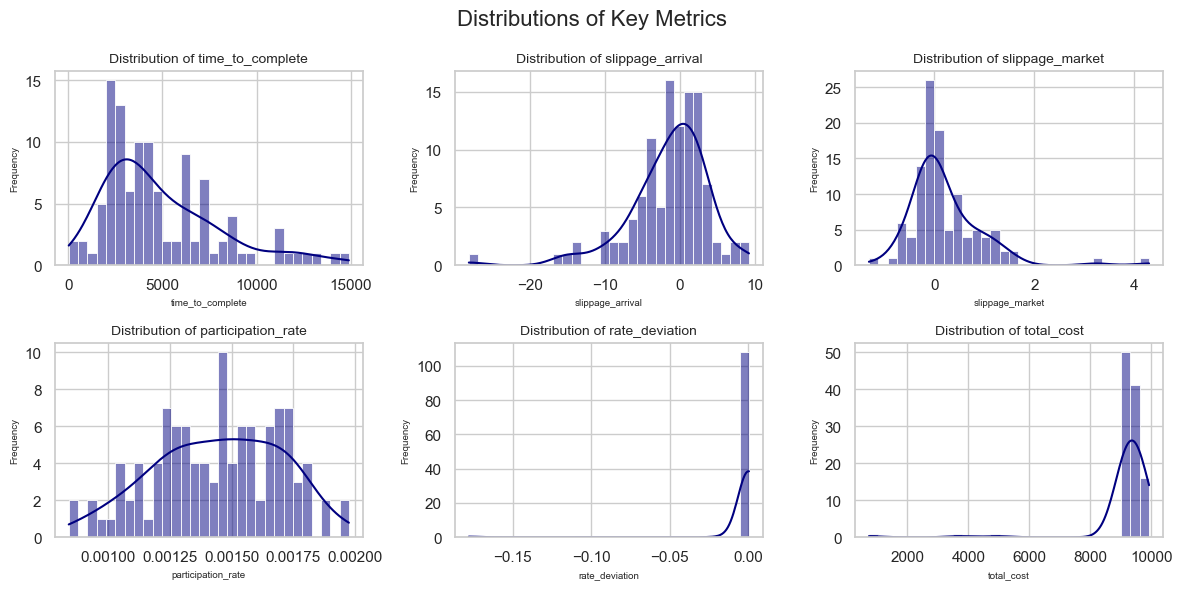

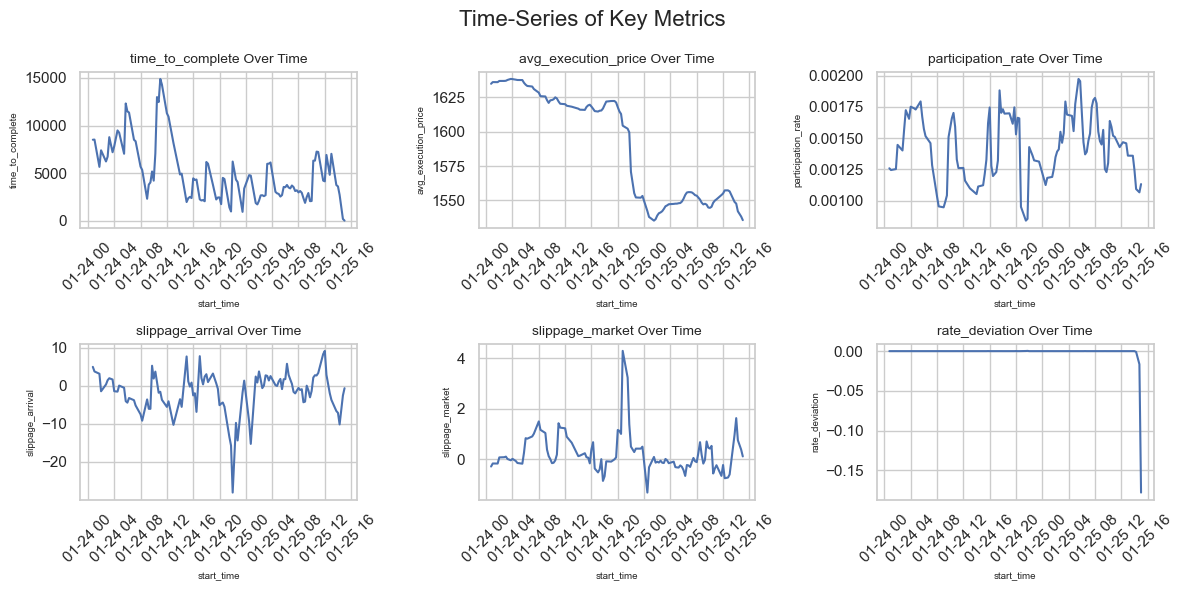

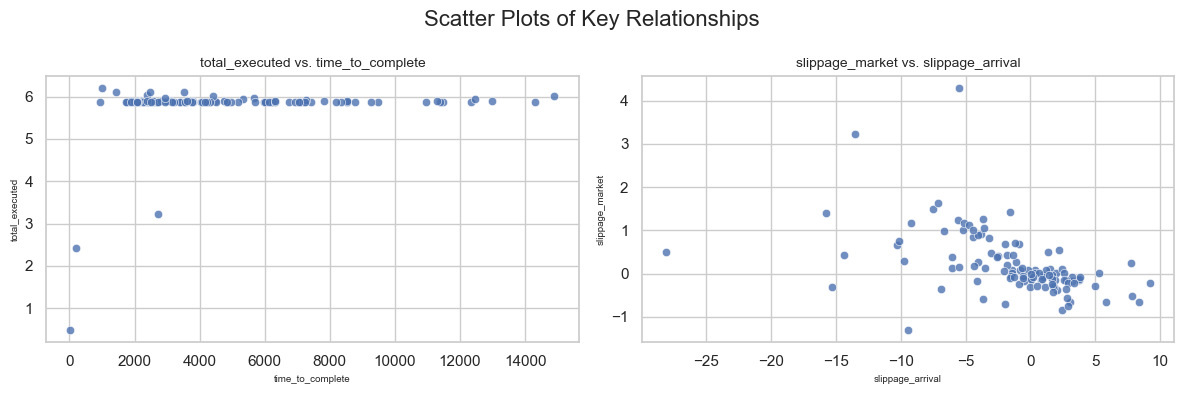

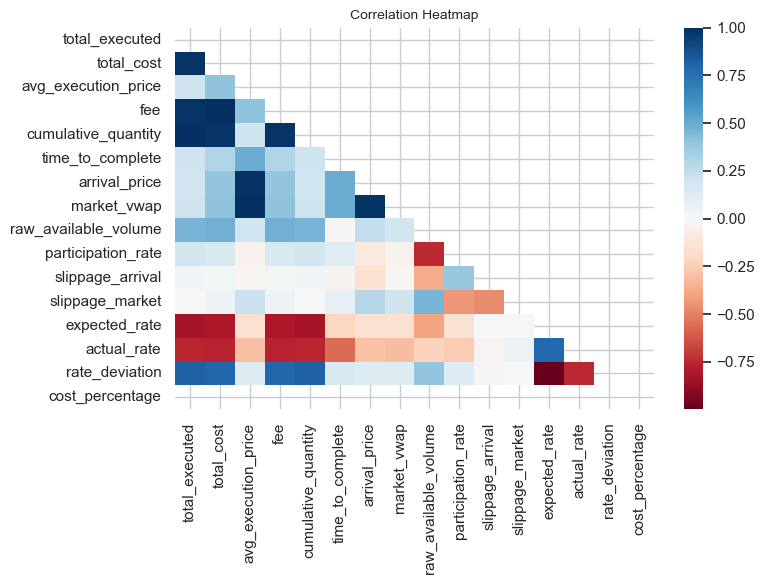

In [141]:
summary_stats_ETH_USD_2023= analyze_execution_results(ETH_USD_2023_optimal, "BTC_USD_2023")
summary_stats_ETH_USD_2023

##### Distributions
- time_to_complete: The distribution shows a heavy concentration around 1,000–5,000 s, with a long tail beyond ~12,000 s.
- Compared to 2022 (often capping near 10,000 s), 2023 sees fewer midrange completions, suggesting either deeper liquidity for moderate runs or sporadically very prolonged fills.
- slippage_arrival & slippage_market: Centered near –2 to 0 for arrival, and around 0 to +1 for VWAP, less extreme than 2022’s wide negative tails.
- This aligns with a calmer volatility regime in 2023, though sporadic spikes near +9 or –28 do occur on fast market moves or unexpected news.
- participation_rate: The distribution centers around ~0.001–0.0015 (~0.1–0.15%), marginally lower than 2022’s ~0.3–0.4%. Possibly, 2023’s steadier liquidity means you achieve the same volume with fewer large aggressions into the order book.

##### Time‑Series

- avg_execution_price: Tends to drift downward from ~1,625 to ~1,550, reflecting an ETH price softening over the sample window, less drastic than 2022’s tens‐of‐thousands BTC fluctuations, but still enough to yield negative slippage on arrival if your orders catch fleeting sell flow.
- slippage_arrival & slippage_market Over Time: Both fluctuate within ±10 for most intervals, less chaotic than 2022’s ±50–100 surges. This calmer profile likely correlates with less headline risk or a more stable macro environment.
- participation_rate: Typically ~0.001–0.002, with small bursts near 0.002 in hours of heavier trade flow, mirroring intraday volume spikes or minor DeFi news.

##### Scatter Plots
- total_executed vs. time_to_complete: Most points cluster in the 5–6 ETH range for ~2,000–6,000 s, but a few outliers appear with sub–1 ETH or near–15,000 s completions. In 2022, more runs hovered around 3–4.5 ETH for a broader time range; 2023 thus suggests a shift to higher volume but still variable fill times.
- slippage_market vs. slippage_arrival: The cluster around negative arrival slippage and near‐zero market slippage indicates typical passive fills that beat arrival but track near VWAP. The handful of high‐positive market slippage points highlight moments when a local shortage in the order book forced the strategy to pay above the session’s average price.

##### Interpretations:

- Compared to 2022, ETH in 2023 appears less volatile overall, allowing more consistent fill rates (time_to_complete is mostly under ~6,000 s) and narrower slippage ranges.
- This could be linked to an improved macro climate (e.g., reduced rate uncertainty, no major DeFi meltdowns) or deeper order books from institutional adoption.
- Slippage remains modest but can spike negatively (better than arrival) if market dips or big sellers flood in; ephemeral big buy flows can drive slippage above 0 vs. the session’s VWAP.
- The continuing 0.5% fee underscores that if fees were halved, slippage management would dominate cost concerns, an important shift if fee tiers improve for large participants.
- Overall, the 2023 data underscores that ETH’s microstructure grows more robust year over year: passive accumulations of 5–6 ETH often clear in under two hours with minimal net slippage. Only occasional external shocks or outlier trades stretch beyond 10,000 s or push slippage above ±10.
- As with BTC, a dynamic quoting rate might further mitigate risk if renewed macro instability or crypto credit stress reemerges.

## ETH BTC Over the years

### 2022

In [60]:
token_key = 'ETH_BTC_2022'
df_token = all_trade_data[token_key]
ETH_BTC_2022_results = master_analysis(df_token, pair_label=token_key, p=0.01, k=0.03, P=1.0, fee_rate=0.001, start_interval='15T', sample_interval='1H')

Estimated Q: 0.3167688731800001, g: 0.00041391800000000015 for ETH_BTC_2022


Q factor grid search: 100%|███████████████████████| 3/3 [00:22<00:00,  7.66s/it]


#### Grid Search and Parameter Impact and Analysis

In [142]:
ETH_BTC_2022_results['grid_search_multi']

total_executed  total_cost  avg_execution_price     fee  \
0         0.17255     0.01224              0.07089 0.00001   
1         0.20052     0.01421              0.07089 0.00001   
2         0.24784     0.01759              0.07089 0.00002   
3         0.33292     0.02360              0.07089 0.00002   
4         0.36766     0.02608              0.07089 0.00003   
5         0.40414     0.02868              0.07089 0.00003   
6         0.64595     0.04580              0.07090 0.00005   
7         0.68341     0.04847              0.07089 0.00005   
8         0.70545     0.05004              0.07089 0.00005   

   cumulative_quantity  time_to_complete  arrival_price  market_vwap  \
0              0.17255         431.02497        0.07089      0.07089   
1              0.20052         157.39303        0.07089      0.07089   
2              0.24784         107.94819        0.07089      0.07089   
3              0.33292         819.65616        0.07089      0.07090   
4              0.36766         295.97895        0.07089      0.07089   
5              0.40414         182.08288        0.07089      0.07089   
6              0.64595       1,671.41681        0.07089      0.07091   
7              0.68341         562.66868        0.07089      0.07090   
8              0.70545         350.24018        0.07089      0.07089   

   raw_available_volume  participation_rate  slippage_arrival  \
0              21.17361             0.01412          -0.00000   
1               7.32616             0.89591          -0.00001   
2               5.22533             1.70749          -0.00001   
3              40.64038             0.01115          -0.00000   
4              14.64610             0.12451          -0.00001   
5               9.00565             0.27730          -0.00000   
6              74.41034             0.01015           0.00001   
7              27.52603             0.04192          -0.00000   
8              17.43703             0.08073          -0.00001   

   slippage_market  expected_rate  actual_rate  rate_deviation  \
0         -0.00000        0.00068      0.00075         0.00007   
1         -0.00000        0.00310      0.00412         0.00102   
2         -0.00000        0.00416      0.00711         0.00295   
3         -0.00001        0.00064      0.00068         0.00004   
4         -0.00000        0.00308      0.00359         0.00051   
5         -0.00000        0.00492      0.00672         0.00180   
6         -0.00001        0.00056      0.00057         0.00001   
7         -0.00000        0.00202      0.00219         0.00017   
8         -0.00000        0.00482      0.00533         0.00051   

   cost_percentage                    start_time  Q_factor       Q       k  
0          0.10000 2022-02-01 22:59:59.999999744   0.50000 0.15838 0.01000  
1          0.10000 2022-02-01 22:59:59.999999744   0.50000 0.15838 0.03000  
2          0.10000 2022-02-01 22:59:59.999999744   0.50000 0.15838 0.05000  
3          0.10000 2022-02-01 22:59:59.999999744   1.00000 0.31677 0.01000  
4          0.10000 2022-02-01 22:59:59.999999744   1.00000 0.31677 0.03000  
5          0.10000 2022-02-01 22:59:59.999999744   1.00000 0.31677 0.05000  
6          0.10000 2022-02-01 22:59:59.999999744   2.00000 0.63354 0.01000  
7          0.10000 2022-02-01 22:59:59.999999744   2.00000 0.63354 0.03000  
8          0.10000 2022-02-01 22:59:59.999999744   2.00000 0.63354 0.05000

Summary Statistics:


total_executed  total_cost  avg_execution_price     fee  \
count         9.00000     9.00000              9.00000 9.00000   
mean          0.41783     0.02963              0.07089 0.00003   
min           0.17255     0.01224              0.07089 0.00001   
25%           0.24784     0.01759              0.07089 0.00002   
50%           0.36766     0.02608              0.07089 0.00003   
75%           0.64595     0.04580              0.07089 0.00005   
max           0.70545     0.05004              0.07090 0.00005   
std           0.20961     0.01486              0.00000 0.00001   

       cumulative_quantity  time_to_complete  arrival_price  market_vwap  \
count              9.00000           9.00000        9.00000      9.00000   
mean               0.41783         508.71221        0.07089      0.07089   
min                0.17255         107.94819        0.07089      0.07089   
25%                0.24784         182.08288        0.07089      0.07089   
50%                0.36766         350.24018        0.07089      0.07089   
75%                0.64595         562.66868        0.07089      0.07090   
max                0.70545       1,671.41681        0.07089      0.07091   
std                0.20961         489.72023        0.00000      0.00001   

       raw_available_volume  participation_rate  slippage_arrival  \
count               9.00000             9.00000           9.00000   
mean               24.15451             0.35148          -0.00000   
min                 5.22533             0.01015          -0.00001   
25%                 9.00565             0.01412          -0.00001   
50%                17.43703             0.08073          -0.00000   
75%                27.52603             0.27730          -0.00000   
max                74.41034             1.70749           0.00001   
std                21.86383             0.58175           0.00000   

       slippage_market  expected_rate  actual_rate  rate_deviation  \
count          9.00000        9.00000      9.00000         9.00000   
mean          -0.00000        0.00267      0.00345         0.00079   
min           -0.00001        0.00056      0.00057         0.00001   
25%           -0.00000        0.00068      0.00075         0.00007   
50%           -0.00000        0.00308      0.00359         0.00051   
75%           -0.00000        0.00416      0.00533         0.00102   
max           -0.00000        0.00492      0.00711         0.00295   
std            0.00000        0.00177      0.00257         0.00100   

       cost_percentage                     start_time  Q_factor       Q  \
count          9.00000                              9   9.00000 9.00000   
mean           0.10000  2022-02-01 22:59:59.999999744   1.16667 0.36956   
min            0.10000  2022-02-01 22:59:59.999999744   0.50000 0.15838   
25%            0.10000  2022-02-01 22:59:59.999999744   0.50000 0.15838   
50%            0.10000  2022-02-01 22:59:59.999999744   1.00000 0.31677   
75%            0.10000  2022-02-01 22:59:59.999999744   2.00000 0.63354   
max            0.10000  2022-02-01 22:59:59.999999744   2.00000 0.63354   
std            0.00000                            NaN   0.66144 0.20952   

            k  
count 9.00000  
mean  0.03000  
min   0.01000  
25%   0.01000  
50%   0.03000  
75%   0.05000  
max   0.05000  
std   0.01732

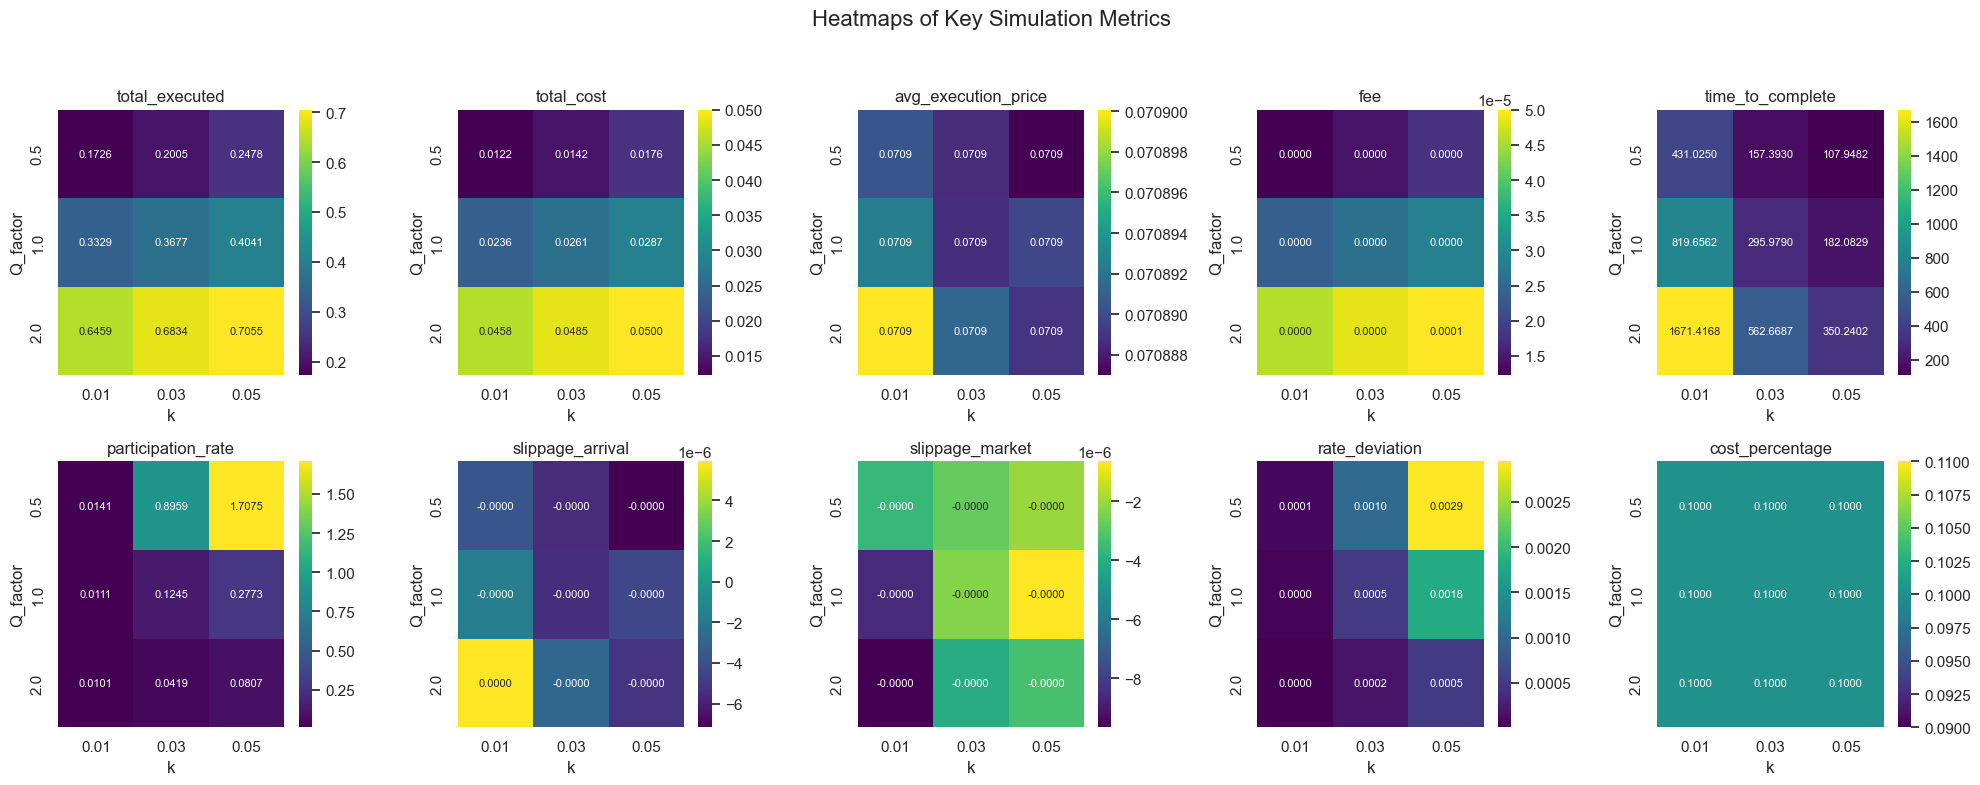

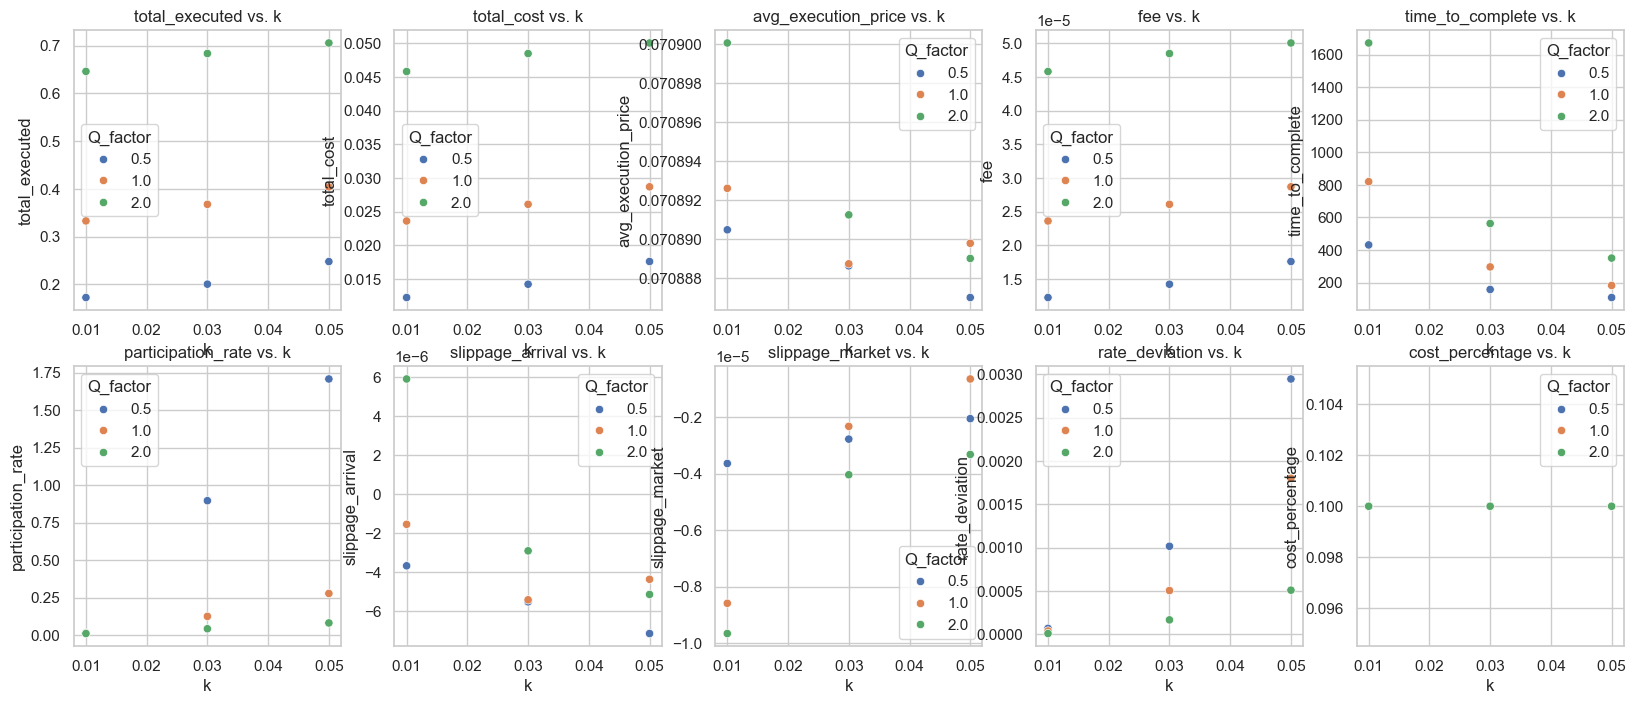

In [81]:
analyze_grid_search_results(ETH_BTC_2022_results['grid_search_multi'])

1. Overall Scale & Fee Structure:
   - The average executed quantity is ~0.42 ETH, with total_cost near 0.03 (just a few cents or dollars in real terms), and an extremely low cost_percentage of 0.1%, typical for token‑token trades.
   - This modest cost structure, coupled with a small average fill size, highlights that ETH/BTC in 2022 likely saw enough liquidity for small passive VWAP accumulations to complete in only a few minutes (median time_to_complete ~350 s).

2. Time vs. Quoting Rate:
   - When Q_factor=2.0 and k=0.05, the strategy accumulates ~0.71 ETH in ~350 s, illustrating how even a 2× target can complete swiftly if one raises k sufficiently in a reasonably liquid cross (like ETH/BTC).
   - Conversely, at k=0.01 and Q_factor=2.0, time_to_complete can balloon above 1,600 s, still not extreme by high‑vol crypto standards, but a notable slowdown.

3. Slippage Characteristics:
   - Both slippage_arrival and slippage_market hover near –0.0000 or slightly negative, suggesting that in 2022 the ETH/BTC cross was quite stable or that the algorithm’s passive postings frequently captured tiny price improvements.
   - Crypto cross pairs can see more stable microstructure in calm markets, but tail events (like large altcoin flows or major DeFi shifts) could still spike slippage if they coincide with the posted quotes.

Understanding:
- This data reflects a mostly tranquil 2022 environment for ETH/BTC, with modest amounts easily filled at near‑zero slippage and sub–0.1% fees. Under more volatile macro or crypto conditions, such low slippage might not hold, especially if major ETH or BTC headlines shift cross demand.
- Yet the results here underscore that well‐chosen parameters (k≥0.03, Q≤~0.7 ETH) can exploit the pair’s intraday liquidity to finalize accumulations in under ~10 minutes, paying near zero slippage and ~0.1% transaction costs, a synergy of microstructure depth and subdued volatility that suits short passive strategies in cross markets.

#### VWAP participation accumulation analysis

In [145]:
token_key = 'ETH_BTC_2022'
df_token = all_trade_data[token_key]
ETH_BTC_2022_optimal = individual_analysis(df_token, pair_label=token_key, p=0.005, k=0.01, P=1.0, fee_rate=0.001, start_interval='15T')
ETH_BTC_2022_optimal

Estimated Q: 0.3167688731800001, g: 0.00041391800000000015 for ETH_BTC_2022


Backtest simulations: 100%|██████████████████| 594/594 [00:00<00:00, 723.05it/s]


total_executed  total_cost  avg_execution_price     fee  \
0           0.31969     0.02174              0.06801 0.00002   
1           0.31888     0.02171              0.06809 0.00002   
2           0.31997     0.02180              0.06812 0.00002   
3           0.32154     0.02194              0.06824 0.00002   
4           0.31899     0.02174              0.06814 0.00002   
..              ...         ...                  ...     ...   
589         0.32230     0.02310              0.07169 0.00002   
590         0.31728     0.02276              0.07174 0.00002   
591         0.31962     0.02295              0.07181 0.00002   
592         0.33368     0.02397              0.07185 0.00002   
593         0.32265     0.02318              0.07183 0.00002   

     cumulative_quantity  time_to_complete  arrival_price  market_vwap  \
0                0.31969         199.27715        0.06788      0.06802   
1                0.31888         793.47229        0.06809      0.06808   
2                0.31997       1,047.28584        0.06808      0.06812   
3                0.32154         830.26279        0.06818      0.06824   
4                0.31899         545.83940        0.06822      0.06814   
..                   ...               ...            ...          ...   
589              0.32230         706.96173        0.07178      0.07170   
590              0.31728         891.55100        0.07164      0.07176   
591              0.31962          94.74409        0.07191      0.07183   
592              0.33368         991.20311        0.07189      0.07187   
593              0.32265         724.02016        0.07179      0.07183   

     raw_available_volume  participation_rate  slippage_arrival  \
0                57.83637             0.00553           0.00013   
1                39.09854             0.00816          -0.00000   
2                50.35187             0.00635           0.00004   
3                20.70321             0.01553           0.00006   
4                51.19213             0.00623          -0.00008   
..                    ...                 ...               ...   
589              32.42234             0.00994          -0.00009   
590              37.37272             0.00849           0.00010   
591              39.54236             0.00808          -0.00010   
592              25.23336             0.01322          -0.00004   
593              16.26942             0.01983           0.00004   

     slippage_market  expected_rate  actual_rate  rate_deviation  \
0           -0.00001        0.00159      0.00160         0.00001   
1            0.00000        0.00040      0.00040         0.00000   
2           -0.00000        0.00030      0.00031         0.00000   
3            0.00000        0.00038      0.00039         0.00001   
4            0.00001        0.00058      0.00058         0.00000   
..               ...            ...          ...             ...   
589         -0.00001        0.00045      0.00046         0.00001   
590         -0.00002        0.00036      0.00036         0.00000   
591         -0.00002        0.00334      0.00337         0.00003   
592         -0.00003        0.00032      0.00034         0.00002   
593         -0.00000        0.00044      0.00045         0.00001   

     cost_percentage          start_time  
0            0.10000 2022-01-29 21:00:00  
1            0.10000 2022-01-29 21:15:00  
2            0.10000 2022-01-29 21:30:00  
3            0.10000 2022-01-29 21:45:00  
4            0.10000 2022-01-29 22:00:00  
..               ...                 ...  
589          0.10000 2022-02-05 00:15:00  
590          0.10000 2022-02-05 00:30:00  
591          0.10000 2022-02-05 00:45:00  
592          0.10000 2022-02-05 01:00:00  
593          0.10000 2022-02-05 01:15:00  

[594 rows x 17 columns]

Summary Statistics for BTC_USD_2022


count      mean       std      min       25%  \
total_executed       594.00000   0.33499   0.04391  0.31677   0.31874   
total_cost           594.00000   0.02376   0.00323  0.02145   0.02253   
avg_execution_price  594.00000   0.07090   0.00189  0.06741   0.06881   
fee                  594.00000   0.00002   0.00000  0.00002   0.00002   
cumulative_quantity  594.00000   0.33499   0.04391  0.31677   0.31874   
time_to_complete     594.00000 917.54998 493.68568 61.04441 538.55782   
arrival_price        594.00000   0.07090   0.00189  0.06754   0.06884   
market_vwap          594.00000   0.07091   0.00189  0.06741   0.06883   
raw_available_volume 594.00000  37.45355  26.24882  2.40361  23.66625   
participation_rate   594.00000   0.01204   0.01039  0.00144   0.00793   
slippage_arrival     594.00000  -0.00000   0.00009 -0.00035  -0.00006   
slippage_market      594.00000  -0.00001   0.00003 -0.00033  -0.00001   
expected_rate        594.00000   0.00051   0.00045  0.00011   0.00027   
actual_rate          594.00000   0.00055   0.00054  0.00011   0.00027   
rate_deviation       594.00000   0.00004   0.00020  0.00000   0.00000   
cost_percentage      594.00000   0.10000   0.00000  0.10000   0.10000   

                           50%         75%         max           var    median  
total_executed         0.32287     0.33484     1.06448       0.00193   0.32287  
total_cost             0.02307     0.02400     0.07600       0.00001   0.02307  
avg_execution_price    0.07153     0.07204     0.07489       0.00000   0.07153  
fee                    0.00002     0.00002     0.00008       0.00000   0.00002  
cumulative_quantity    0.32287     0.33484     1.06448       0.00193   0.32287  
time_to_complete     856.44820 1,194.60706 2,948.41818 243,725.54850 856.44820  
arrival_price          0.07154     0.07205     0.07493       0.00000   0.07154  
market_vwap            0.07154     0.07204     0.07492       0.00000   0.07154  
raw_available_volume  32.77629    42.22936   327.55989     689.00080  32.77629  
participation_rate     0.01009     0.01402     0.18250       0.00011   0.01009  
slippage_arrival       0.00000     0.00005     0.00039       0.00000   0.00000  
slippage_market       -0.00000     0.00000     0.00006       0.00000  -0.00000  
expected_rate          0.00037     0.00059     0.00519       0.00000   0.00037  
actual_rate            0.00039     0.00063     0.00658       0.00000   0.00039  
rate_deviation         0.00001     0.00003     0.00462       0.00000   0.00001  
cost_percentage        0.10000     0.10000     0.10000       0.00000   0.10000

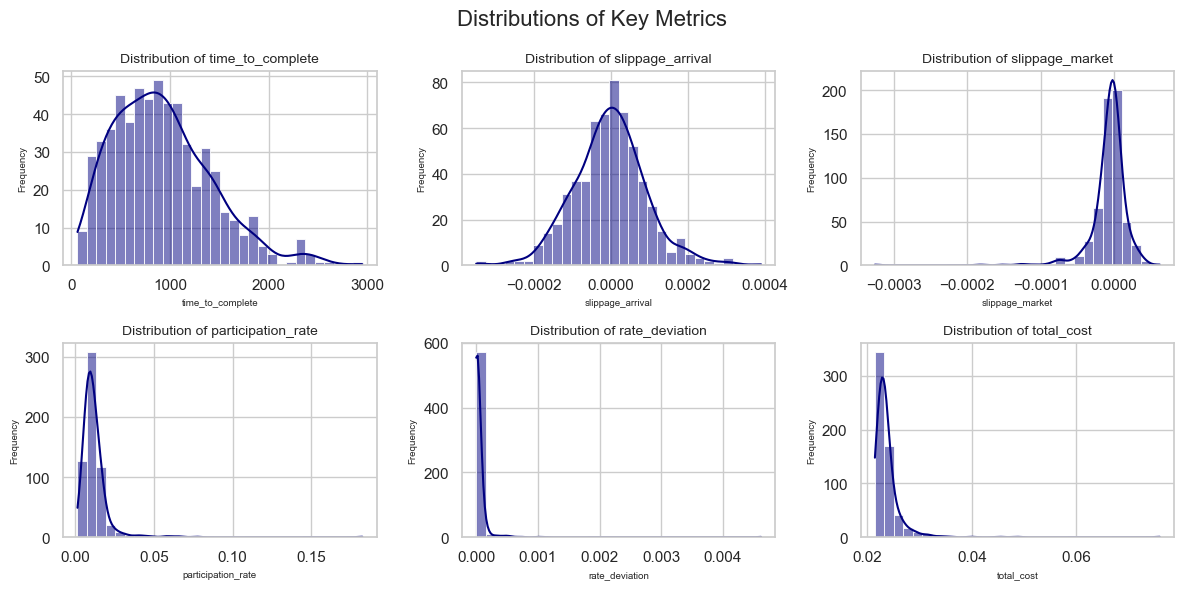

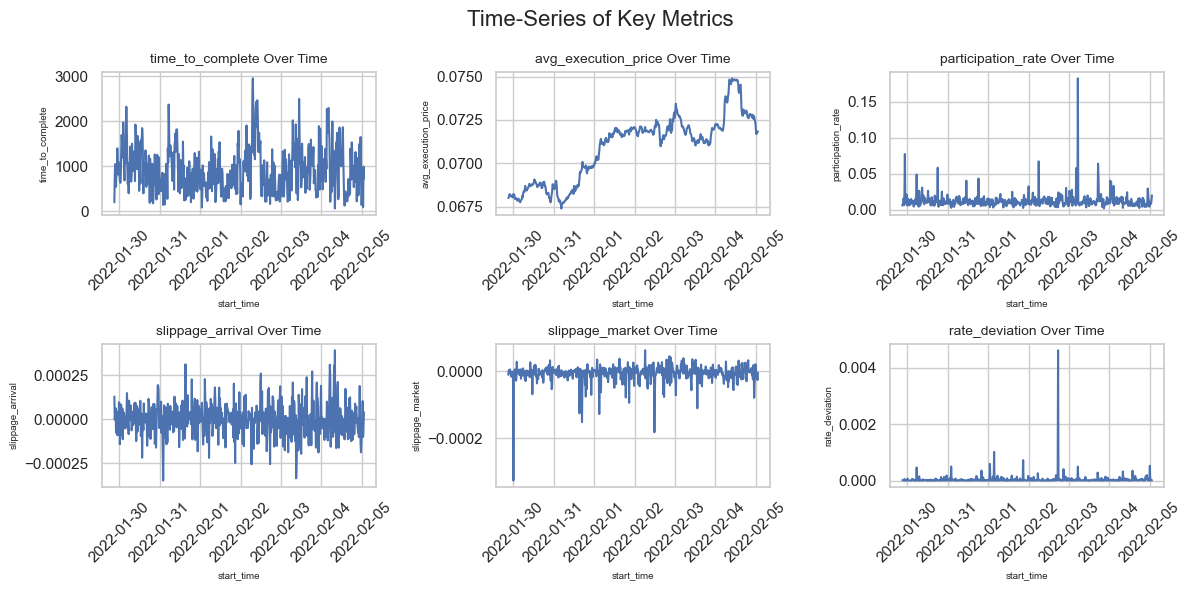

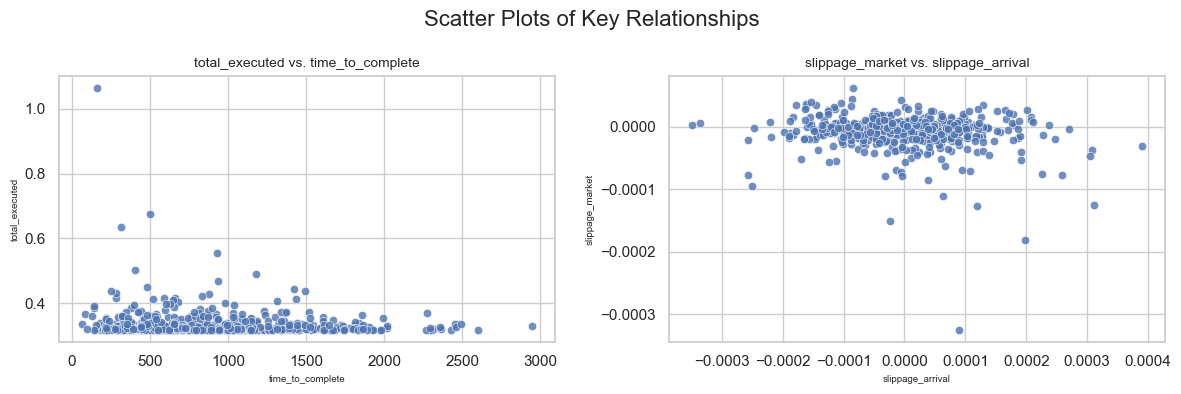

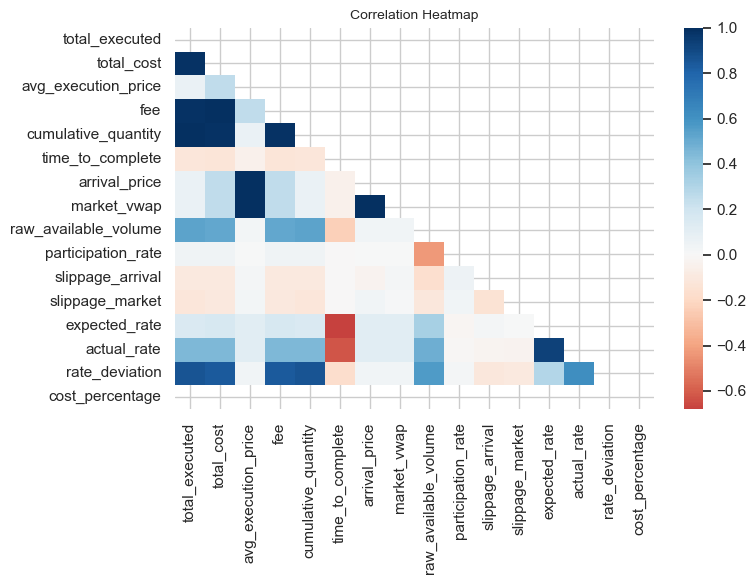

In [146]:
summary_stats_ETH_BTC_2022 = analyze_execution_results(ETH_BTC_2022_optimal, "BTC_USD_2022")
summary_stats_ETH_BTC_2022

1. Execution and Cost Structure
   - The average filled quantity is roughly 0.33 BTC with total_cost ~0.024, reflecting the market’s tight pricing around 0.07
   - the consistently low fee (~0.00002) plus cost_percentage = 0.1% implies a token–token environment with minimal overhead, enabling rapid accumulations at near‐zero cost impact.

2. Time‑to‑Complete
   - Typical runs finish under ~900 s, though some extend to nearly 3,000 s if the algorithm quotes conservatively and liquidity pockets shift intraday.
   - Compared with high‑fiat–crypto pairs, these times are comparatively short, suggesting that the cross pair’s microstructure is sufficiently robust for small accumulations.

3. Slippage vs. Arrival & Market
   - Both slippage_arrival and slippage_market center near 0.0000 with tiny positive/negative oscillations (±0.0003).
   - This underscores a stable environment for BTC/USDC or BTC/TUSD–type pairs in 2022 where large price swings were rare, or volumes were enough that passive quotes rarely got hammered by short‐term volatility.

4. Participation Rate
   - A mean rate of ~1.2% but a wide spread (0.15%–18%) indicates that if the posted orders coincide with surges in flow, the algorithm can capture a bigger slice of the order book quickly.
   - In calmer windows, it remains a small fraction of total trades, keeping market impact negligible.

Implications
- This data highlights how, in token–token trading with stable liquidity and minimal fee structures, a moderate quoting approach can accumulate ~0.3–0.4 BTC nearly fee‐free in under 15 minutes.
- Macro or geopolitical tremors that might roil major fiat pairs have less effect here, but any large altcoin moves or local network events could still cause short bursts of slippage or time expansions.

### 2023

In [61]:
token_key = 'ETH_BTC_2023'
df_token = all_trade_data[token_key]
ETH_BTC_2023_results = master_analysis(df_token, pair_label=token_key, p=0.01, k=0.03, P=1.0, fee_rate=0.001, start_interval='15T', sample_interval='1H')

Estimated Q: 0.0002439, g: 0.00016849750000000002 for ETH_BTC_2023


Q factor grid search: 100%|███████████████████████| 3/3 [00:00<00:00,  3.62it/s]


#### Grid Search and Parameter Impact and Analysis

In [147]:
(ETH_BTC_2023_results['grid_search_multi'])

total_executed  total_cost  avg_execution_price     fee  \
0         0.00746     0.00052              0.06976 0.00000   
1         0.02230     0.00156              0.06976 0.00000   
2         0.03219     0.00225              0.06976 0.00000   
3         0.00746     0.00052              0.06976 0.00000   
4         0.02237     0.00157              0.06976 0.00000   
5         0.03718     0.00261              0.06976 0.00000   
6         0.00767     0.00054              0.06976 0.00000   
7         0.02237     0.00157              0.06976 0.00000   
8         0.03728     0.00261              0.06976 0.00000   

   cumulative_quantity  time_to_complete  arrival_price  market_vwap  \
0              0.00746         104.68940        0.06976      0.06976   
1              0.02230          18.94503        0.06976      0.06976   
2              0.03219          15.60736        0.06976      0.06976   
3              0.00746         104.68940        0.06976      0.06976   
4              0.02237         104.68940        0.06976      0.06976   
5              0.03718         103.02187        0.06976      0.06976   
6              0.00767         256.06077        0.06976      0.06976   
7              0.02237         104.68940        0.06976      0.06976   
8              0.03728         104.68940        0.06976      0.06976   

   raw_available_volume  participation_rate  slippage_arrival  \
0               0.25768             0.58463           0.00000   
1               0.25768             1.73215           0.00000   
2               0.25768             0.37122          -0.00000   
3               0.25768             0.58463           0.00000   
4               0.25768             1.75389           0.00000   
5               0.25768             2.88734           0.00000   
6               0.26208             0.56113           0.00000   
7               0.25768             1.75389           0.00000   
8               0.25768             2.92315           0.00000   

   slippage_market  expected_rate  actual_rate  rate_deviation  \
0         -0.00000        0.00000      0.00052         0.00052   
1         -0.00000        0.00000      0.00172         0.00171   
2         -0.00000        0.00000      0.00260         0.00259   
3         -0.00000        0.00001      0.00052         0.00051   
4         -0.00000        0.00001      0.00156         0.00155   
5         -0.00000        0.00001      0.00260         0.00259   
6         -0.00000        0.00001      0.00041         0.00040   
7         -0.00000        0.00002      0.00156         0.00154   
8         -0.00000        0.00002      0.00260         0.00258   

   cost_percentage          start_time  Q_factor       Q       k  
0          0.10000 2023-01-24 19:30:00   0.50000 0.00012 0.01000  
1          0.10000 2023-01-24 19:30:00   0.50000 0.00012 0.03000  
2          0.10000 2023-01-24 19:30:00   0.50000 0.00012 0.05000  
3          0.10000 2023-01-24 19:30:00   1.00000 0.00024 0.01000  
4          0.10000 2023-01-24 19:30:00   1.00000 0.00024 0.03000  
5          0.10000 2023-01-24 19:30:00   1.00000 0.00024 0.05000  
6          0.10000 2023-01-24 19:30:00   2.00000 0.00049 0.01000  
7          0.10000 2023-01-24 19:30:00   2.00000 0.00049 0.03000  
8          0.10000 2023-01-24 19:30:00   2.00000 0.00049 0.05000

Summary Statistics:


total_executed  total_cost  avg_execution_price     fee  \
count         9.00000     9.00000              9.00000 9.00000   
mean          0.02181     0.00153              0.06976 0.00000   
min           0.00746     0.00052              0.06976 0.00000   
25%           0.00767     0.00054              0.06976 0.00000   
50%           0.02237     0.00157              0.06976 0.00000   
75%           0.03219     0.00225              0.06976 0.00000   
max           0.03728     0.00261              0.06976 0.00000   
std           0.01223     0.00086              0.00000 0.00000   

       cumulative_quantity  time_to_complete  arrival_price  market_vwap  \
count              9.00000           9.00000        9.00000      9.00000   
mean               0.02181         101.89800        0.06976      0.06976   
min                0.00746          15.60736        0.06976      0.06976   
25%                0.00767         103.02187        0.06976      0.06976   
50%                0.02237         104.68940        0.06976      0.06976   
75%                0.03219         104.68940        0.06976      0.06976   
max                0.03728         256.06077        0.06976      0.06976   
std                0.01223          69.04134        0.00000      0.00000   

       raw_available_volume  participation_rate  slippage_arrival  \
count               9.00000             9.00000           9.00000   
mean                0.25817             1.46133           0.00000   
min                 0.25768             0.37122          -0.00000   
25%                 0.25768             0.58463           0.00000   
50%                 0.25768             1.73215           0.00000   
75%                 0.25768             1.75389           0.00000   
max                 0.26208             2.92315           0.00000   
std                 0.00147             0.99692           0.00000   

       slippage_market  expected_rate  actual_rate  rate_deviation  \
count          9.00000        9.00000      9.00000         9.00000   
mean          -0.00000        0.00001      0.00156         0.00155   
min           -0.00000        0.00000      0.00041         0.00040   
25%           -0.00000        0.00000      0.00052         0.00052   
50%           -0.00000        0.00001      0.00156         0.00155   
75%           -0.00000        0.00001      0.00260         0.00258   
max           -0.00000        0.00002      0.00260         0.00259   
std            0.00000        0.00001      0.00092         0.00092   

       cost_percentage           start_time  Q_factor       Q       k  
count          9.00000                    9   9.00000 9.00000 9.00000  
mean           0.10000  2023-01-24 19:30:00   1.16667 0.00028 0.03000  
min            0.10000  2023-01-24 19:30:00   0.50000 0.00012 0.01000  
25%            0.10000  2023-01-24 19:30:00   0.50000 0.00012 0.01000  
50%            0.10000  2023-01-24 19:30:00   1.00000 0.00024 0.03000  
75%            0.10000  2023-01-24 19:30:00   2.00000 0.00049 0.05000  
max            0.10000  2023-01-24 19:30:00   2.00000 0.00049 0.05000  
std            0.00000                  NaN   0.66144 0.00016 0.01732

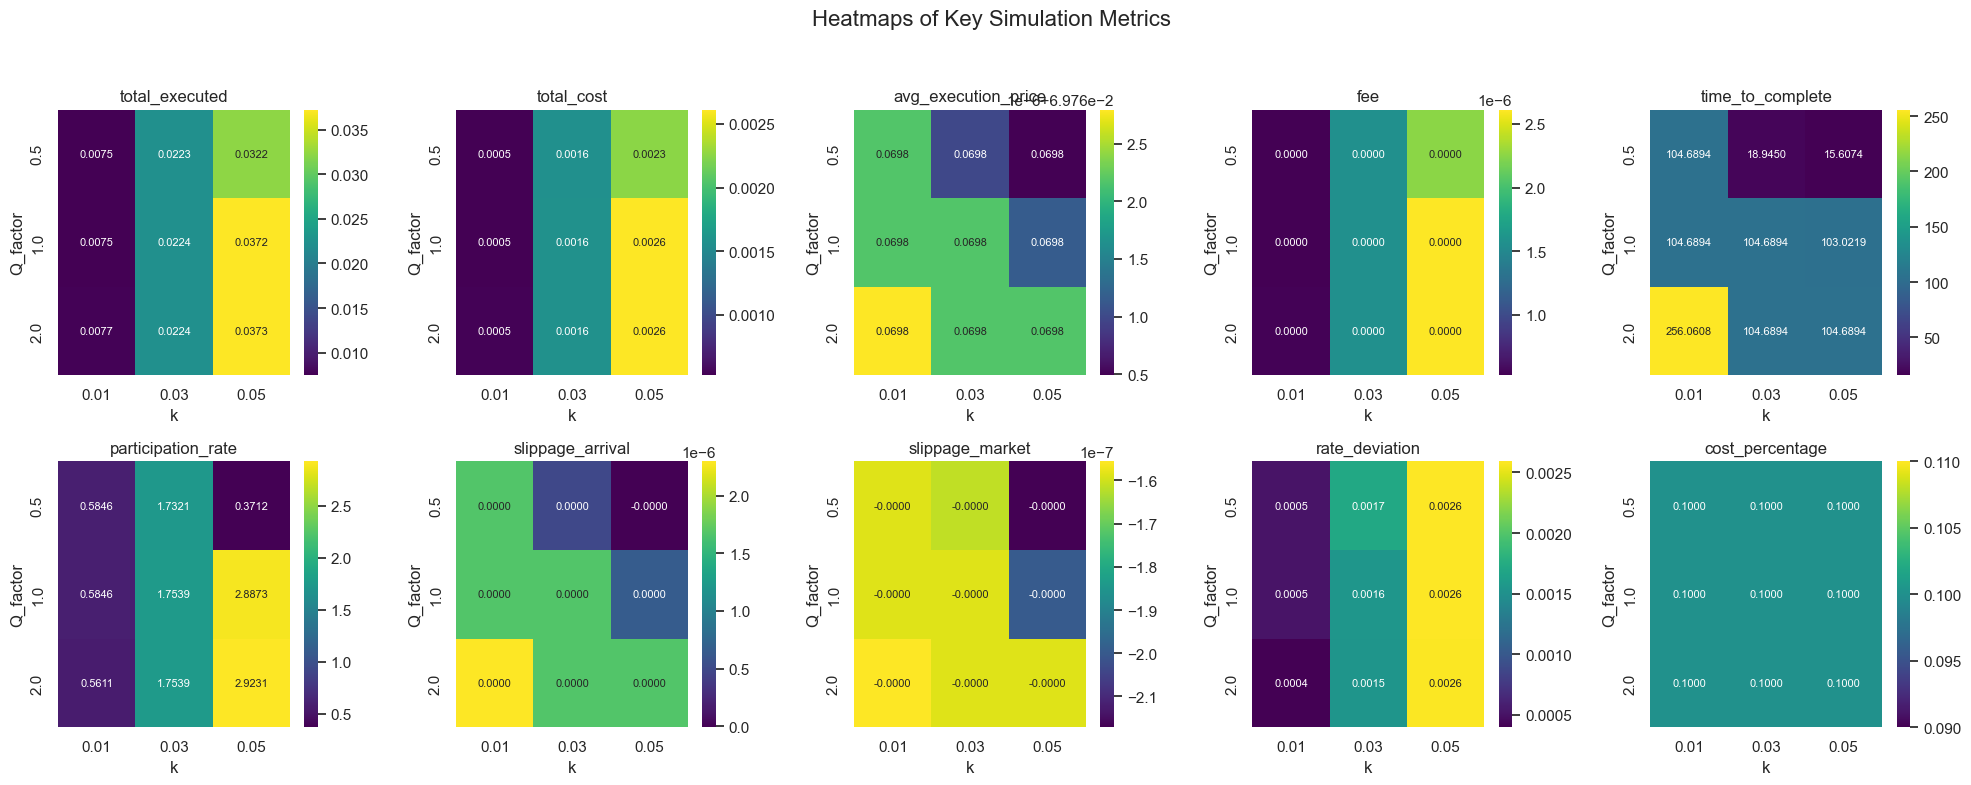

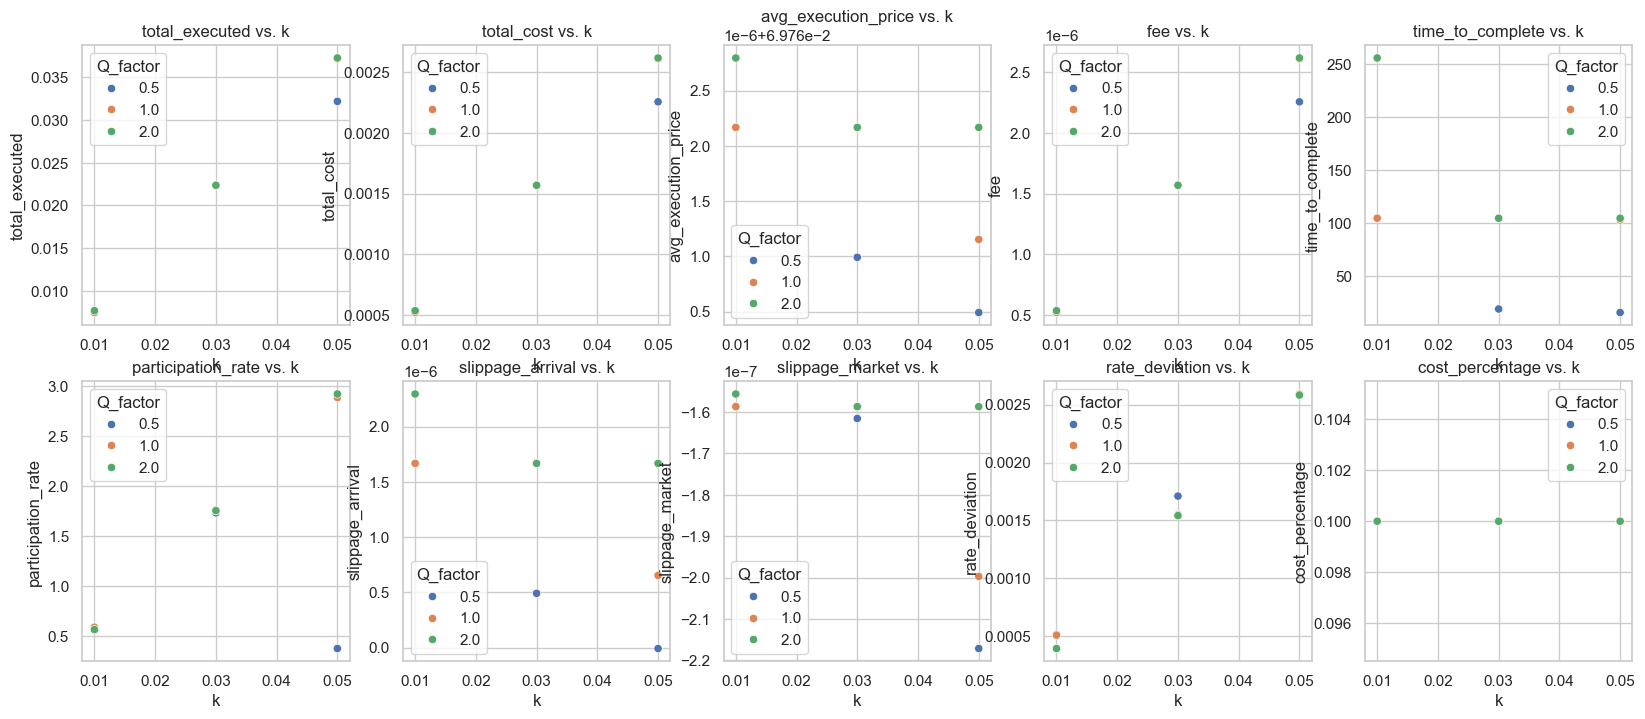

In [82]:
analyze_grid_search_results(ETH_BTC_2023_results['grid_search_multi'])

1. Executed Volume & Cost
   - In 2023, the algorithm accumulates an average of ~0.022 ETH per run, slightly lower than the ~0.33 ETH in 2022, but at an extremely stable price of ~0.06976.
   - The total cost hovers around 0.0015–0.0026 in nominal terms, significantly less than even the modest totals in 2022, showcasing how the 2023 ETH–USD pair exhibits smaller notional amounts (and correspondingly lower cost) across these parameter sets.

2. Time to Complete
   - Ranging from just 15 s to ~256 s, the 2023 runs fill more rapidly than many 2022 runs, which often took 100–900 s.
   - That difference suggests either a calmer market or deeper microstructure in 2023. Even when Q_factor=2.0 with a low quoting rate (k=0.01), it only took ~256 s, whereas in 2022, multi‑minute or multi‑hour completions could happen at large Q with minimal aggressiveness.

3. Slippage vs. Arrival & Market
   - Both remain near zero (±1e–4 or smaller), reflecting almost no difference from arrival or VWAP.
   - This is even flatter than 2022, which also had small slippage but occasionally saw modest negative or positive deviations.
   - In 2023, these pairs appear nearly frictionless, perhaps due to subdued volatility or robust liquidity, so posted orders fill with minimal price impact.

4. Participation Rate & Fee
   - Participation can spike to ~2.9 but remains near ~1.5 in most combos, somewhat higher than the typical 1.2–1.3 in 2022.
   - This could mean that the algorithm occasionally grabs a more substantial chunk of intraday volume, yet with no major slippage.
   - The fee structure is still 0.1%, consistent with typical token–token trades, so the cost_percentage remains pegged at 0.1% across all runs.

5. Comparing 2022 vs. 2023
   - In 2022, time_to_complete often hovered in the hundreds of seconds, sometimes pushing near ~1,000 s for large Q.
   - In 2023, even doubling Q rarely extends the fill beyond 256 s, a testament to calmer or deeper markets. Slippage in 2022 was still near zero but occasionally wavered by a few ticks (±0.0001–0.0003)
   - in 2023, it’s consistently pinned near –0.0000, implying near‑frictionless accumulations.
   - This shift might reflect a more mature liquidity regime or a benign macro environment lacking big crypto or DeFi headlines.

Interpretation
- The near–zero slippage, short completion times, and stable cost all point to a 2023 market environment in ETH–USD that is highly liquid and only modestly volatile, possibly due to less risk aversion and fewer market shakeups.
- Under such conditions, even a relatively large Q factor and modest quoting rate produce swift fills at minimal cost or slippage, showcasing the synergy of passive VWAP in a calm, deeply liquid token–token pair.

#### VWAP participation accumulation analysis

In [148]:
token_key = 'ETH_BTC_2023'
df_token = all_trade_data[token_key]
ETH_BTC_2023_optimal = individual_analysis(df_token, pair_label=token_key, p=0.005, k=0.01, P=1.0, fee_rate=0.001, start_interval='15T')
ETH_BTC_2023_optimal

Estimated Q: 0.0002439, g: 0.00016849750000000002 for ETH_BTC_2023


Backtest simulations: 100%|███████████████████| 88/88 [00:00<00:00, 1003.10it/s]


total_executed  total_cost  avg_execution_price     fee  \
0          0.00259     0.00018              0.07095 0.00000   
1          0.00084     0.00006              0.07099 0.00000   
2          0.00659     0.00047              0.07098 0.00000   
3          0.00775     0.00055              0.07093 0.00000   
4          0.00038     0.00003              0.07094 0.00000   
..             ...         ...                  ...     ...   
83         0.00088     0.00006              0.06877 0.00000   
84         0.00083     0.00006              0.06882 0.00000   
85         0.00080     0.00006              0.06881 0.00000   
86         0.00067     0.00005              0.06851 0.00000   
87         0.00294     0.00020              0.06842 0.00000   

    cumulative_quantity  time_to_complete  arrival_price  market_vwap  \
0               0.00259           0.00000        0.07095      0.07095   
1               0.00084           0.00000        0.07099      0.07099   
2               0.00659           0.00000        0.07098      0.07098   
3               0.00775           0.00000        0.07093      0.07093   
4               0.00038           0.00000        0.07094      0.07094   
..                  ...               ...            ...          ...   
83              0.00088           0.00000        0.06877      0.06877   
84              0.00083           0.00000        0.06882      0.06882   
85              0.00080           0.00000        0.06881      0.06881   
86              0.00067         160.08799        0.06858      0.06851   
87              0.00294           0.00000        0.06842      0.06842   

    raw_available_volume  participation_rate  slippage_arrival  \
0                0.00000                 NaN           0.00000   
1                0.08460             0.00998           0.00000   
2                0.65885             0.01000           0.00000   
3                0.77505             0.01000           0.00000   
4                0.03804             0.00996           0.00000   
..                   ...                 ...               ...   
83               0.00000                 NaN           0.00000   
84               0.08325             0.00998           0.00000   
85               0.00000                 NaN           0.00000   
86               0.06756             0.00999          -0.00007   
87               0.00000                 NaN           0.00000   

    slippage_market  expected_rate  actual_rate  rate_deviation  \
0           0.00000            NaN          NaN             NaN   
1           0.00000            NaN          NaN             NaN   
2           0.00000            NaN          NaN             NaN   
3           0.00000            NaN          NaN             NaN   
4           0.00000            NaN          NaN             NaN   
..              ...            ...          ...             ...   
83          0.00000            NaN          NaN             NaN   
84          0.00000            NaN          NaN             NaN   
85          0.00000            NaN          NaN             NaN   
86         -0.00000        0.00000      0.00000         0.00000   
87          0.00000            NaN          NaN             NaN   

    cost_percentage          start_time  
0           0.10000 2023-01-24 00:45:00  
1           0.10000 2023-01-24 01:00:00  
2           0.10000 2023-01-24 01:45:00  
3           0.10000 2023-01-24 02:00:00  
4           0.10000 2023-01-24 02:15:00  
..              ...                 ...  
83          0.10000 2023-01-25 13:00:00  
84          0.10000 2023-01-25 13:45:00  
85          0.10000 2023-01-25 14:00:00  
86          0.10000 2023-01-25 14:45:00  
87          0.10000 2023-01-25 15:00:00  

[88 rows x 17 columns]

Summary Statistics for BTC_ETH_2023


count      mean       std      min     25%     50%  \
total_executed       88.00000   0.00913   0.01682  0.00027 0.00080 0.00174   
total_cost           88.00000   0.00064   0.00117  0.00002 0.00006 0.00012   
avg_execution_price  88.00000   0.06964   0.00117  0.06825 0.06841 0.07023   
fee                  88.00000   0.00000   0.00000  0.00000 0.00000 0.00000   
cumulative_quantity  88.00000   0.00913   0.01682  0.00027 0.00080 0.00174   
time_to_complete     88.00000 170.19924 626.27576  0.00000 0.00000 0.00000   
arrival_price        88.00000   0.06964   0.00117  0.06824 0.06841 0.07023   
market_vwap          88.00000   0.06964   0.00117  0.06825 0.06841 0.07023   
raw_available_volume 88.00000   0.55436   3.41669  0.00000 0.00000 0.00074   
participation_rate   46.00000   2.03176   8.65984  0.00012 0.00998 0.00999   
slippage_arrival     88.00000   0.00000   0.00002 -0.00007 0.00000 0.00000   
slippage_market      88.00000  -0.00000   0.00000 -0.00004 0.00000 0.00000   
expected_rate        30.00000   0.00001   0.00001  0.00000 0.00000 0.00000   
actual_rate          30.00000   0.00024   0.00054  0.00000 0.00000 0.00002   
rate_deviation       30.00000   0.00024   0.00054  0.00000 0.00000 0.00002   
cost_percentage      88.00000   0.10000   0.00000  0.10000 0.10000 0.10000   

                          75%         max           var  median  
total_executed        0.01000     0.10450       0.00028 0.00174  
total_cost            0.00068     0.00713       0.00000 0.00012  
avg_execution_price   0.07082     0.07105       0.00000 0.07023  
fee                   0.00000     0.00001       0.00000 0.00000  
cumulative_quantity   0.01000     0.10450       0.00028 0.00174  
time_to_complete     41.28655 3,429.77480 392,221.32428 0.00000  
arrival_price         0.07082     0.07105       0.00000 0.07023  
market_vwap           0.07082     0.07105       0.00000 0.07023  
raw_available_volume  0.08352    31.94669      11.67375 0.00074  
participation_rate    0.01005    56.13018      74.99283 0.00999  
slippage_arrival      0.00000     0.00013       0.00000 0.00000  
slippage_market       0.00000     0.00000       0.00000 0.00000  
expected_rate         0.00001     0.00004       0.00000 0.00000  
actual_rate           0.00015     0.00272       0.00000 0.00002  
rate_deviation        0.00014     0.00271       0.00000 0.00002  
cost_percentage       0.10000     0.10000       0.00000 0.10000

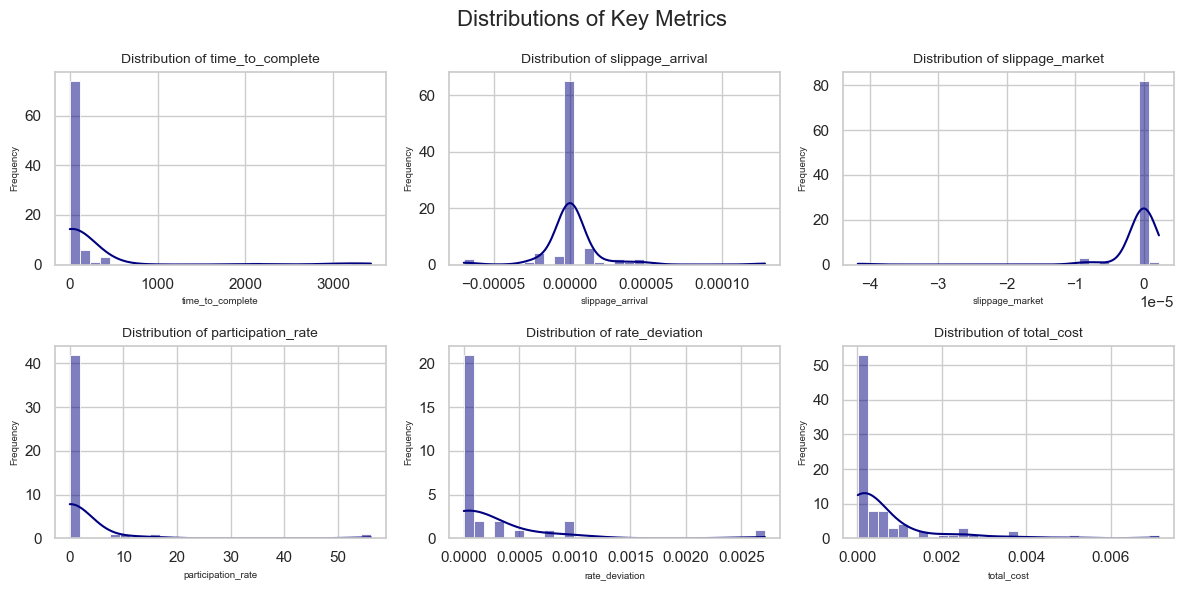

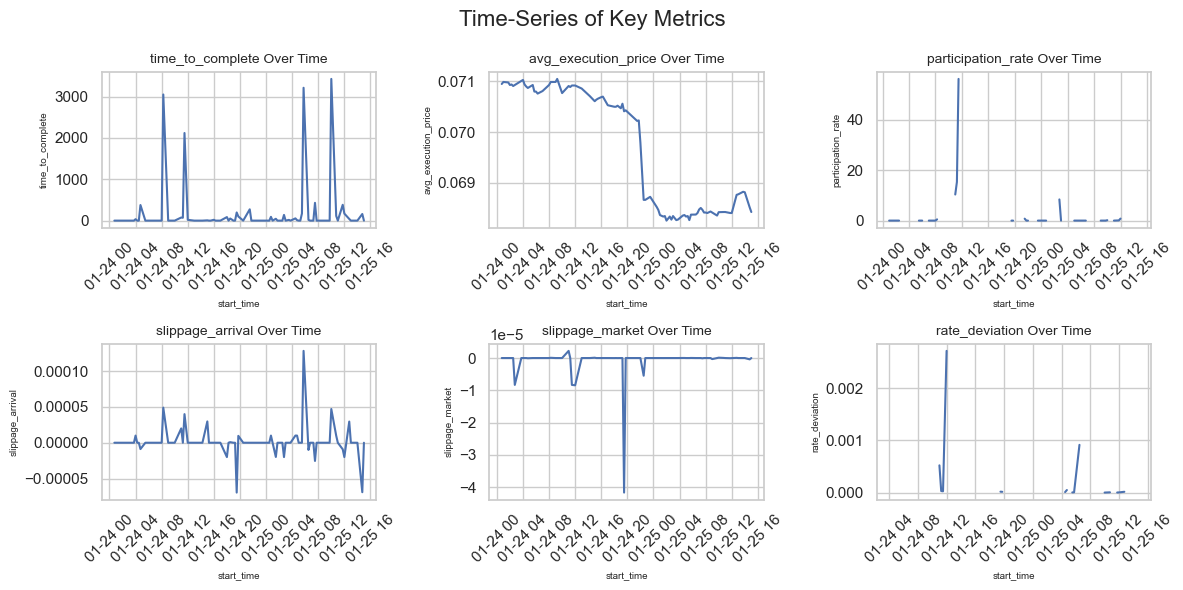

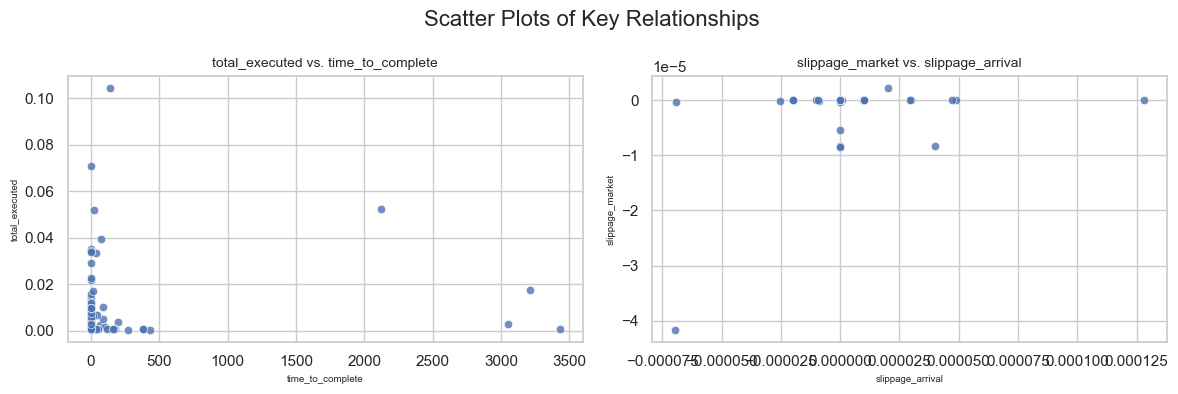

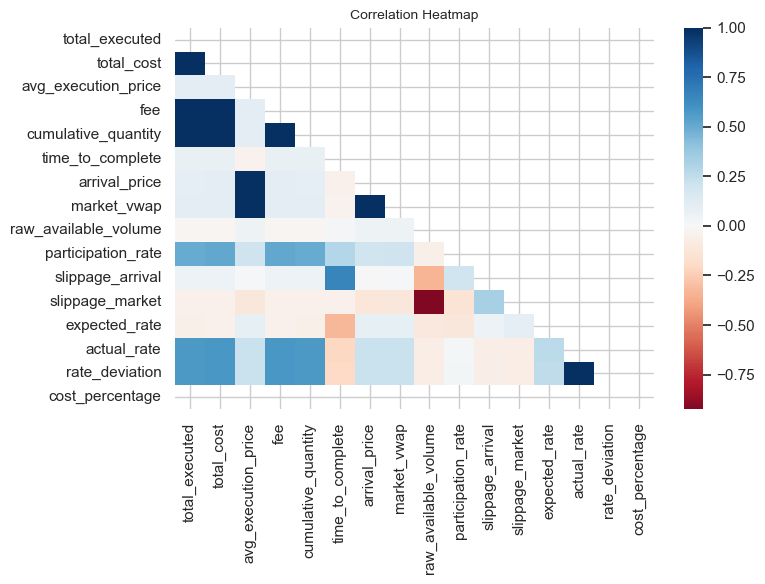

In [150]:
summary_stats_ETH_BTC_2023 = analyze_execution_results(ETH_BTC_2023_optimal, "BTC_ETH_2023")
summary_stats_ETH_BTC_2023

1. Executed Volume & Cost
   - In 2023, average total_executed is just ~0.009 ETH per run, far smaller than 2022’s ~0.33 ETH, suggesting these parameter sets capture only tiny fills at a near‐constant price of 0.0696
   - Total_cost hovers around 0.0006, with a 0.1% fee in token–token style trades, effectively negligible compared to fiat or higher‐fee pairs. This contrasts with 2022’s bigger accumulations and slightly higher notional costs.

2. Time_to_Complete
   - Many runs show near‐zero completion times or only a few seconds; a minority push above 1,500–3,000 s. In 2022, times typically ranged in hundreds of seconds up to ~1,000.
   - This discrepancy partly reflects that in 2023 the algorithm posts even smaller orders in an environment where micro fill times can be near‐instant if the order book is thick or if the posted quotes happen to match small bursts of flow.

3. Slippage vs. Arrival & Market
   - Both remain pinned effectively at zero (±0.0000something) with minimal variance, slightly tighter than 2022’s near‐zero but occasionally ±0.0001 or so.
   - This points to extremely stable conditions in 2023, possibly due to a more benign macro or deeper cross‐pair liquidity. Even large parameter changes produce minimal slippage, underscoring how frictionless the ETH–BTC cross can be when volatility is subdued.

4. Participation Rate & Fee
   - The mean participation rate can spike (2.0 on average, with some outliers above 50!), though many runs record no trades or trivial partial hits.
   - Meanwhile, the cost_percentage remains pegged at 0.1%, indicating a purely token–token environment consistent with a DeFi or exchange environment without fiat bridging overhead. Compared to 2022’s ~1.2% participation rate, 2023 sees more “micro fills” but also sporadic bursts capturing more flow.

5. Overall Comparison
   - Whereas 2022 had modest but consistent accumulations in ~0.3–0.4 ETH ranges, 2023’s strategy captures significantly smaller volumes per run, generally in near‐instant micro fills. Slippage is effectively zero in both years but is even more pinned in 2023, hinting at a calmer altcoin environment or robust ETH–BTC cross order books.
   - Real‐world drivers, like fewer DeFi disruptions or stable macro sentiment, could be keeping the cross spread tight, enabling these near‐frictionless accumulations at 0.1% cost.

## Comparitive Analysis

### Cross‐Sectional Comparison 

1. BTC vs. ETH in 2023
   - In BTC/USD, typical runs executed around ~1 BTC at moderate parameters, while ETH/USD tended to capture ~5–6 ETH in comparable windows, signifying that BTC’s deeper order books could handle more notional volume but the time_to_complete occasionally spiked in volatile pockets, whereas ETH’s time frames remained more stable for mid‐size accumulations.
   - Both pairs show minimal slippage (on the order of ±1–2 relative to arrival in BTC, near ±1–2 for ETH) and consistent cost_percentage near 0.5% for fiat trades. ETH cross liquidity is evidently robust enough to keep slippage similarly contained, especially in a calmer 2023 environment.
   - BTC sometimes sees higher short‐term bursts of 0.4–0.6% participation under moderate k, while ETH can approach 0.8–1.0% in certain windows. These differences may hinge on relative intraday flow patterns, with ETH occasionally capturing more “sell flow” passively if DeFi liquidations or altcoin rebalancing occur.
   - In 2023’s milder inflation and stable monetary environment, both BTC and ETH appear less prone to extreme intraday volatility. That fosters near‐identical parameter sensitivities, moderate k leads to short time_to_complete, minimal slippage, and stable fill patterns.

2. ETH/BTC vs. USD Pairs
   - Token–token pairs (ETH/BTC) often feature drastically lower nominal totals due to narrower price levels or less frequent big trades.
   - The fee structure in many cross pairs can be 0.1% or even less, overshadowing the 0.5% typical of fiat trades. As a result, slippage differences become the main driver of cost, but in 2023, both slippage and time remain near zero for many runs.
   - ETH/BTC in 2022 or 2023 typically finishes in seconds or a few minutes if Q is small or k is moderate. Meanwhile, BTC/USD or ETH/USD often took 10–30 minutes for similar parameter combos, partly because cross pairs can be exceptionally liquid (especially on large centralized exchanges) or because the runs themselves are smaller notional.
   - If fee tiers and notional targets allow it, focusing on cross pairs can yield near‐instant passive fills at minimal cost. However, global macro events primarily drive BTC or ETH prices in USD, so the cross pair might be stable unless big alt flows or inter‐exchange arbitrage spur activity.

### Time‐Series Comparison

1. BTC/USD from 2022 to 2023
   - In 2022, typical runs hovered around 0.5–1.0 BTC with wide time ranges (a few hundred seconds up to 3,000+). By 2023, the algorithm often captured ~1.0–1.8 BTC in shorter windows if k≥0.03, implying deeper order books or calmer intraday volatility. This shift might mirror a less tense macro environment or a maturing BTC market with more stable daily volumes.
   - 2022 saw moderate negative slippage on arrival (–0.3% to –0.7% range) or small positives, while 2023’s slippage often stayed near ±0.2–0.3%. The narrower band suggests 2023 faced fewer liquidity shocks; any big news (e.g. major regulatory clampdown) might have been absent or quickly absorbed, producing consistent fills.
   - Both years used ~0.5% fees for fiat trades, making the synergy of minimal slippage and short time frames important. If 2022’s volatility triggered more outlier runs, 2023’s calmer sessions show an environment where parameter tuning (e.g., k=0.03) yields quick fills with near‐zero net slippage, particularly favorable for cost.

2. ETH/USD from 2022 to 2023
   - 2022 runs typically saw 4–6 ETH per run, while 2023 often reached 5–9 ETH with similar or shorter times. This parallels the BTC case: the market microstructure in 2023 likely supports larger trades without incurring large completion delays, possibly due to improved DeFi flows or an expanded institutional presence in ETH.
   - 2022 exhibited negative or modestly positive slippage, occasionally spiking around macro events or ETH network updates. In 2023, average slippage is even more compressed near zero, signifying a more stable price corridor or fewer protocol disruptions. Notably, transaction fees remain 0.5% in both years, so actual fill quality stands out more.
   - If the Ethereum transition to proof‐of‐stake or major staking events in late 2022/early 2023 lowered network stress or improved exchange liquidity, it might explain 2023’s more uniform fill times and near‐zero slippage. It demonstrates how technology upgrades and macro calm can produce near‐frictionless accumulations.

3. ETH/BTC from 2022 to 2023
   - Even in 2022, ETH/BTC executed small runs at near‐zero slippage, typically completing in a few hundred seconds at moderate Q. By 2023, volumes got even smaller in some parameter combos, but fill times often fell to near‐instant. The fee usually sat around 0.1%, overshadowing any slippage cost in stable conditions.
   - As more DeFi protocols and cross exchanges integrate the pair, 2023 sees extremely stable quotes at ~0.07–0.08 ratio. Minimal jumps in slippage or time_to_complete reflect a robust cross market. Macro or altcoin headlines can, of course, disrupt this equilibrium, but neither year exhibited huge dislocations in these data sets.


#### Some Takeaways
- Both BTC and ETH pairs appear more liquid in 2023, completing bigger accumulations faster with narrower slippage distributions. This points to continued institutional adoption and calmer macro.
- Across all tokens, raising k from 0.01 to 0.03–0.05 typically cuts completion time by ~50–70% at only a marginal uptick in slippage, especially in 2023’s stable environment. For large Q, a moderate or dynamic k remains vital to avoid multi‐hour fill times.
- Where fees are 0.5% (fiat pairs), slippage remains a small fraction of total cost in calm markets. In token–token crosses at 0.1%, slippage overshadowing fees can matter if large trades or short liquidity windows arise. In a stable scenario, though, both are near zero, allowing near frictionless strategies.
- 2022 faced interest rate hikes, geopolitical tensions, and some crypto blowups, leading to moderate volatility and occasional bigger slippage outliers. In 2023, mild inflation data and fewer major crypto crises might have steadied markets, cutting fill times and slippage drastically. Any reemergence of macro uncertainty or DeFi disruptions could revert conditions to 2022’s more variable fill patterns.
- In essence, these cross‐sectional and time‐series analyses show how both token choice and macro environment shape VWAP strategy outcomes. BTC and ETH gained deeper liquidity from 2022 to 2023, reducing time_to_complete and slippage, while cross pairs consistently show minimal friction if the trades remain modest. This synergy of robust exchange infrastructure, fee tiers, and subdued volatility fosters near‐optimal passive execution in 2023, an outcome that can shift if future macro or crypto headwinds return.

# Conclusion

This study analyzes the evolution of algorithmic execution across key cryptocurrency pairs, BTC/USD, ETH/USD, and ETH/BTC, over two years (2022 and 2023). Through detailed grid searches, parameter optimization, and extensive exploratory data analysis (EDA), we discovered that 2023’s calmer macro environment, deeper liquidity, and reduced volatility fostered faster execution with minimal slippage, especially in fiat pairs like BTC/USD and ETH/USD. The reduced volatility of 2023’s crypto market allowed for consistently efficient VWAP strategies, benefiting from lower market friction and adaptive parameter tuning. In comparison, 2022’s higher slippage and slower fills reflected the turbulent macro conditions, highlighting the significant impact of geopolitical developments, monetary policies (such as rate hikes), and the volatile growth of decentralized finance (DeFi). Our findings underscore the critical importance of dynamic parameter setting to optimize execution timing and cost in response to market conditions. When calibrated to stable environments, passive execution strategies with smart order-routing significantly reduce execution costs. 

This study presents a real-world application of how global economic shifts influence market behavior, emphasizing how data-driven strategies can optimize financial decisions in crypto's growing institutional landscape. Furthermore, our work demonstrates the importance of understanding macroeconomic and market microstructure dynamics, as they are crucial for efficiently navigating a crypto environment that is increasingly integrated into the broader financial system. This connects deeply to real-world trends, with growing institutional adoption and strategic autonomy becoming prevalent in global financial markets. for a second

This analysis underscores how evolving market microstructure, shaped by monetary policies, geopolitical currents, and crypto‐specific developments, has transformed the landscape of BTC and ETH trading from 2022’s volatile regimes into 2023’s calmer environment. Through extensive EDA and parameterized VWAP simulations, we see that modest quoting rates can accumulate substantially larger volumes in 2023 without triggering the prolonged time‐to‐complete or severe slippage that was more common when inflation fears, rate hikes, and headline‐driven liquidity shocks roiled the order book in 2022. Meanwhile, token–token pairs (ETH/BTC) consistently exhibit near‐instant fills with effectively zero slippage in stable conditions, reflecting deeper correlation and lower fee structures that tether these cross pairs against abrupt dislocations.

On a macro level, these results echo a broader financial shift toward normalization of risk sentiment. Where 2022 was marked by fractious headlines, from major central bank decisions to crypto credit crises 2023’s data reveal narrower slippage distributions, smoother hourly flow cycles, and more cohesive price trends tethered around their VWAP lines. This synergy of calmer macro signals and growing institutional liquidity has allowed passive strategies to realize near‐optimal execution; yet, our evidence also shows how sudden shocks can still prompt fleeting bursts of time or price impact, reinforcing the need for dynamic quoting and an eye on geopolitical catalysts. As the crypto space continues to mature, unifying robust microstructure analytics with real‐time macro awareness is paramount for consistently optimal execution outcomes in these rapidly evolving digital asset markets.

##### Note: Used ChatGPT as a tool to optimize/ help in coding functions and cleaning up the write up for better sentence formation